Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data lung
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/lungCancer_test.data"
url_train = "https://raw.githubusercontent.com/jamessaldo/final-task/master/lungCancer_train.data"
data_train = pd.read_csv(url_test, header=None)
data_test = pd.read_csv(url_train, header=None)
data_lung = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Lung Cancer:',data_lung.isnull().sum().sum())

Total Missing Value pada Data Lung Cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data lung
data_new_lung = data_lung.drop([12533],axis=1)
scaler = MinMaxScaler()
data_new_lung = scaler.fit_transform(data_new_lung)
data_new_lung = DataFrame(data_new_lung)
data_new_lung['label'] = list(data_lung[12533])
dic = {'Mesothelioma':0,'ADCA':1}
data_new_lung.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah hidden layer kedua
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah hidden layer kedua
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Lung Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 99.5):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Lung

In [9]:
data_X = data_new_lung.drop(['label'],axis=1)
data_Y = data_new_lung['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Lung_IG = pd.DataFrame(data_X_new)
Lung_IG['label'] = data_Y
useddata_lung = Lung_IG
print(useddata_lung.shape)
Lung_IG

(181, 101)


0         1         2         3         4         5         6  \
0    0.227107  0.115484  0.031897  0.148000  0.032804  0.053853  0.070115   
1    0.121110  0.140638  0.033685  0.326769  0.021254  0.077068  0.142478   
2    0.053042  0.151513  0.027471  0.536154  0.100337  0.233083  0.127850   
3    0.075560  0.136939  0.035451  0.297846  0.041787  0.425282  0.098431   
4    0.042682  0.154842  0.029907  0.311231  0.030558  0.230451  0.059124   
..        ...       ...       ...       ...       ...       ...       ...   
176  0.248555  0.110232  0.027516  0.140308  0.557026  0.036184  0.125848   
177  0.346076  0.189243  0.067683  0.129077  0.542830  0.034211  0.258397   
178  0.238067  0.183991  0.128884  0.149846  0.146615  0.050658  0.130179   
179  0.125562  0.171192  0.123609  0.166462  0.121270  0.058929  0.298766   
180  0.119954  0.310868  0.028477  0.130154  0.328842  0.062406  0.218763   

            7         8         9  ...        91        92        93  \
0    0.073506  0.204635  0.195675  ...  0.048007  0.121490  0.305688   
1    0.691464  0.189431  0.294997  ...  0.100909  0.021149  0.206095   
2    0.687512  0.287886  0.438944  ...  0.084447  0.029413  0.228975   
3    0.579355  0.194826  0.127305  ...  0.055119  0.023577  0.162454   
4    0.120202  0.178028  0.298919  ...  0.089821  0.023891  0.042101   
..        ...       ...       ...  ...       ...       ...       ...   
176  0.081473  0.456229  0.124444  ...  0.013425  0.160537  0.062485   
177  0.024028  0.561795  0.108544  ...  0.025672  0.167979  0.058005   
178  0.061619  0.322707  0.146915  ...  0.023774  0.292798  0.083348   
179  0.048498  0.298063  0.173945  ...  0.049605  0.093291  0.114744   
180  0.077110  0.526116  0.071444  ...  0.003836  0.463400  0.239646   

           94        95        96        97        98        99  label  
0    0.030695  0.013913  0.242249  0.114315  0.100457  0.076336      0  
1    0.150019  0.035602  0.676313  0.080490  0.046804  0.087627      0  
2    0.182091  0.040311  0.606449  0.078683  0.078196  0.081266      0  
3    0.122005  0.023188  0.326581  0.094860  0.069064  0.084288      0  
4    0.351762  0.009775  0.381976  0.191195  0.082192  0.076495      0  
..        ...       ...       ...       ...       ...       ...    ...  
176  0.026567  0.086187  0.250517  0.074152  0.218607  0.138041      1  
177  0.028190  0.146404  0.186441  0.054738  0.117580  0.113073      1  
178  0.023321  0.173373  0.145515  0.078792  0.567352  0.483779      1  
179  0.054652  0.090325  0.207110  0.054950  0.301370  0.123887      1  
180  0.013584  0.085474  0.126085  0.017199  0.212329  0.282920      1  

[181 rows x 101 columns]

# 4. Classification

## Lung + IG

Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96  97  98 100 112 114 116 129 130 136 138 140 141 146 160 162 167 168
 180]
Y_Train : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

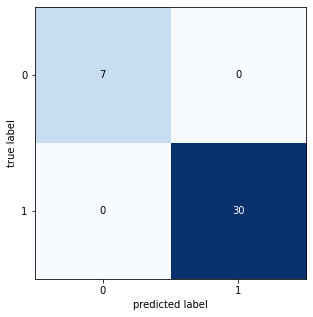

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

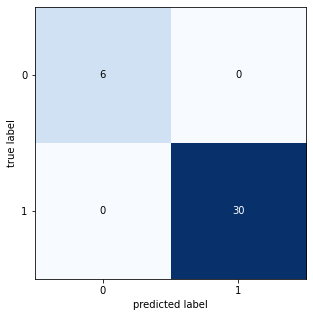

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

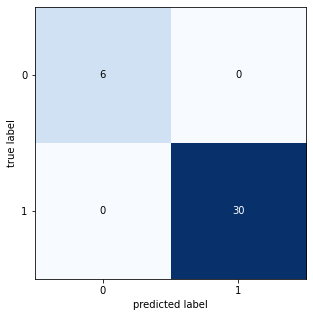

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

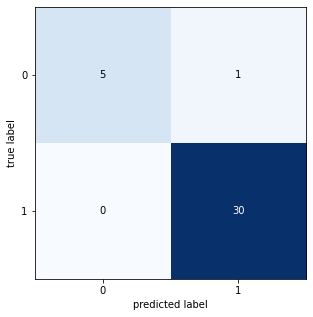

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

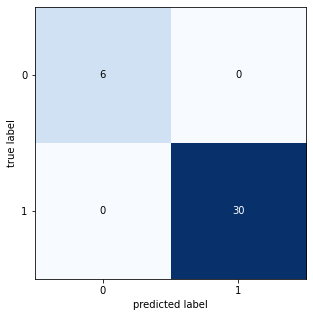

avg accuraccy Lung cancer =  0.9944444444444445
avg F1_Score Lung cancer =  0.9892697466467958
max accuraccy Lung cancer =  1.0
max F1_Score Lung cancer =  1.0
min accuraccy Lung cancer =  0.9722222222222222
min F1_Score Lung cancer =  0.9463487332339791
Running Time:  34.846704145998956


(0.9944444444444445, 0.9892697466467958)

In [10]:
FLNN_Classifier(Lung_IG,"Lung cancer",2)

Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96  97  98 100 112 114 116 129 130 136 138 140 141 146 160 162 167 168
 180]
Y_Train : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

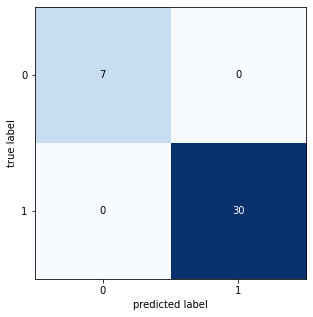

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

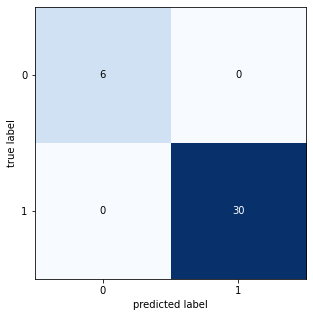

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

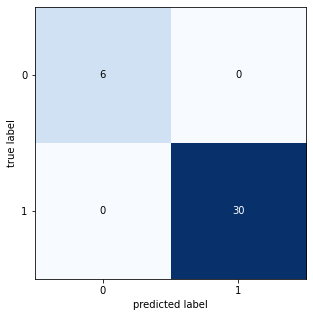

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

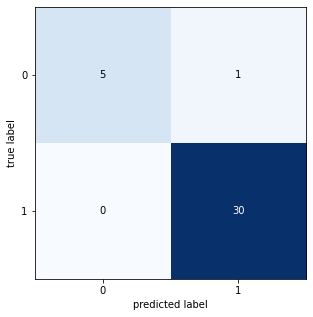

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

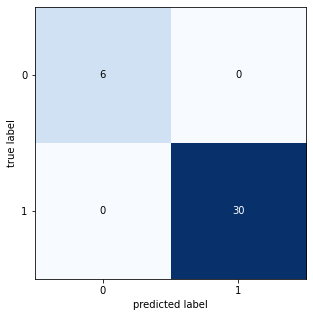

avg accuraccy Lung cancer =  0.9944444444444445
avg F1_Score Lung cancer =  0.9892697466467958
max accuraccy Lung cancer =  1.0
max F1_Score Lung cancer =  1.0
min accuraccy Lung cancer =  0.9722222222222222
min F1_Score Lung cancer =  0.9463487332339791
Running Time:  34.7109498059981


(0.9944444444444445, 0.9892697466467958)

In [11]:
FLNN_Classifier(Lung_IG,"Lung cancer",3)

Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96  97  98 100 112 114 116 129 130 136 138 140 141 146 160 162 167 168
 180]
Y_Train : [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

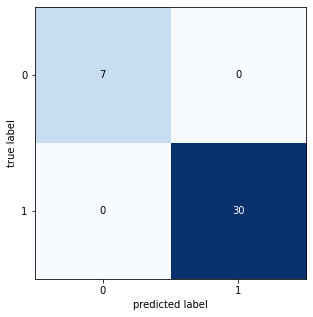

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

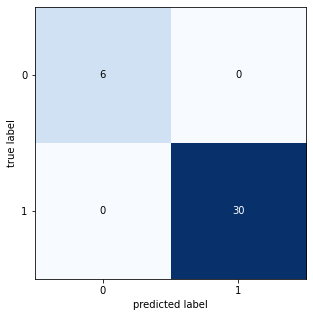

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

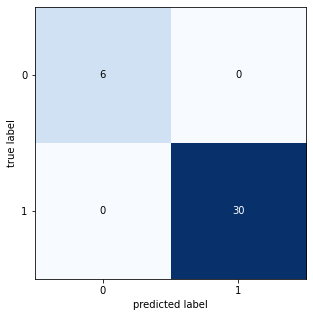

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

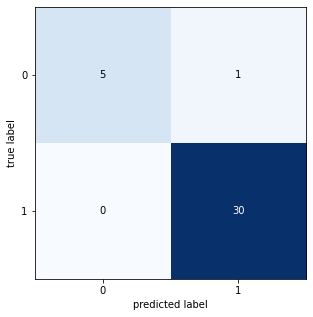

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

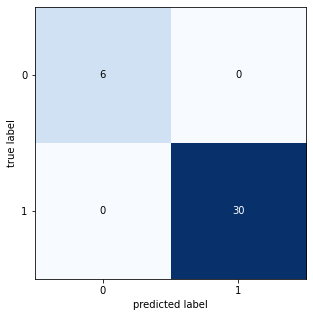

avg accuraccy Lung cancer =  0.9944444444444445
avg F1_Score Lung cancer =  0.9892697466467958
max accuraccy Lung cancer =  1.0
max F1_Score Lung cancer =  1.0
min accuraccy Lung cancer =  0.9722222222222222
min F1_Score Lung cancer =  0.9463487332339791
Running Time:  36.043080084000394


(0.9944444444444445, 0.9892697466467958)

In [12]:
FLNN_Classifier(Lung_IG,"Lung cancer",4)

## Lung + IG + GA

Generation : 0
gene : [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96

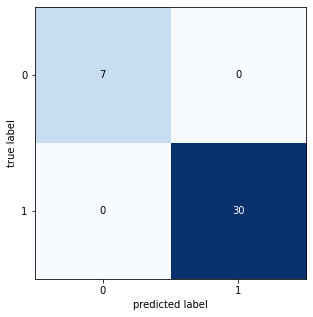

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

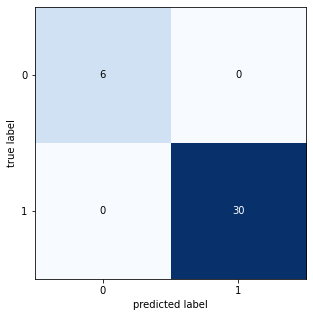

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

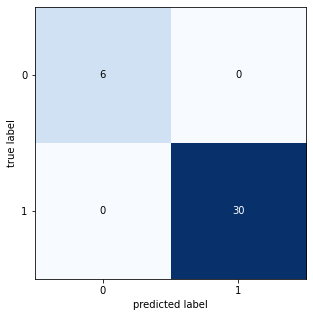

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

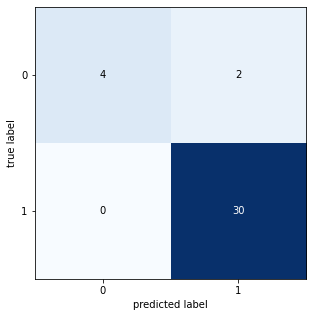

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

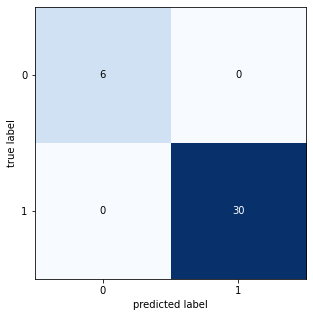

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.38410055900022
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

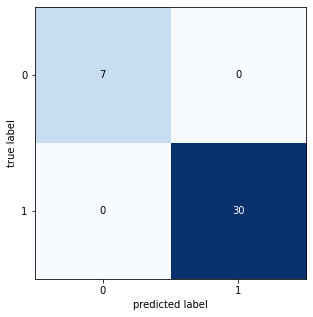

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

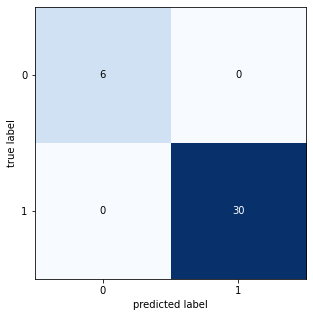

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

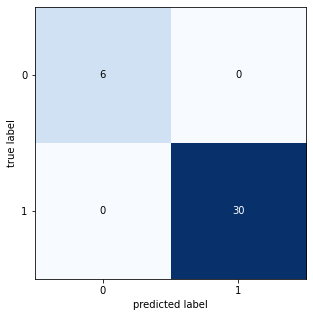

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

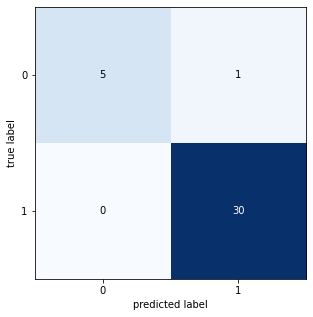

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

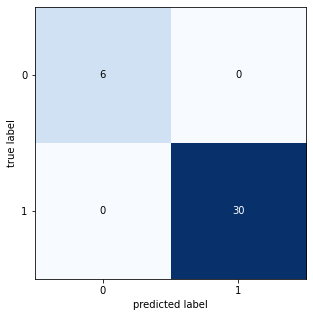

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.35689659000127
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

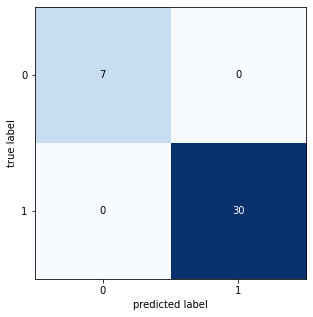

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

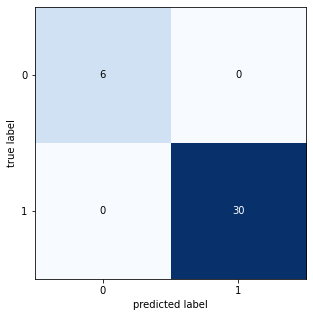

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

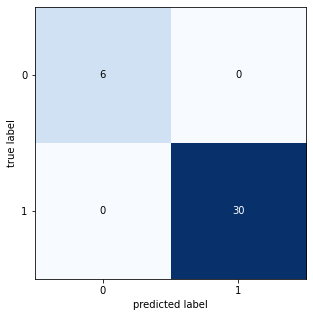

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

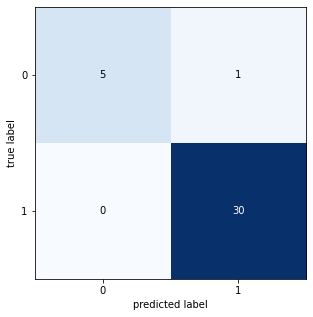

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

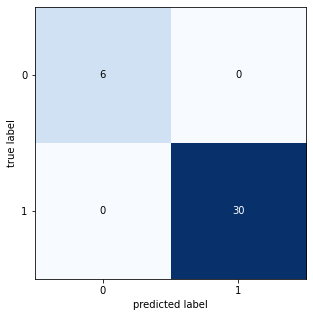

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.3372188430003
gene : [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

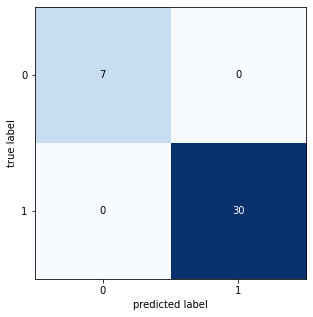

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

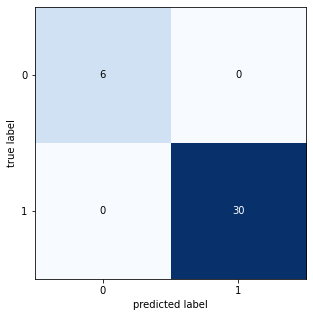

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

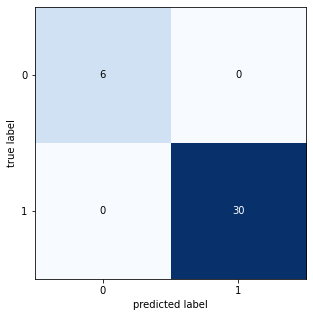

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

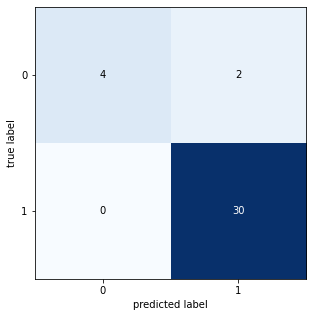

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

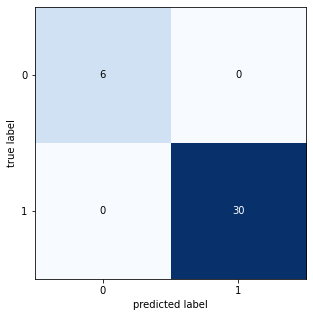

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.6918318249991
gene : [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

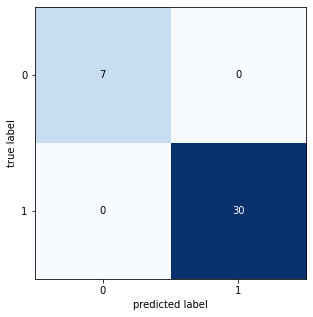

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

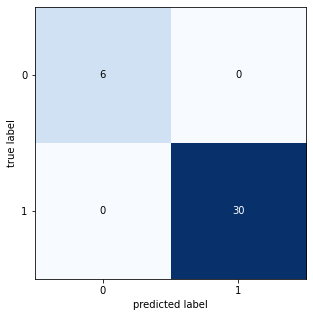

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

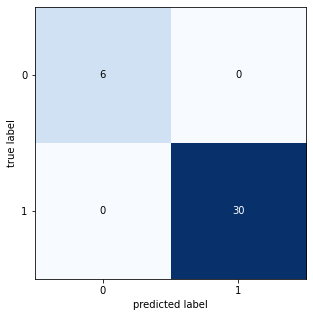

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

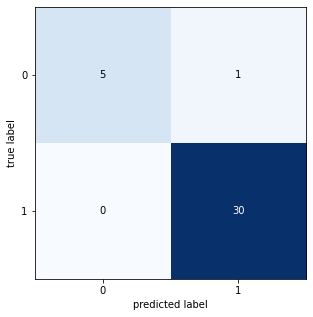

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

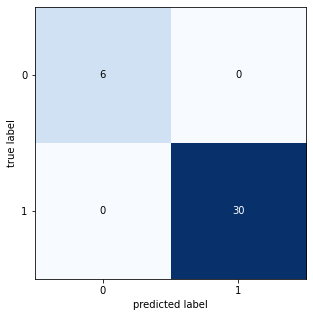

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.47408864699901
gene : [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

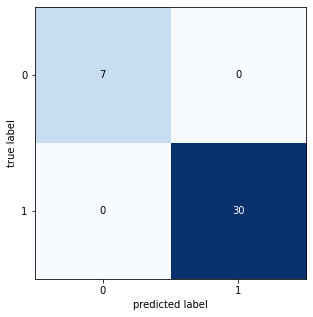

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

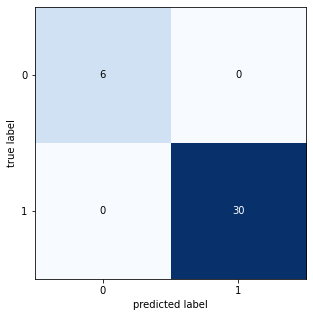

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

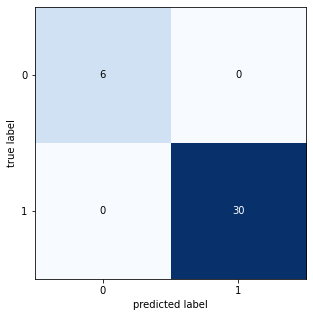

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

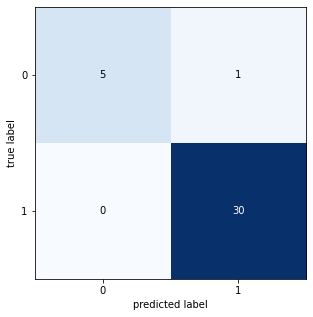

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

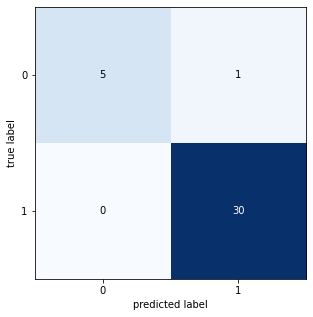

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9785394932935916
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.57987068500006
gene : [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

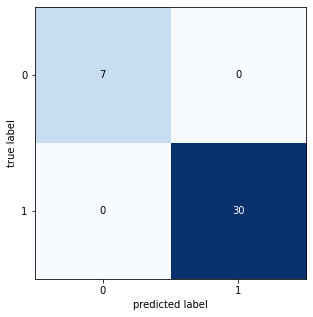

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

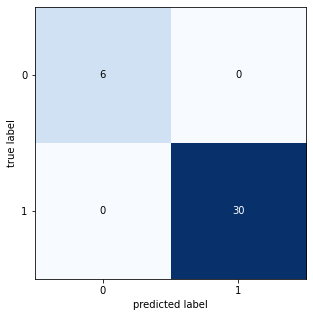

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

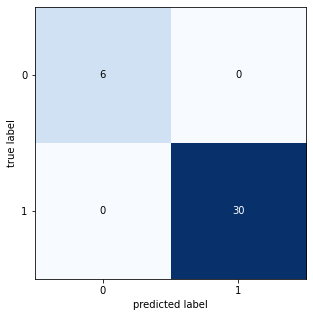

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

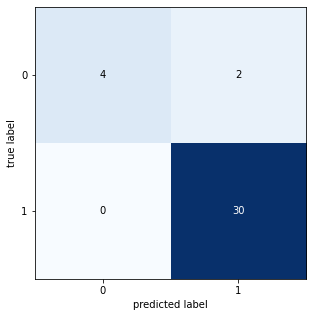

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

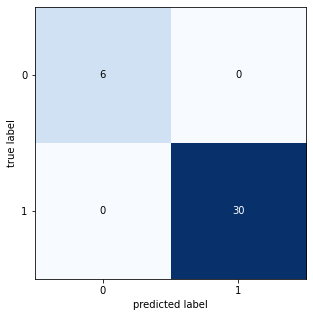

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.02990230599971
gene : [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

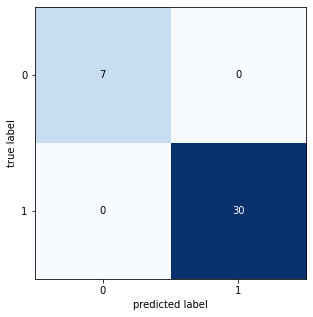

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

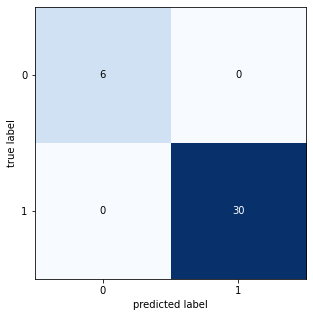

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

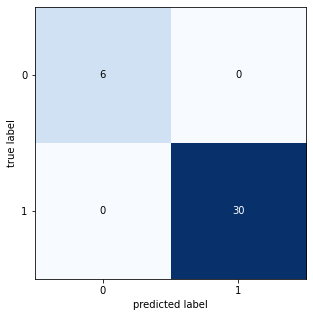

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

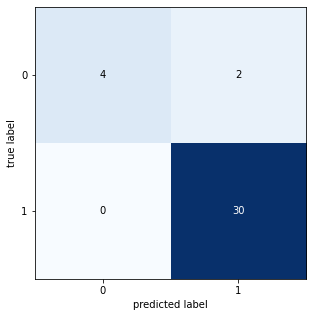

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

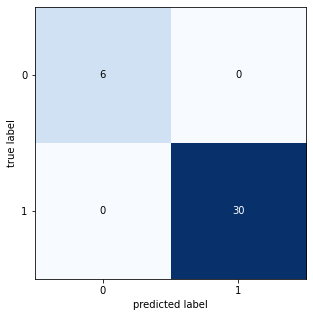

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.74232730099902
gene : [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

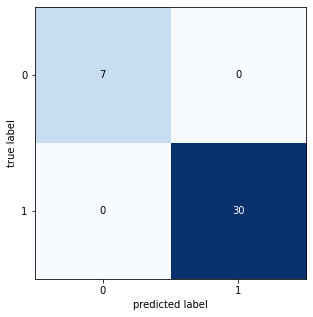

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

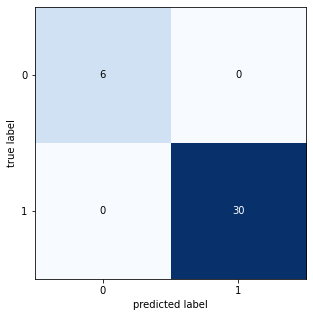

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

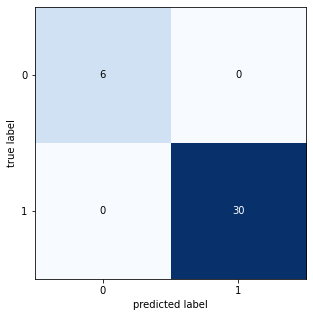

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

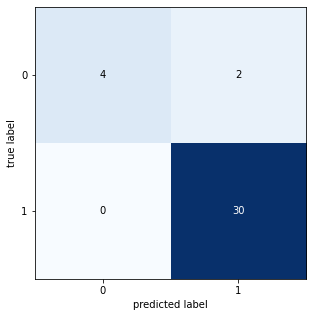

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

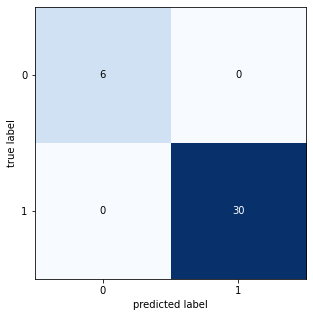

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.527041717999964
gene : [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

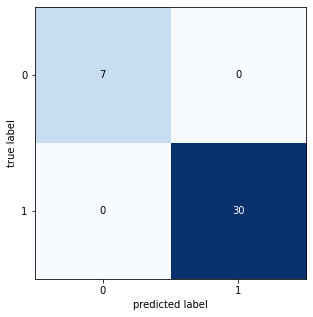

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

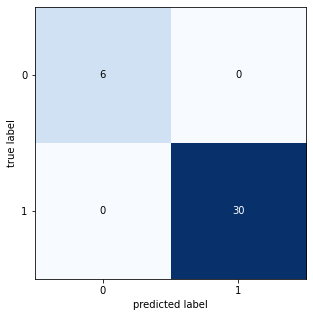

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

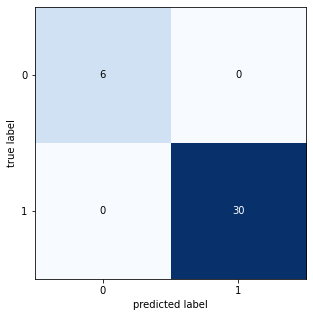

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

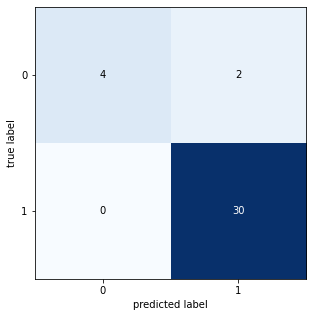

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

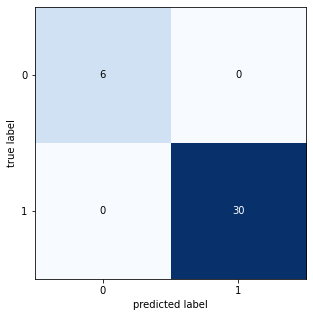

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.595665688000736
gen terbaik : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 49

Generation : 1
gene : [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

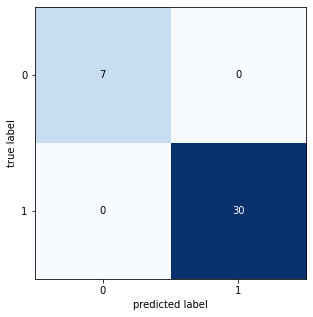

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

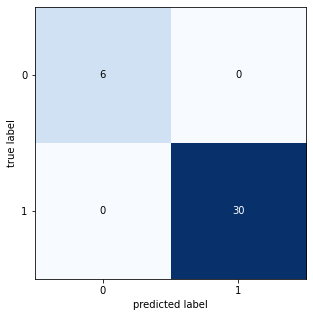

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

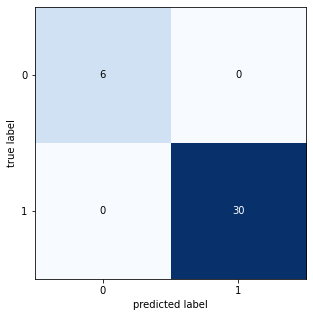

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

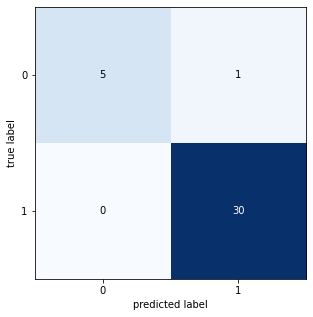

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

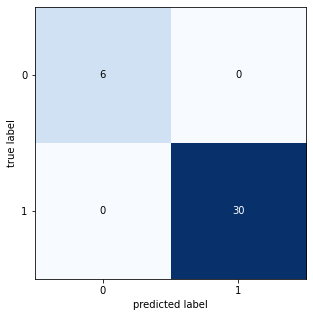

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.244910983998125
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

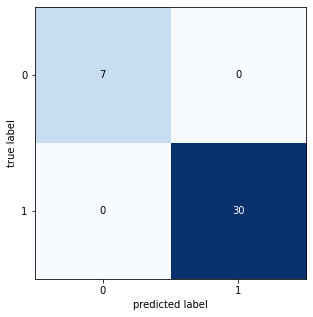

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

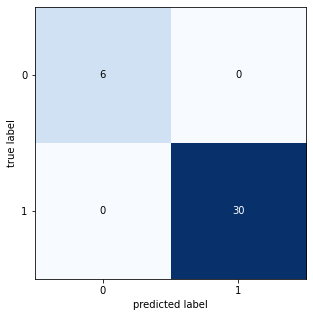

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

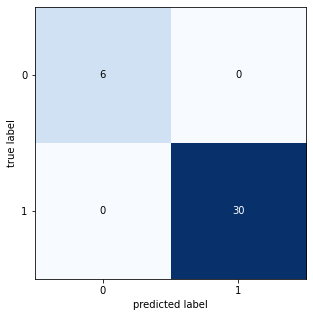

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

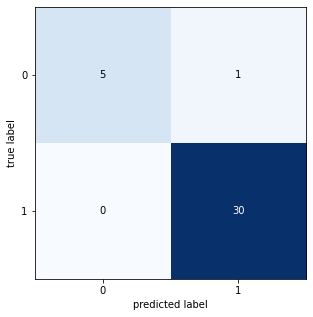

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

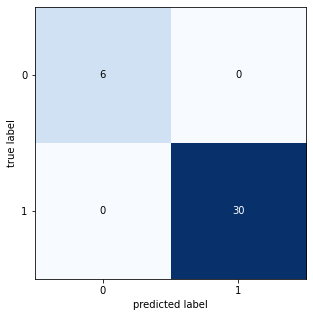

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.30038856600004
gene : [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

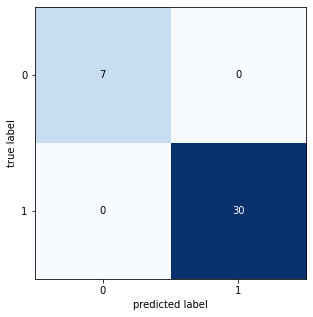

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

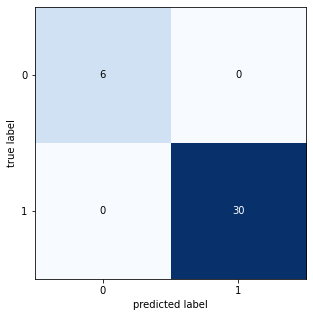

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

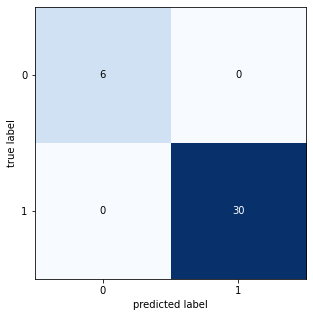

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

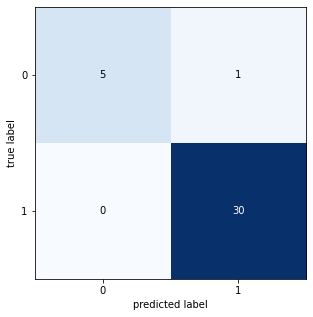

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

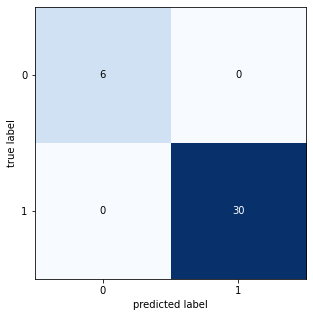

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.54157761299939
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

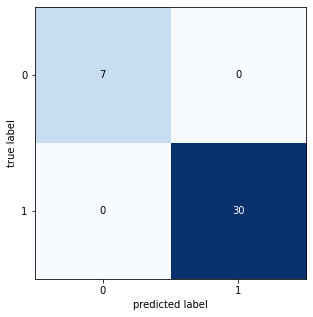

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

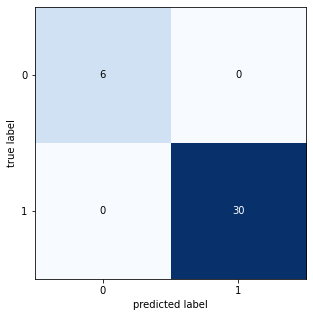

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

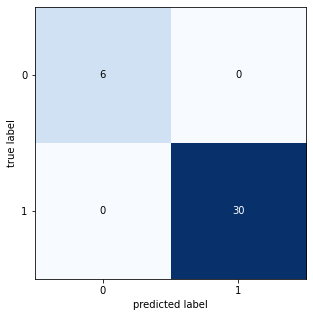

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

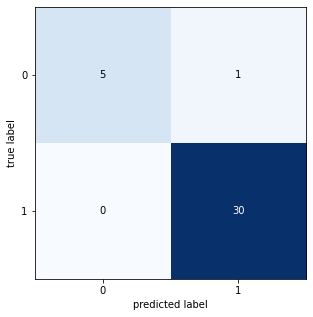

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

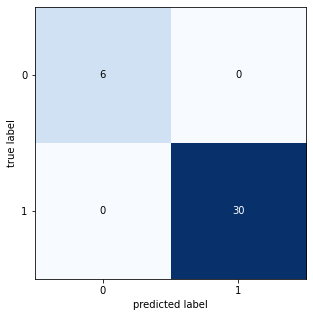

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.555203432999406
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

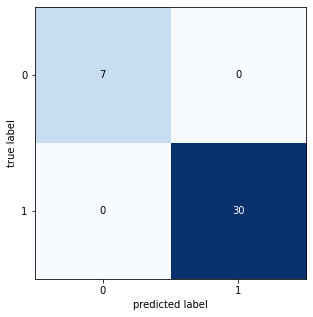

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

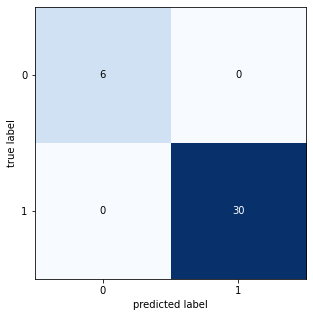

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

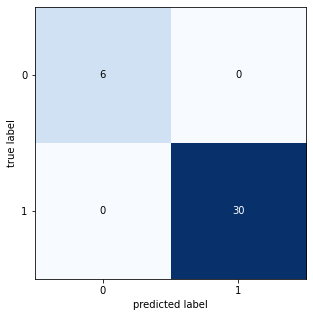

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

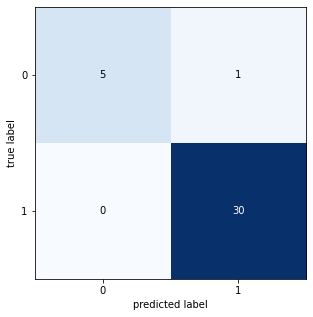

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

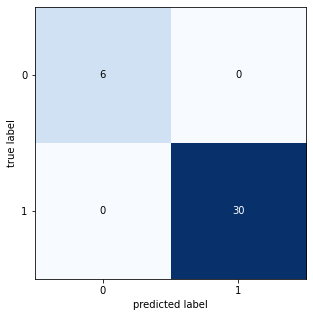

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.31215050800165
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

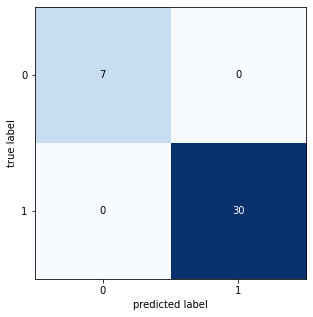

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

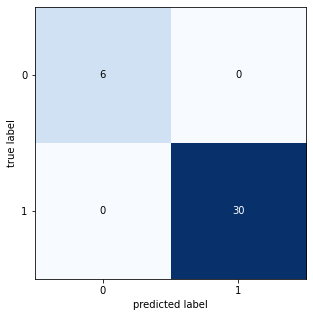

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

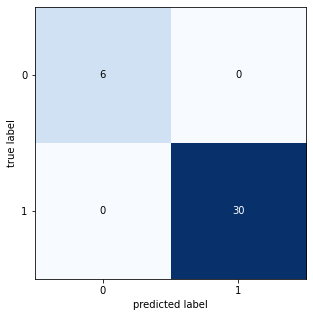

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

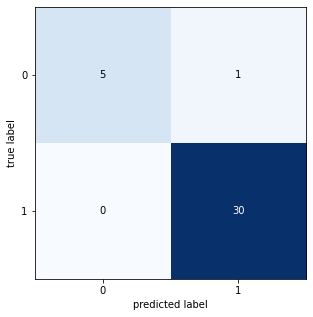

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

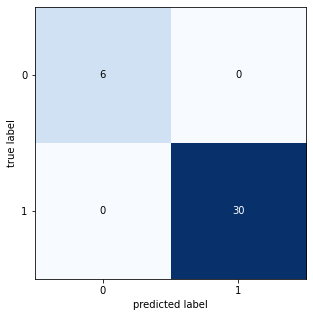

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.64678050200018
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

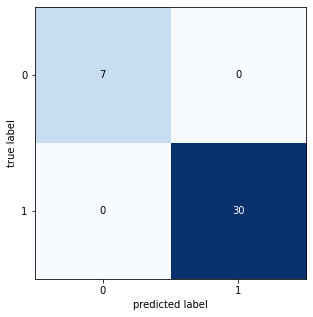

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

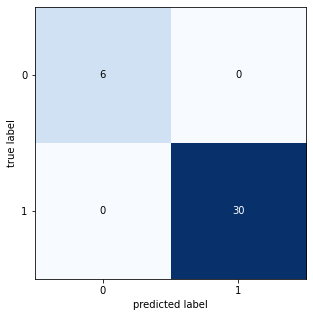

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

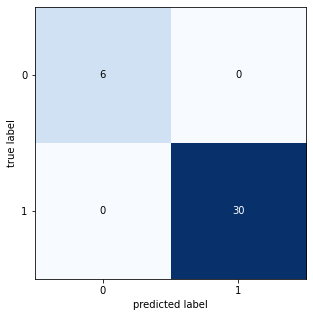

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

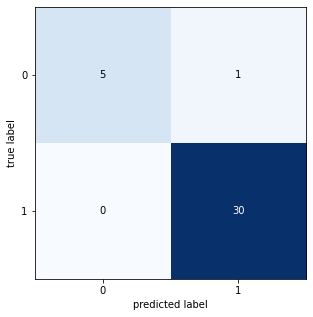

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

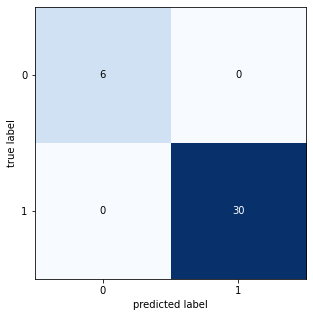

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.66085005899731
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

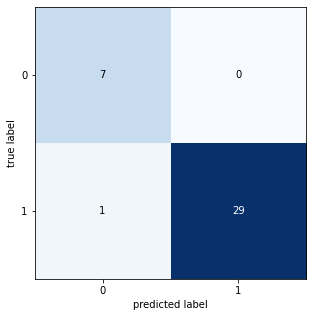

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

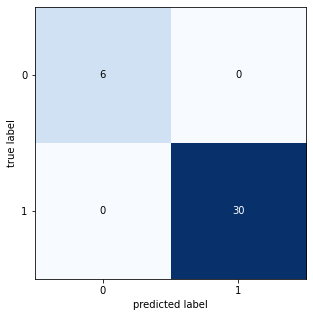

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

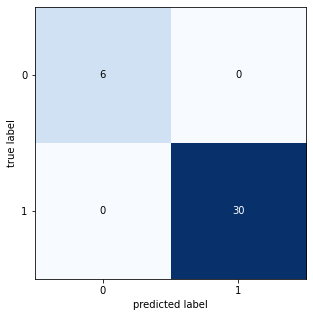

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

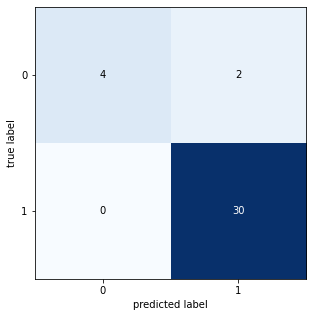

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

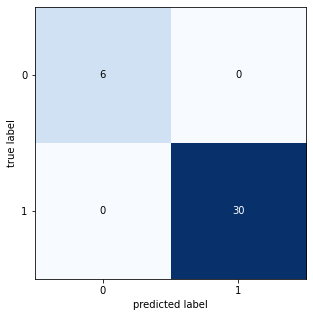

avg accuraccy Lung Cancer =  0.9834834834834835
avg F1_Score Lung Cancer =  0.968412611627483
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.36937659100295
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

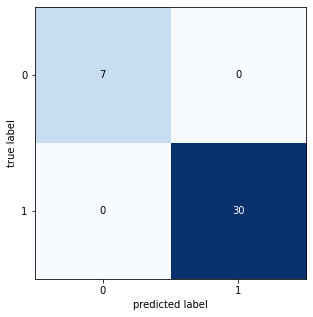

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

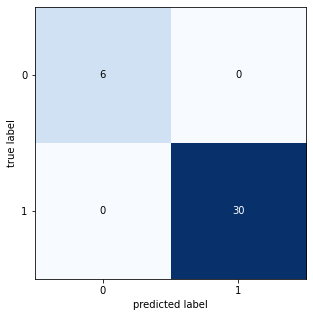

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

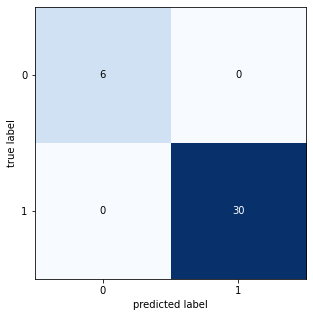

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

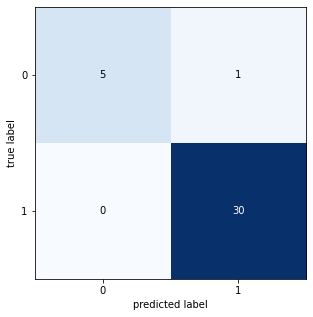

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

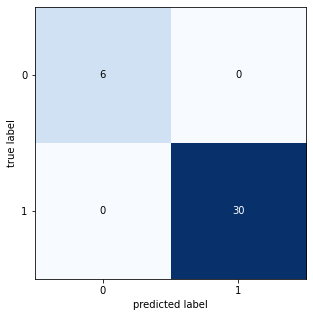

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.029589981000754
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

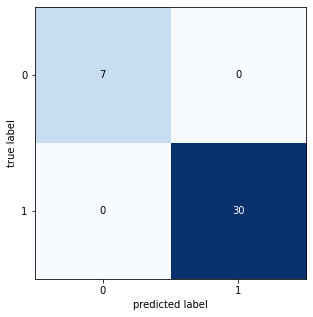

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

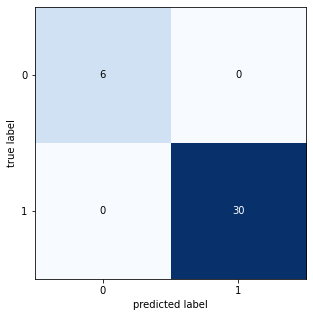

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

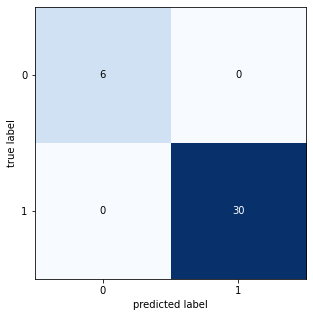

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

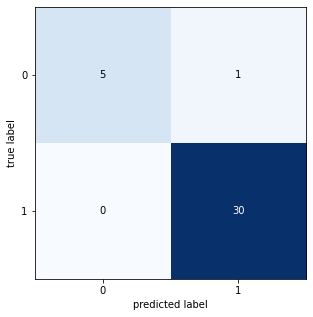

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

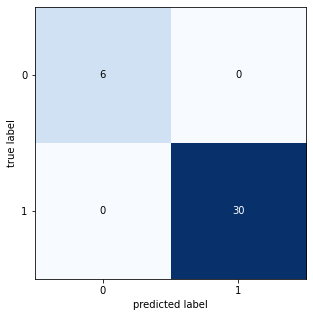

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.80405055499796
gen terbaik : [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 52

Generation : 2
gene : [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1

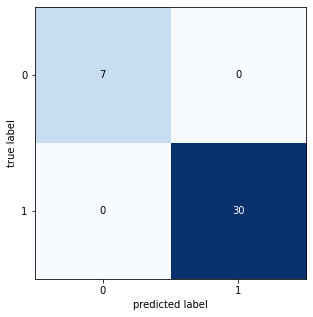

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

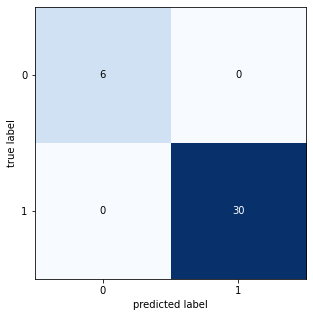

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

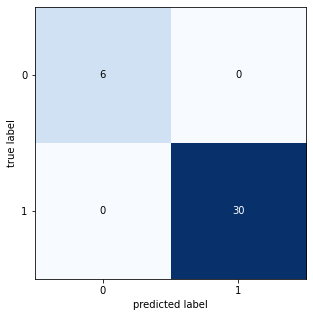

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

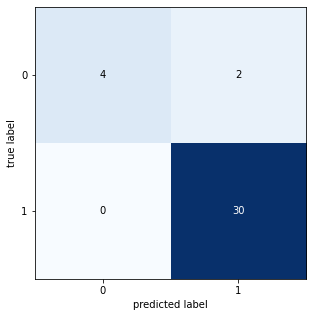

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

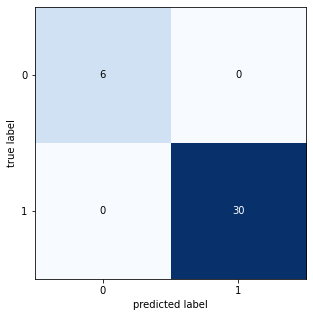

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  45.60616139500053
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

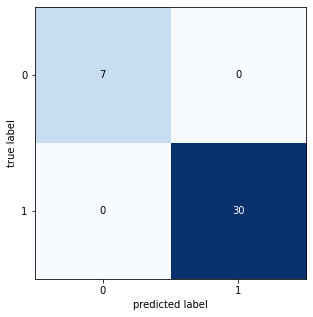

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

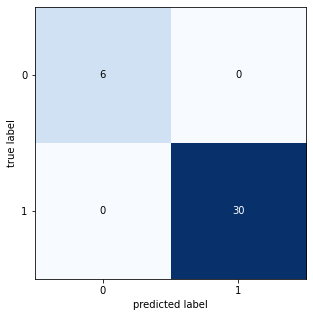

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

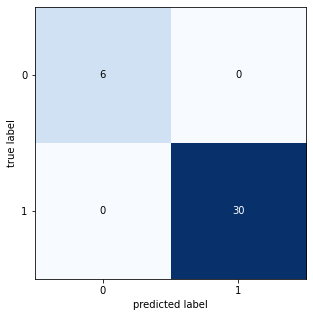

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

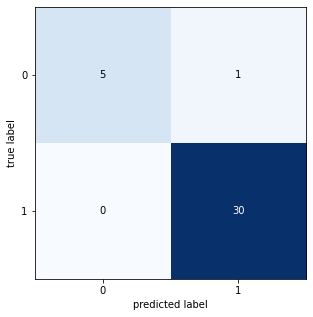

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

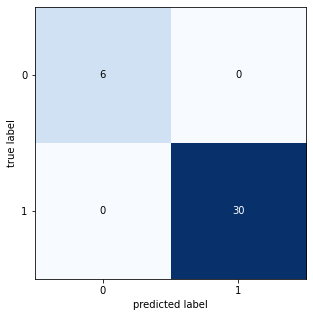

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  45.71647246700013
gene : [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

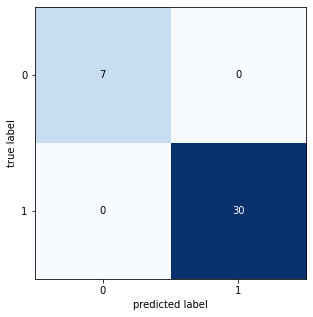

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

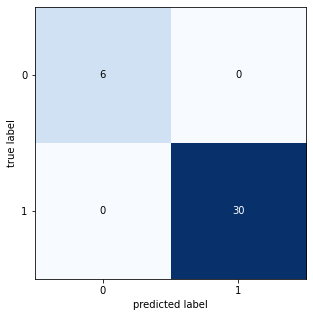

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

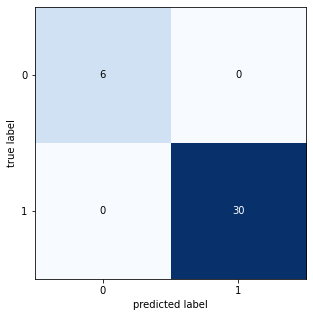

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

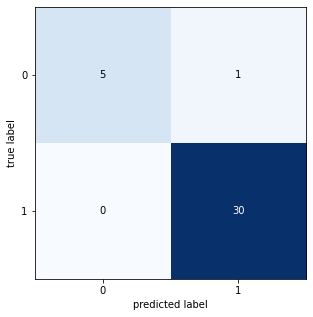

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

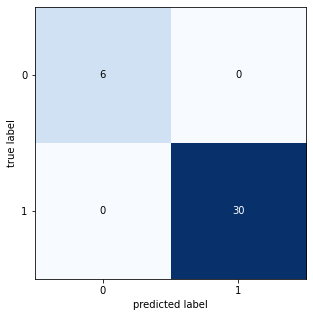

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  43.33379453899761
gene : [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

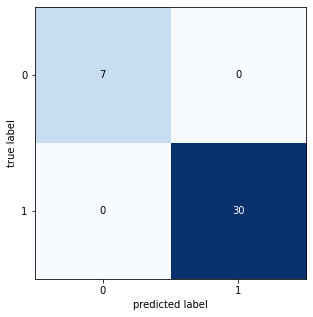

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

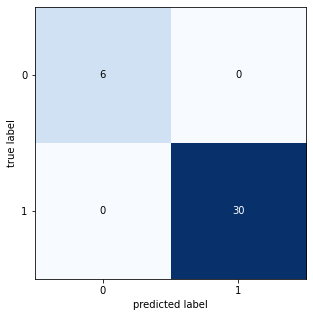

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

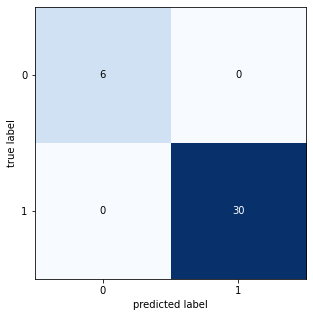

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

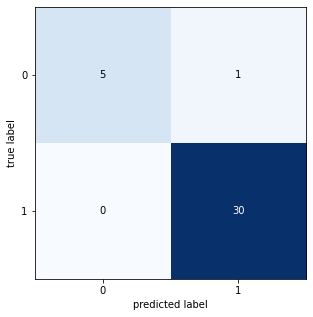

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

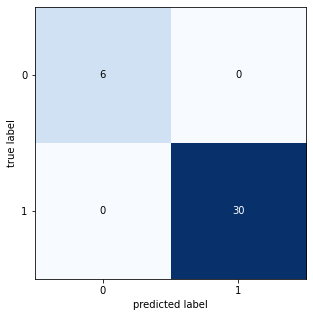

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.42058290799832
gene : [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

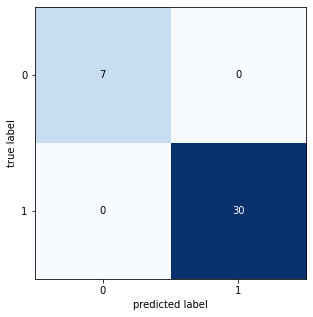

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

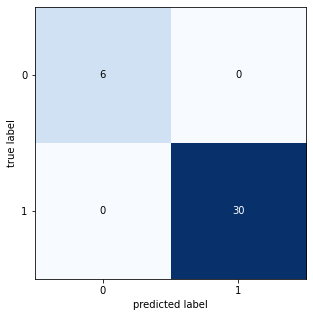

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

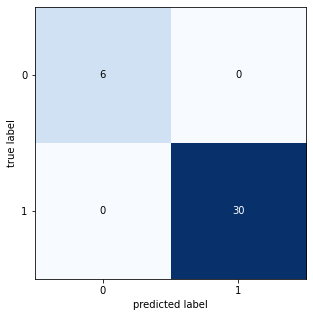

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

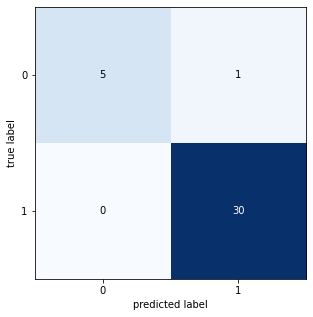

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

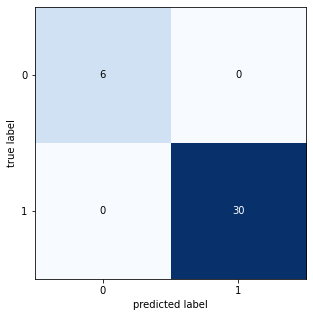

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.69779770899913
gene : [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

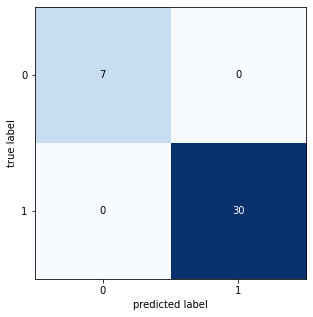

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

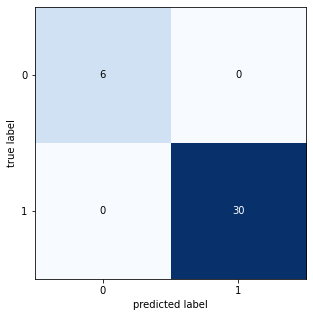

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

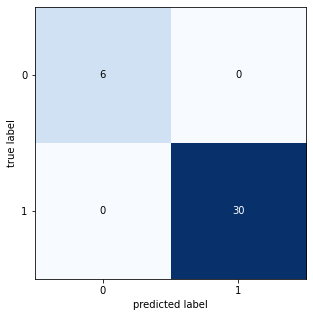

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

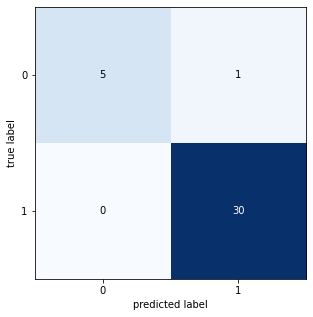

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

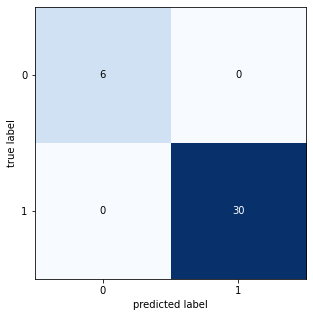

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.40979525600051
gene : [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

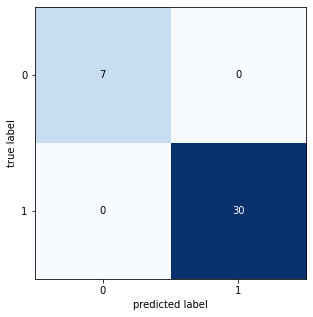

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

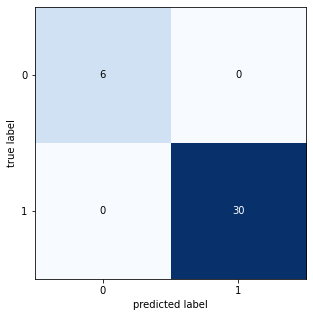

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

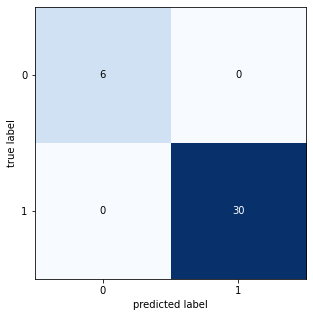

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

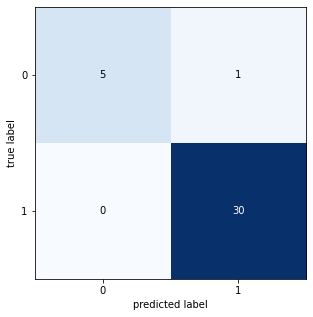

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

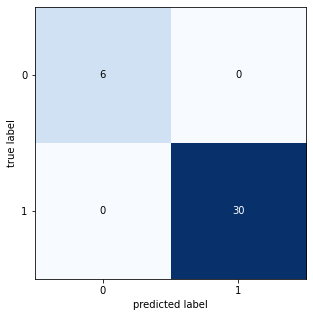

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.95331212699966
gene : [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

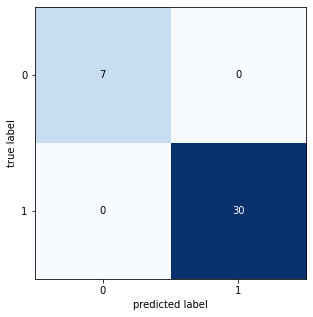

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

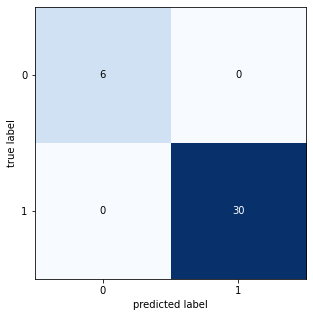

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

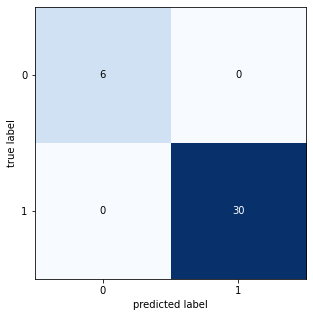

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

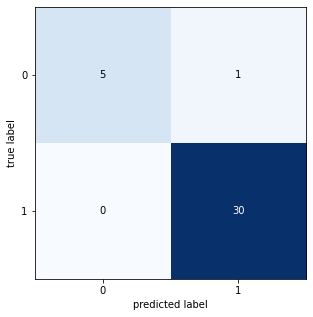

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

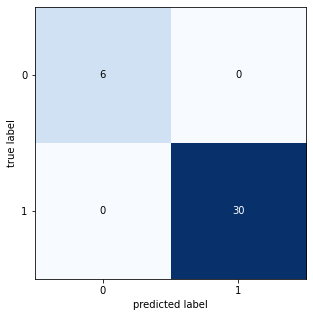

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.58071523699982
gene : [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

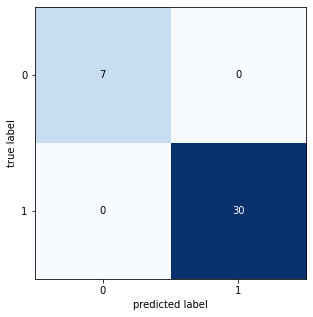

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

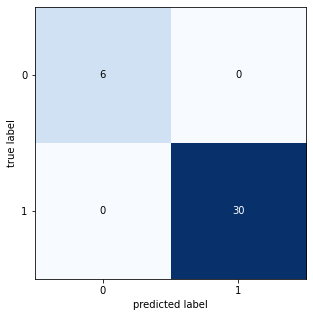

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

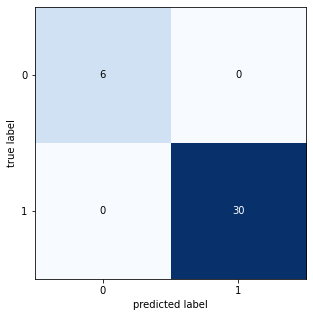

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

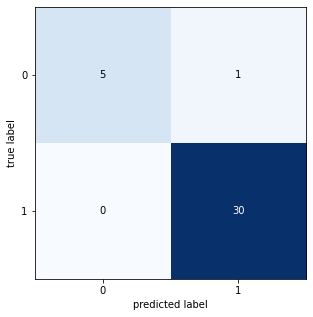

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

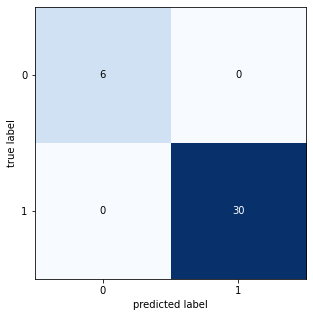

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  37.246613038998476
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

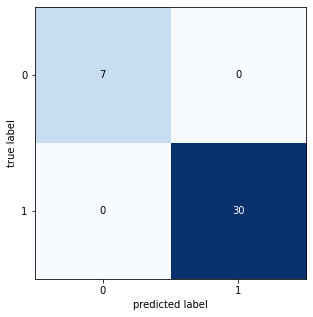

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

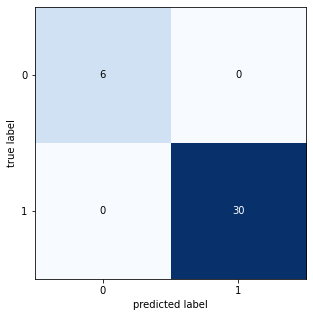

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

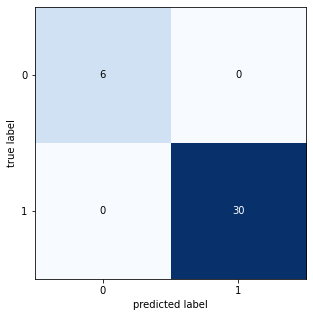

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

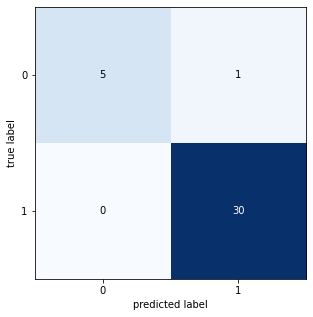

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

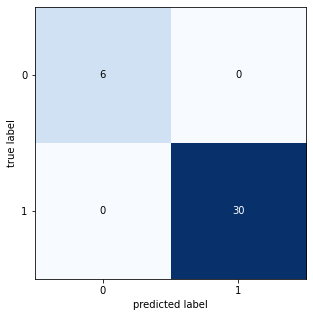

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.735224121999636
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 44

Generation : 3
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 

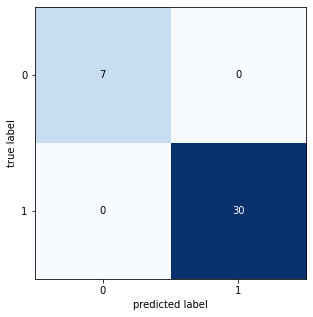

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

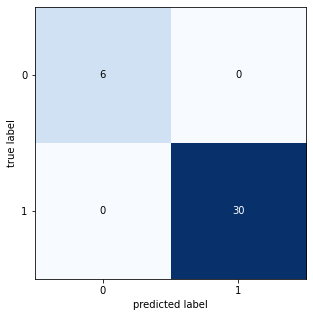

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

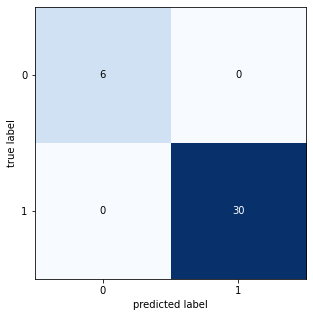

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

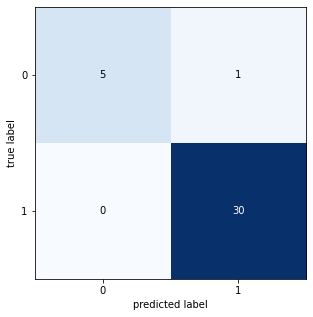

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

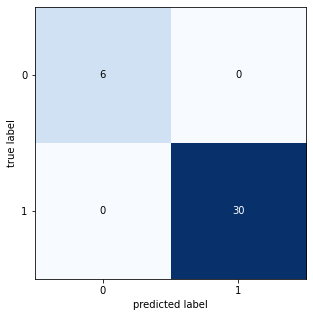

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.066655392998655
gene : [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

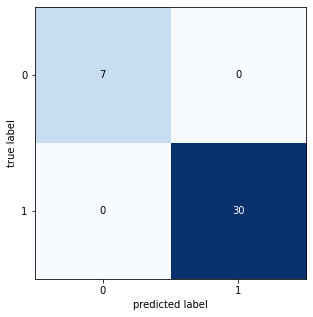

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

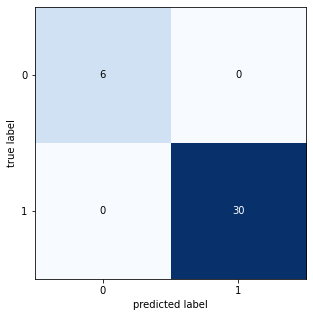

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

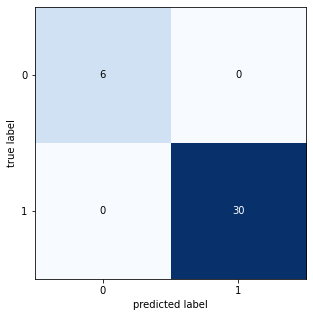

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

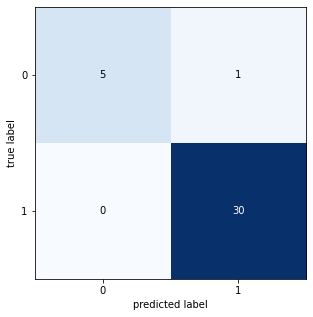

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

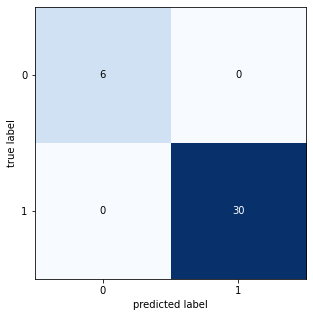

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  37.596050580003066
gene : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

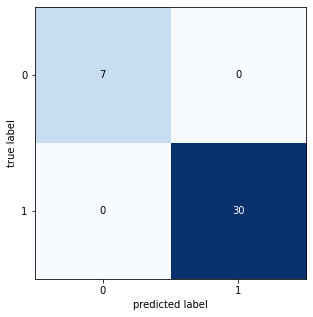

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

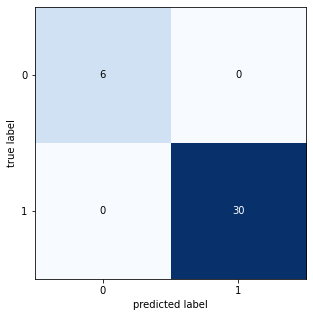

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

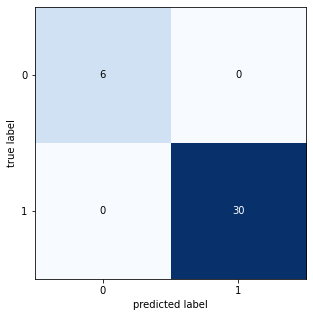

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

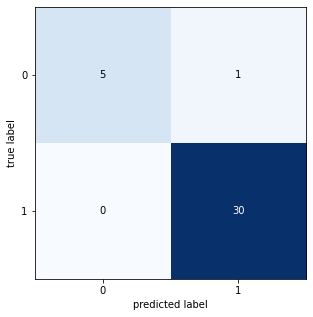

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

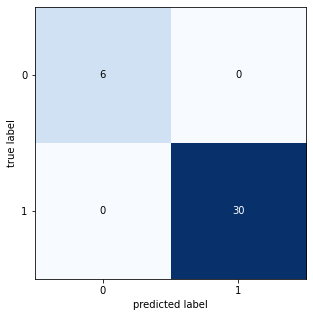

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  37.57695352000155
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

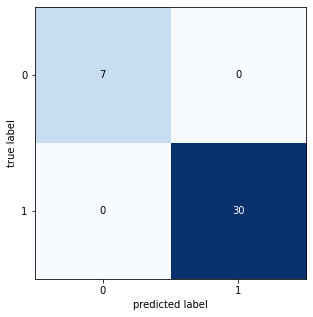

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

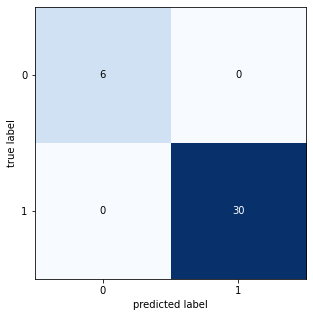

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

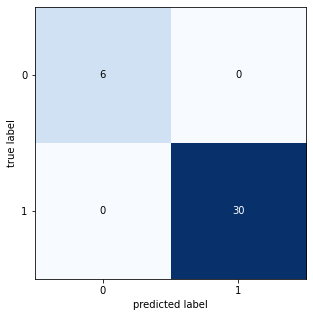

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

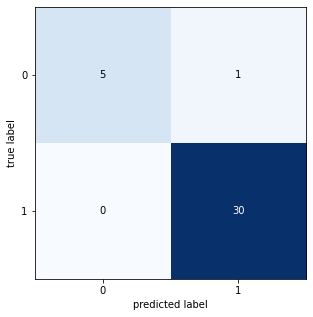

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

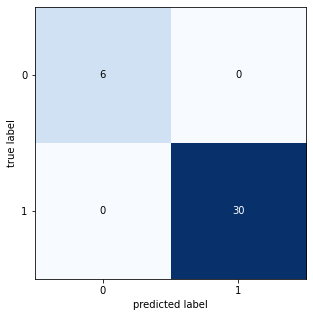

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.220381445000385
gene : [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

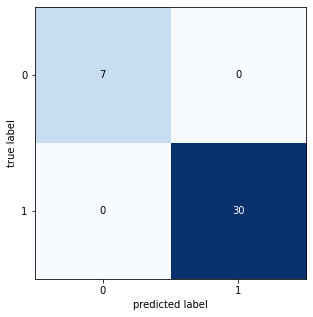

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

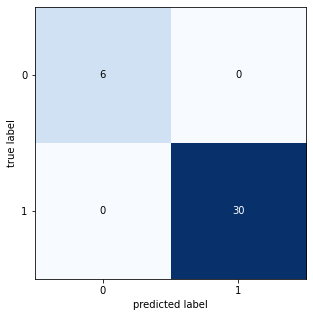

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

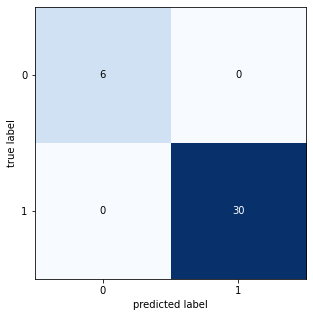

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

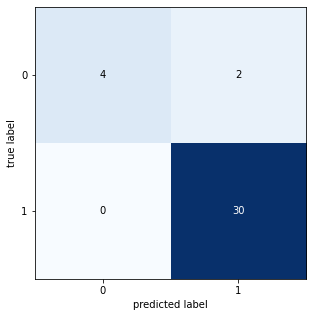

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

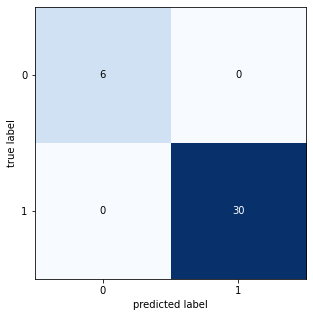

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  37.5526108640006
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

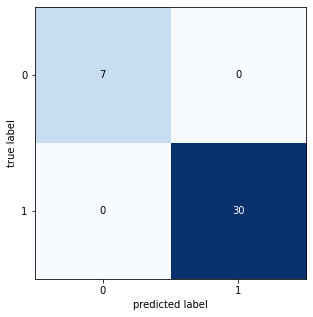

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

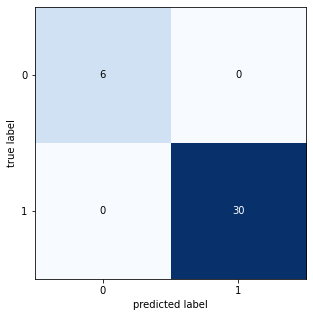

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

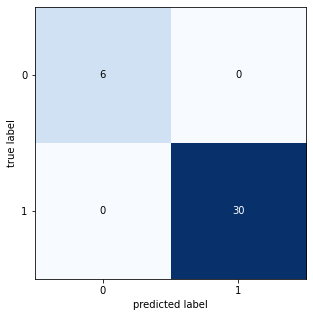

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

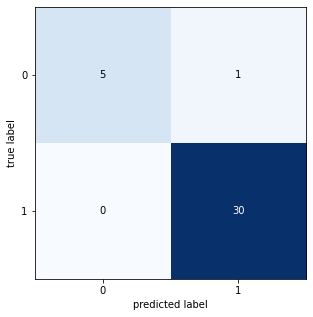

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

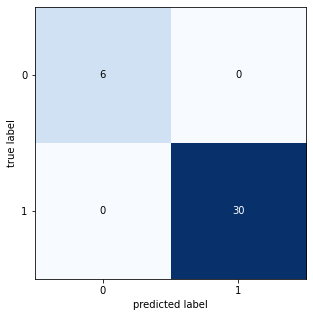

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.067827869999746
gene : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

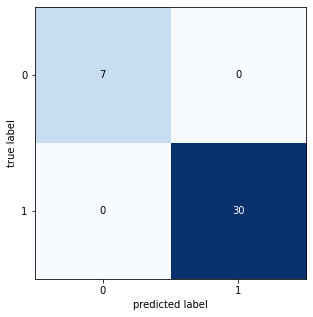

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

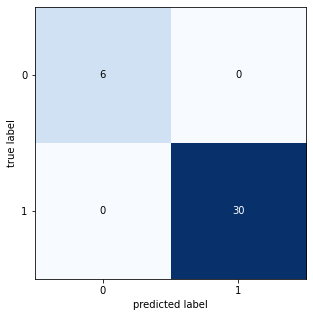

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

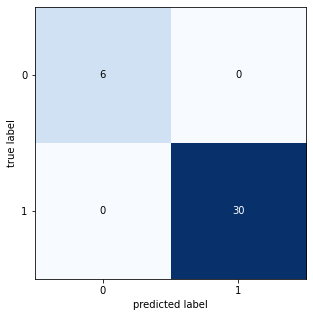

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

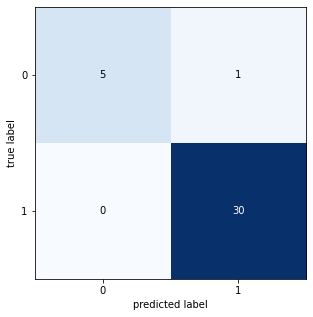

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

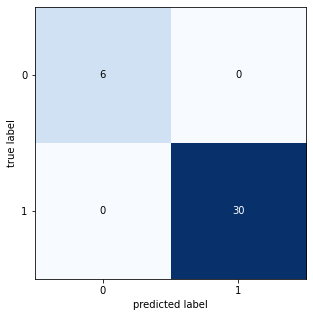

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.908416717000364
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

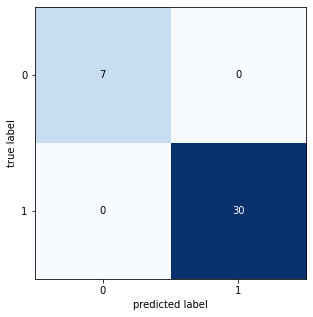

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

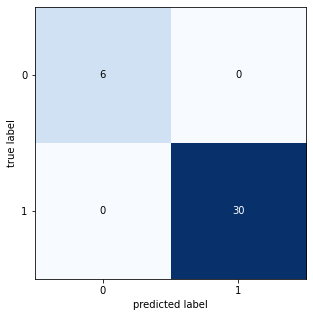

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

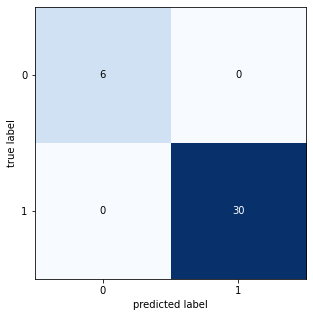

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

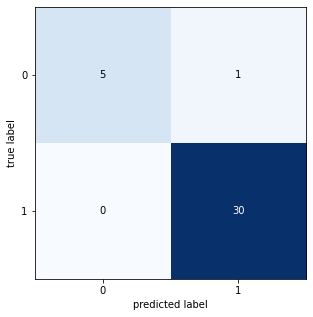

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

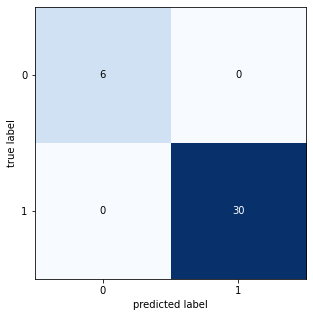

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.62762281899995
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

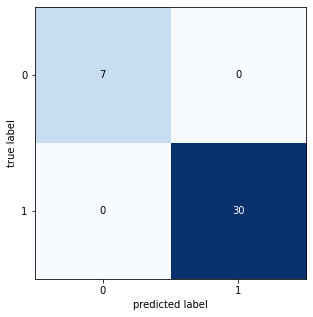

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

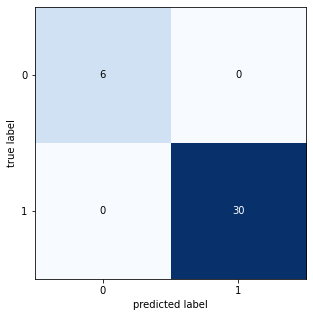

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

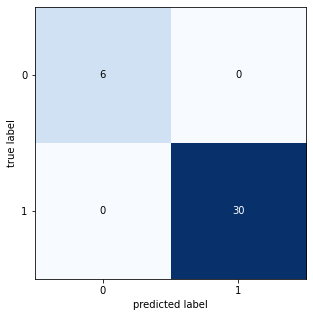

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

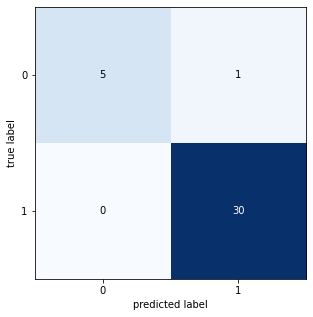

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

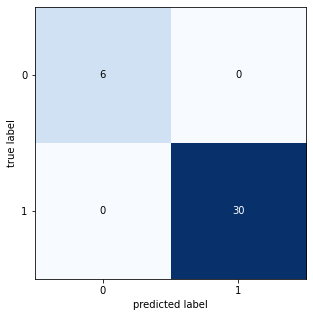

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.24843472900102
gene : [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

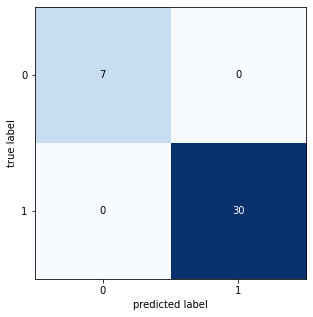

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

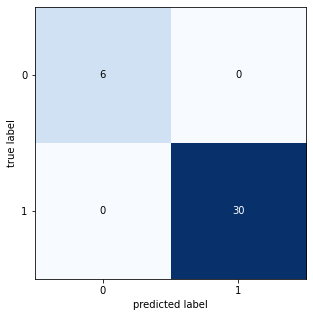

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

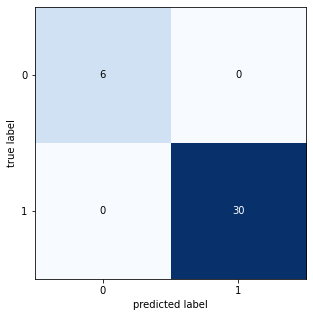

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

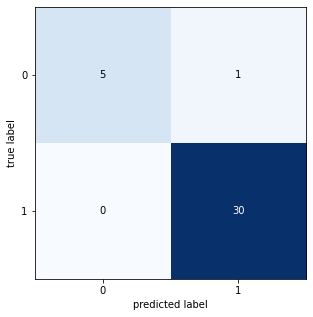

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

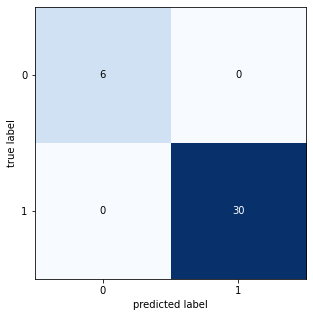

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.057729483
gen terbaik : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 53

Generation : 4
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 

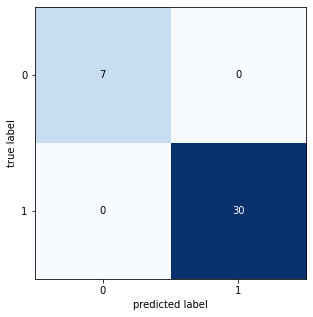

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

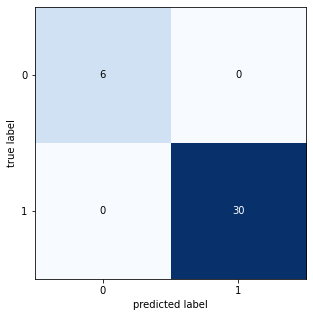

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

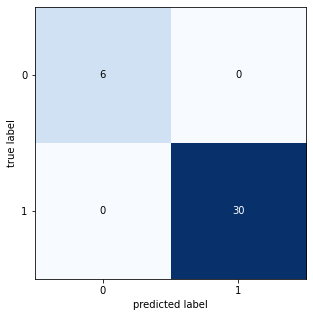

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

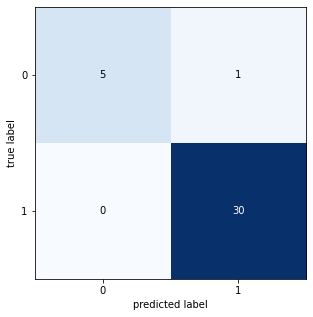

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

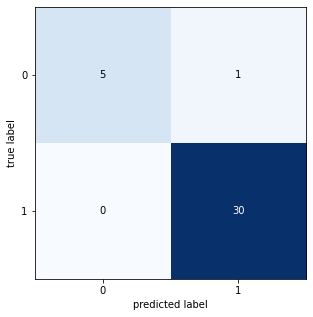

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9785394932935916
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.07858817700253
gene : [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

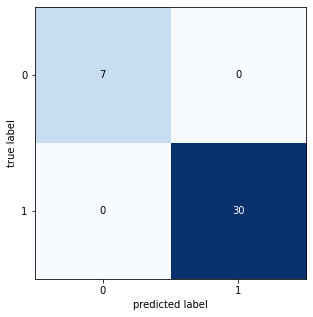

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

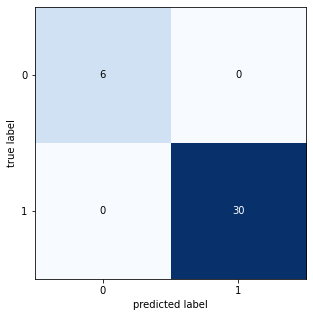

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

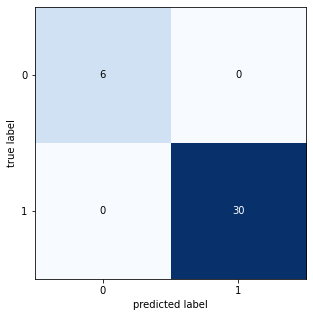

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

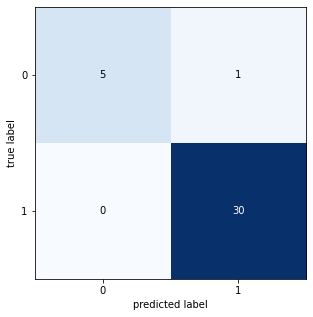

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

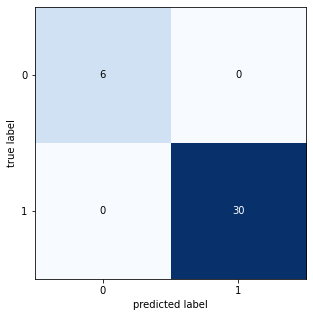

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  37.95037296599912
gene : [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

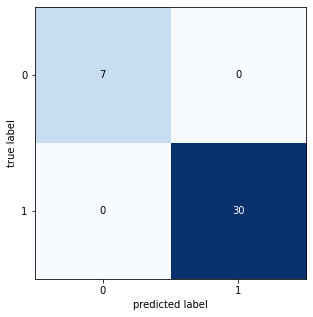

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

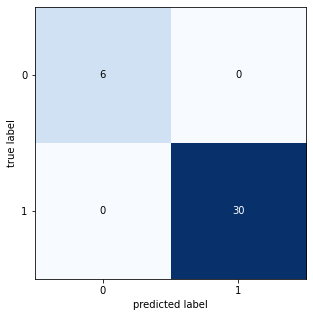

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

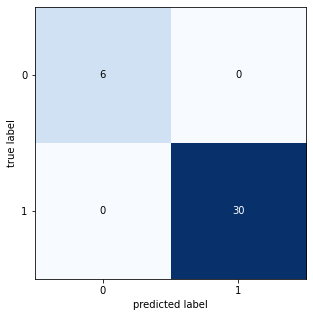

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

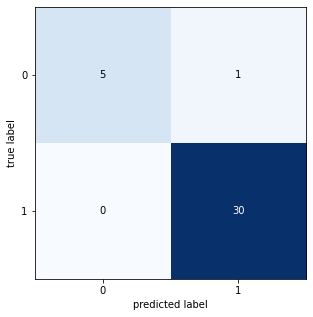

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

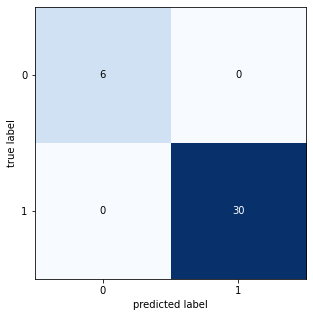

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.39573207599824
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

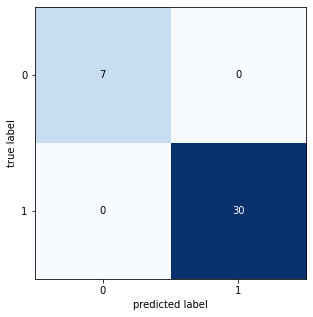

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

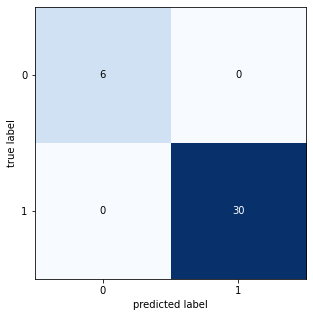

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

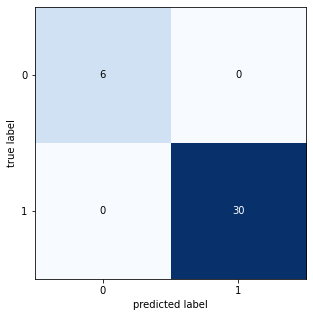

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

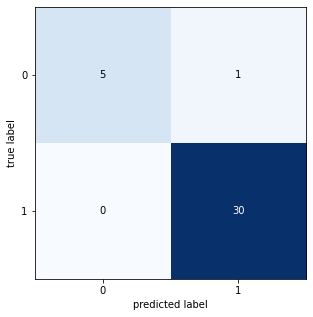

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

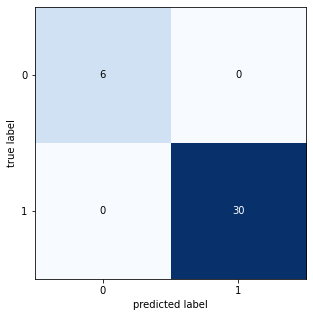

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.40521967099994
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

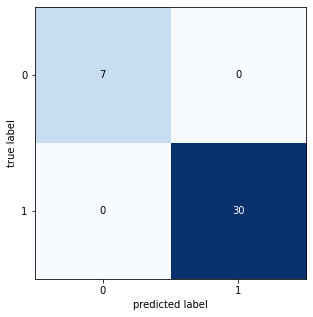

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

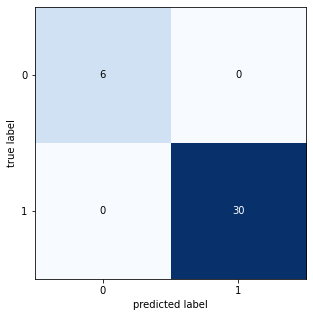

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

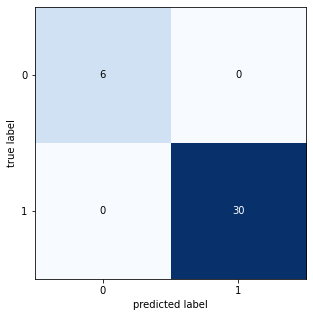

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

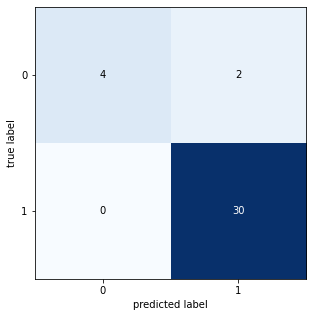

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

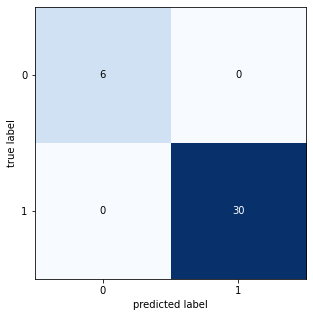

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  37.224483445999795
gene : [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

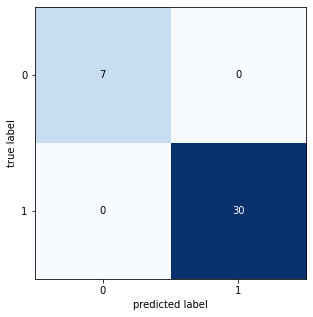

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

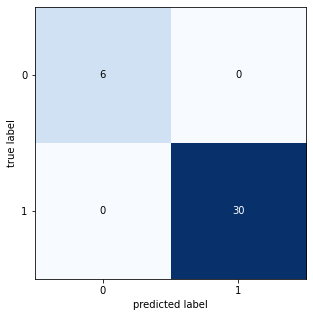

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

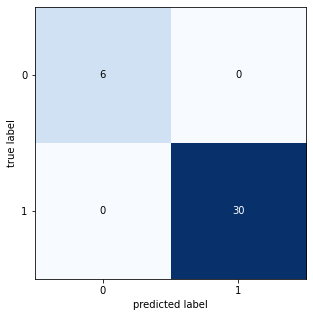

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

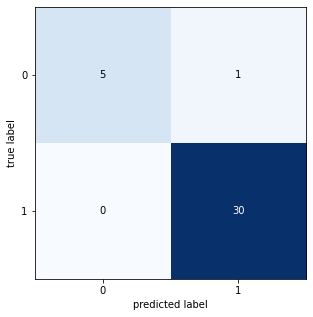

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

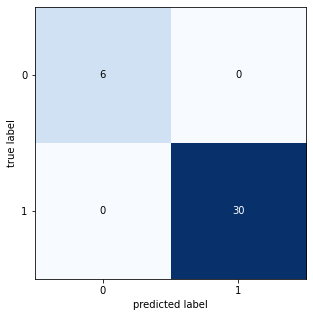

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.28132181500041
gene : [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

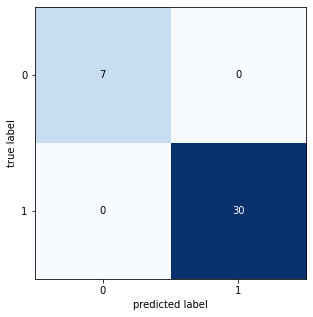

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

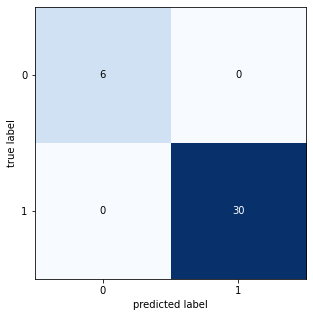

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

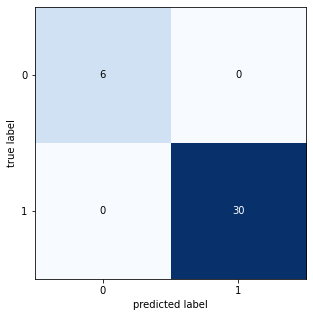

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

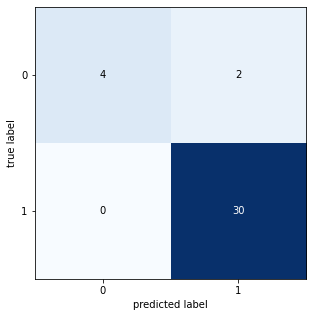

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

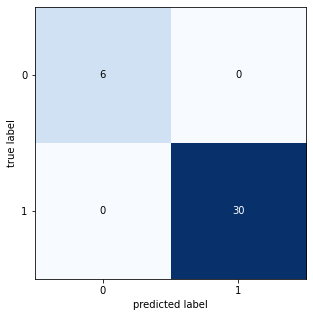

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  39.01210063799954
gene : [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

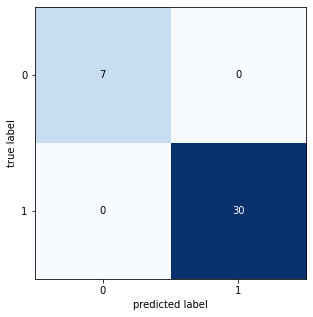

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

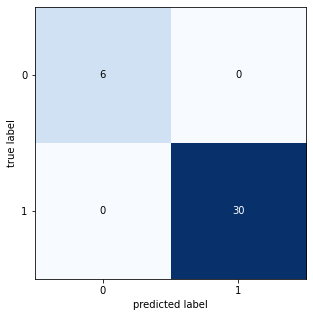

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

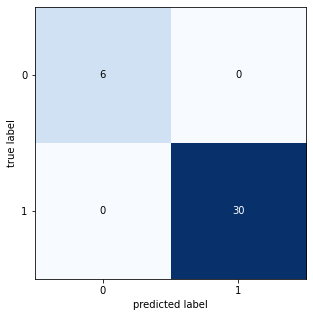

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

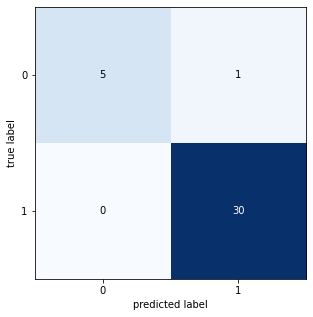

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

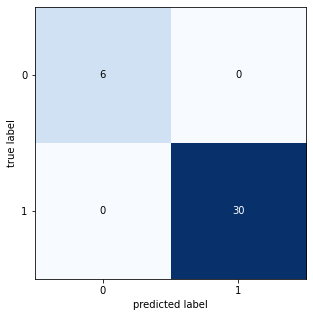

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.128808755001955
gene : [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

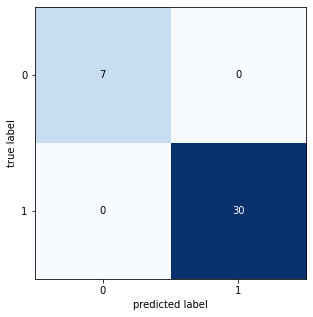

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

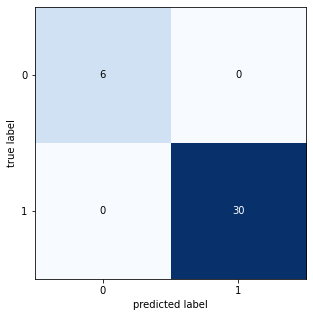

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

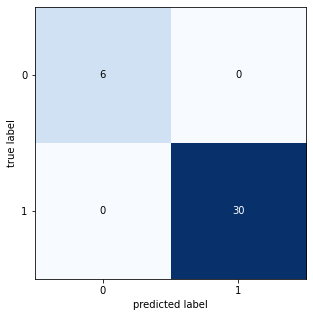

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

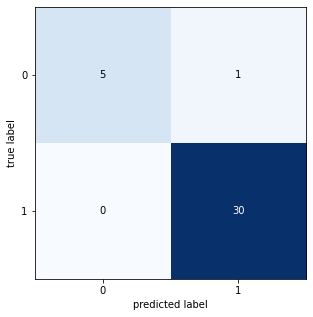

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

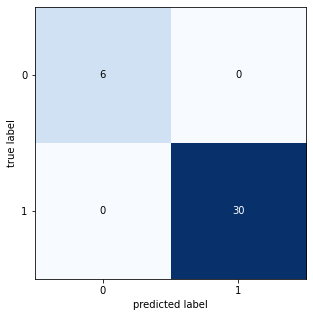

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.87078728599954
gene : [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

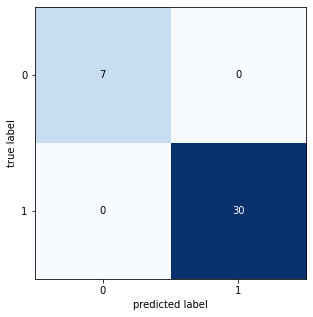

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

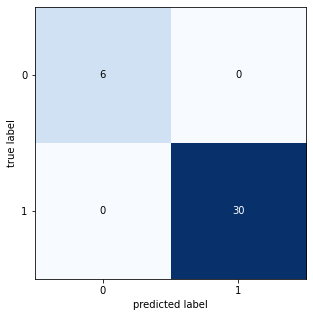

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

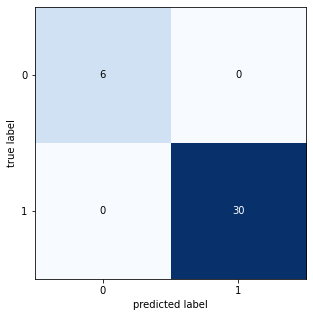

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

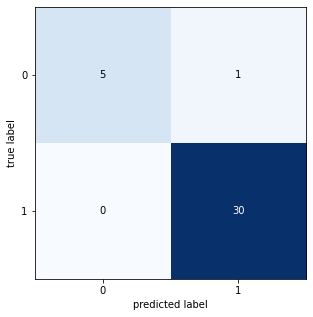

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

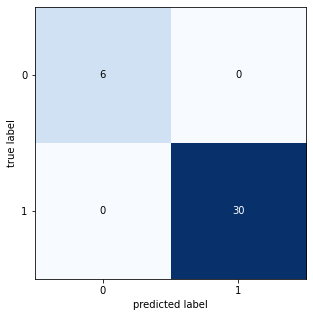

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.169232144999114
gen terbaik : [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 57

Running Time:  2120.527497334002


In [13]:
Lung_IG_GA = GeneticAlgorithm(Lung_IG, 2)

Generation : 0
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96

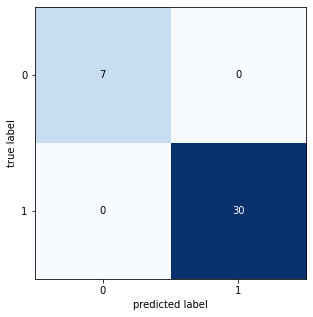

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

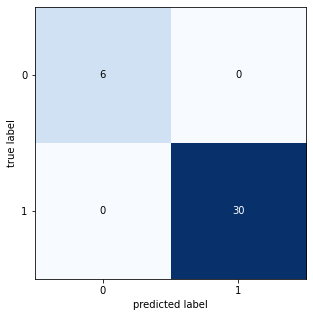

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

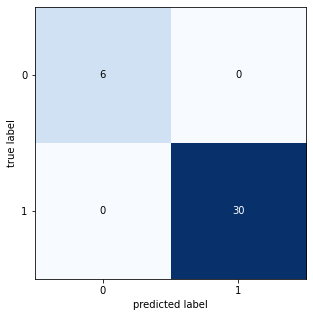

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

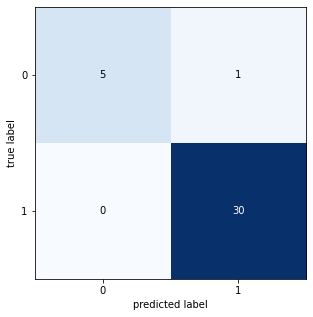

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

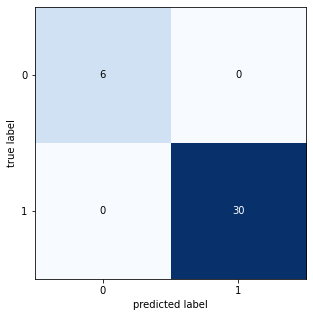

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.41016302500066
gene : [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

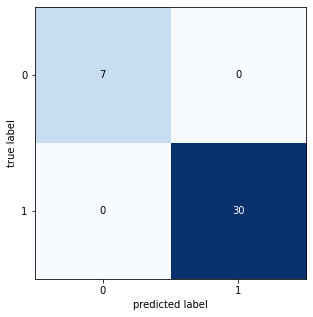

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

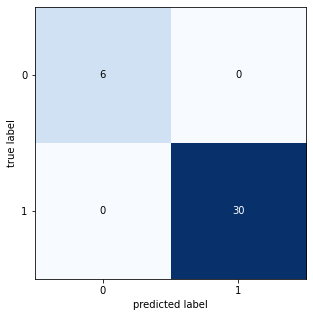

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

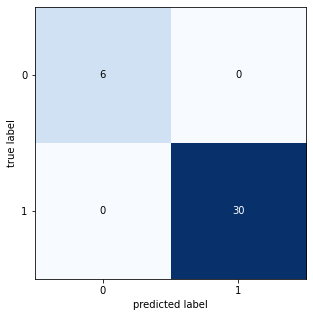

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

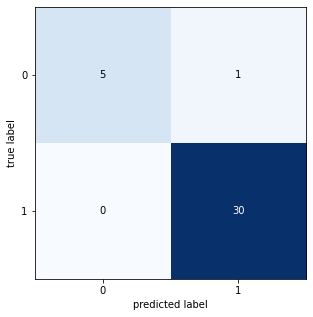

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

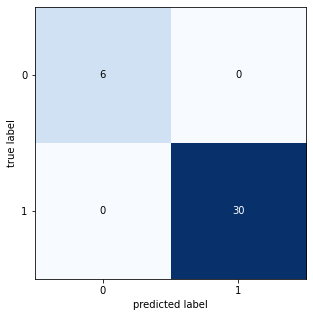

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.043822792002175
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

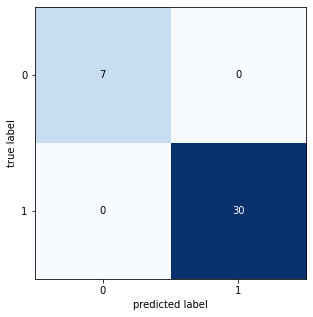

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

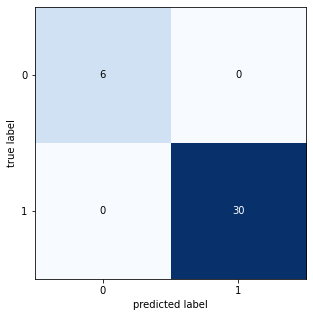

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

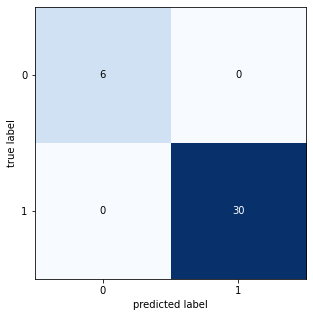

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

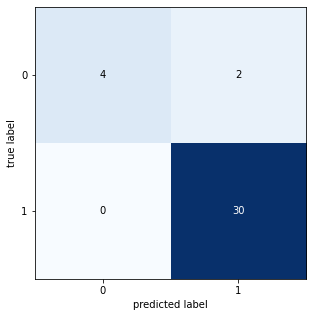

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

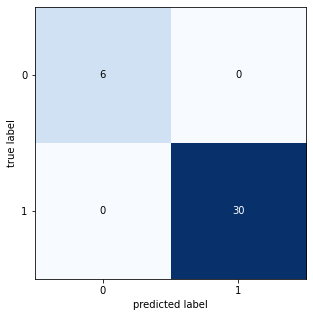

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  40.34027044600225
gene : [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

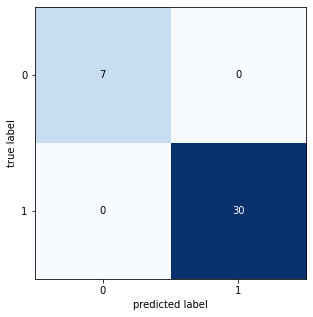

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

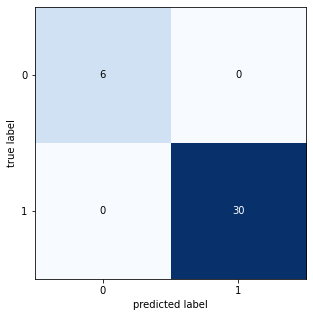

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

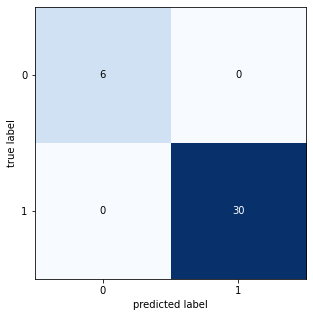

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

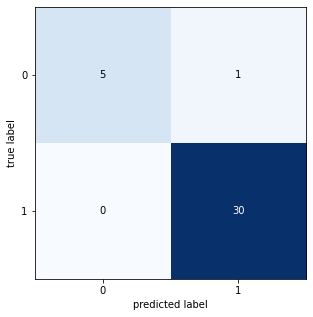

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

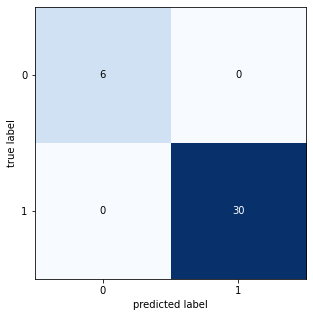

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.2645161319997
gene : [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

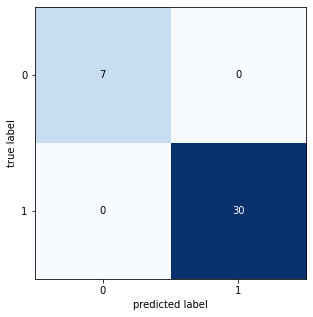

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

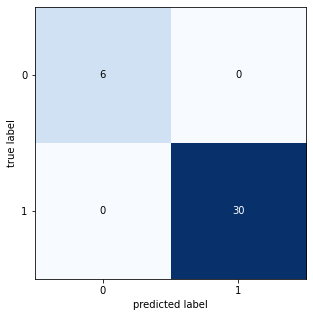

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

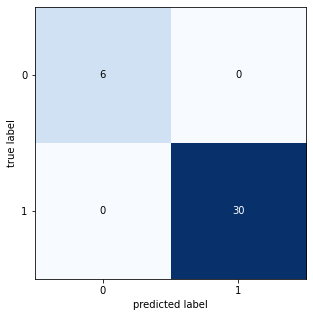

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

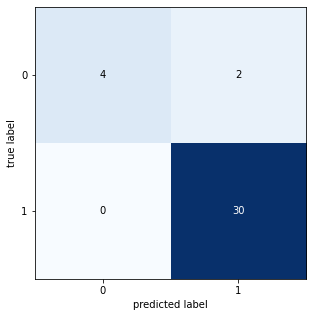

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

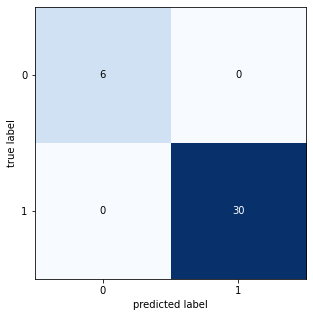

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  39.81519913700322
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

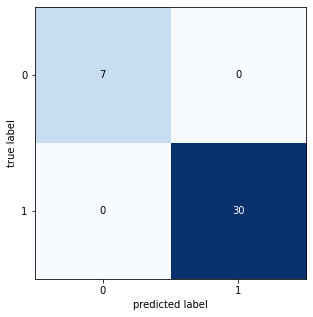

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

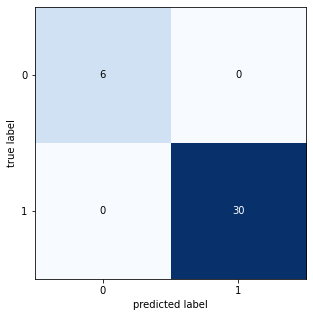

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

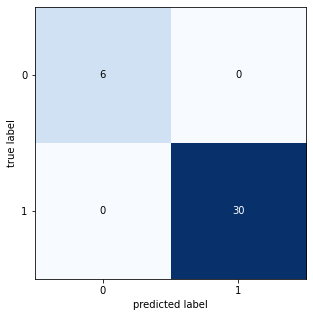

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

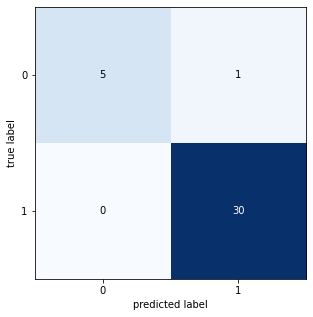

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

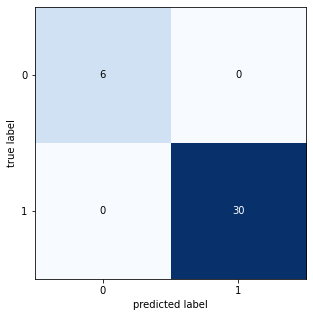

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.12949639400176
gene : [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

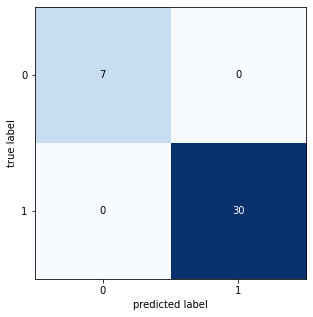

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

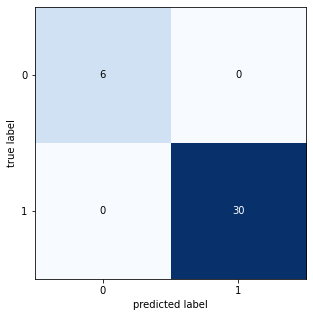

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

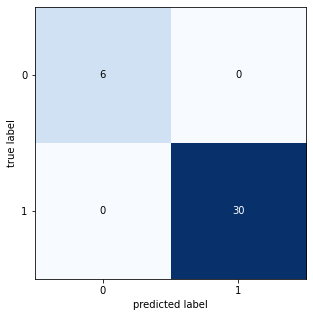

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

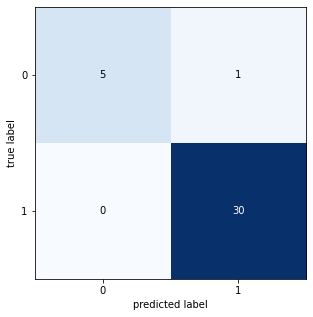

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

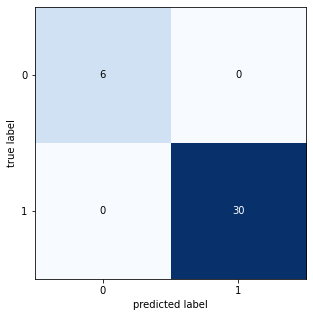

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.792672206000134
gene : [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

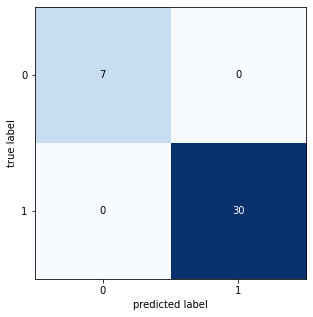

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

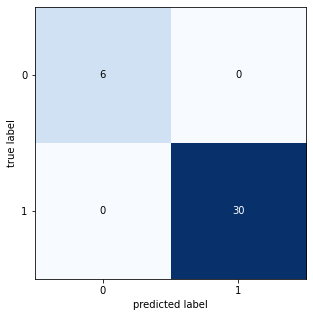

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

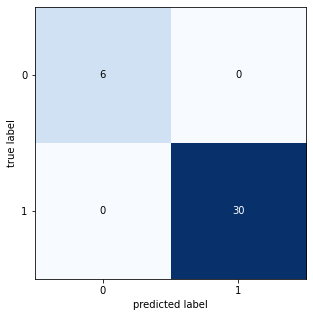

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

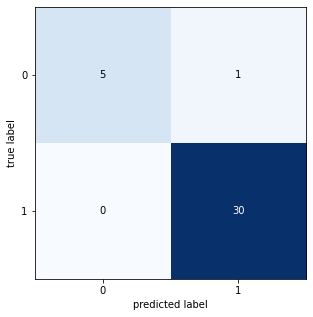

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

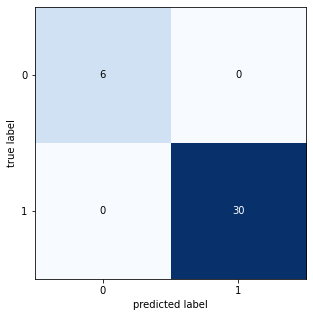

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  43.420993800998986
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

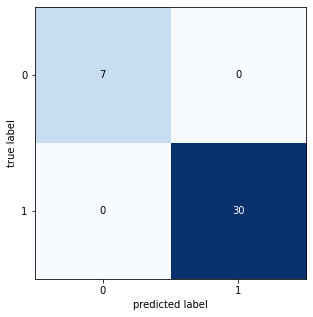

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

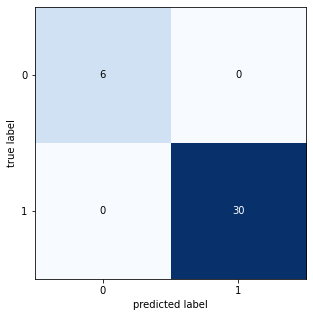

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

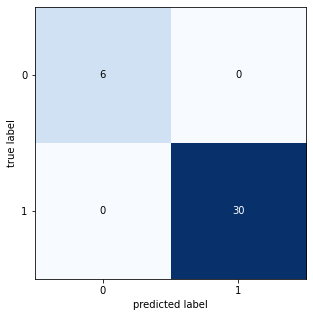

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

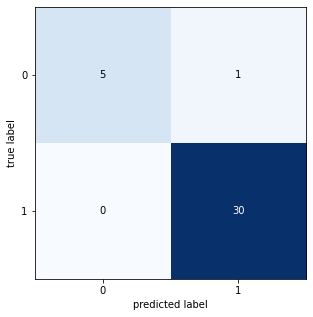

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

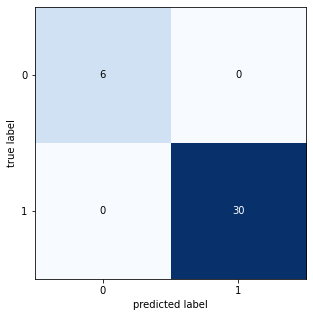

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.46577257899844
gene : [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

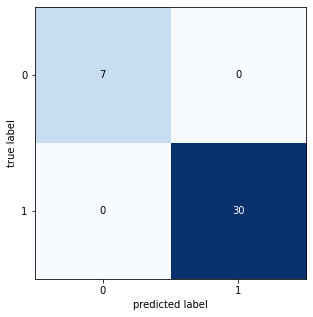

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

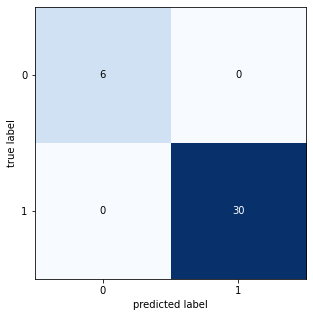

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

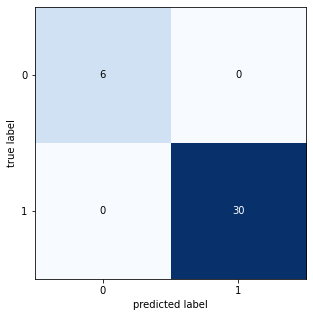

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

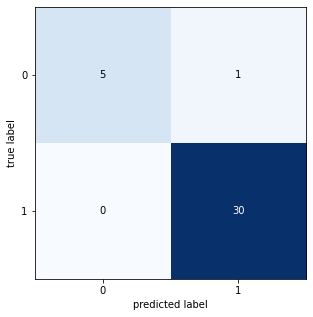

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

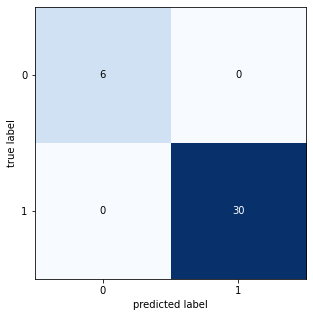

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.45929610700114
gen terbaik : [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 47

Generation : 1
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0

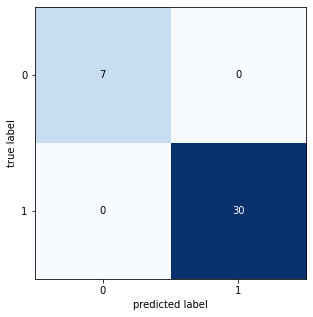

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

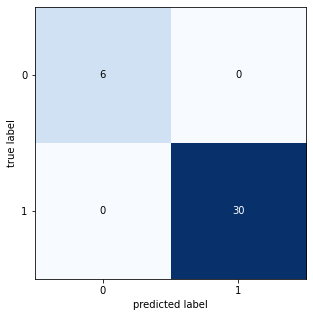

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

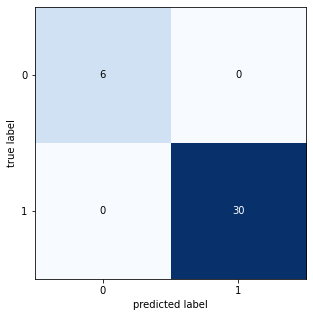

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

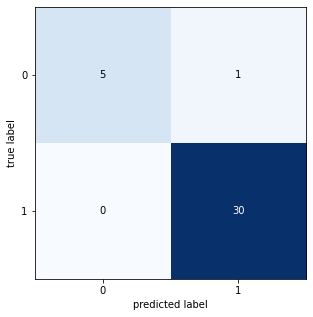

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

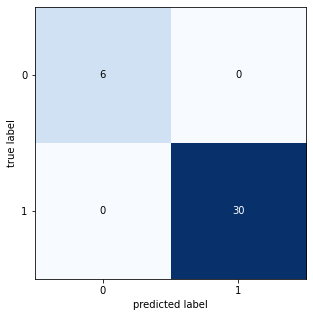

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.41421139600061
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

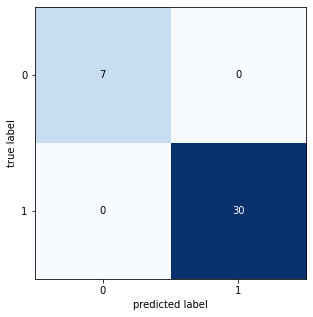

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

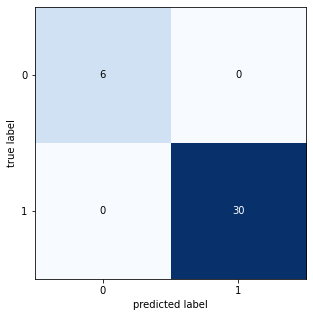

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

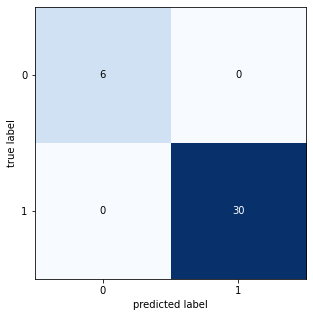

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

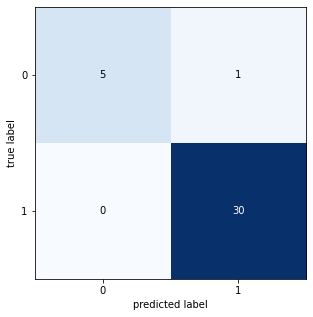

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

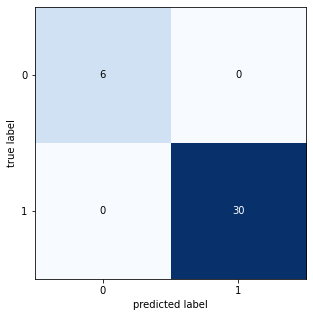

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.29653764700197
gene : [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

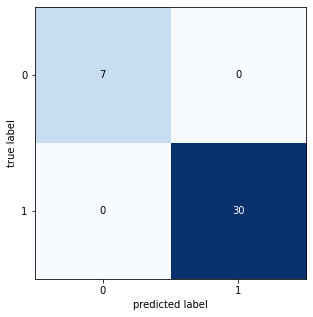

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

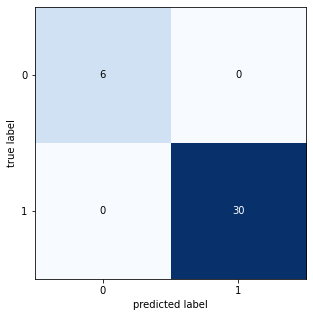

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

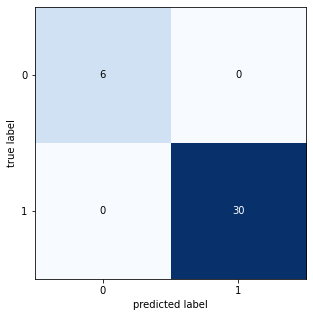

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

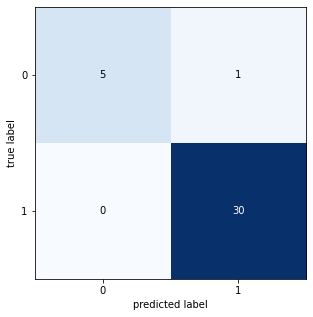

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

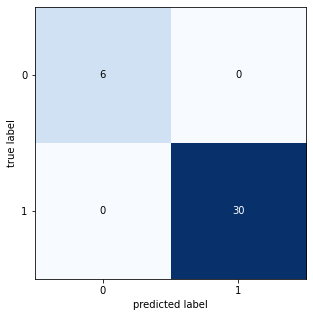

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.85023127800014
gene : [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

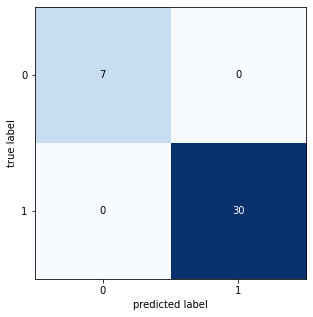

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

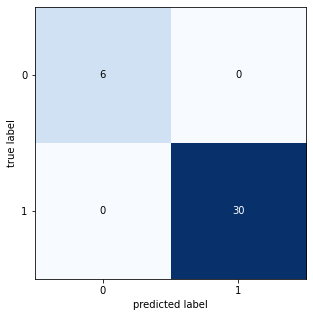

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

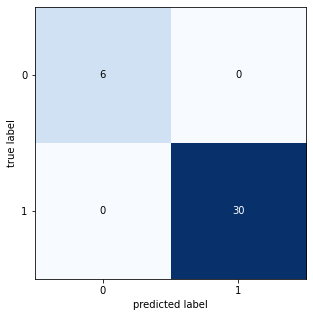

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

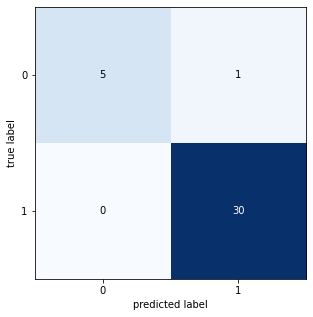

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

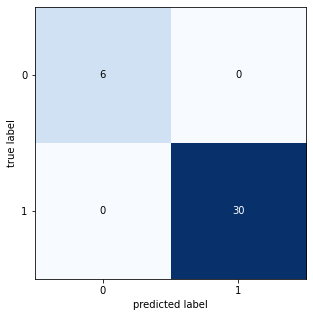

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.341962246999174
gene : [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

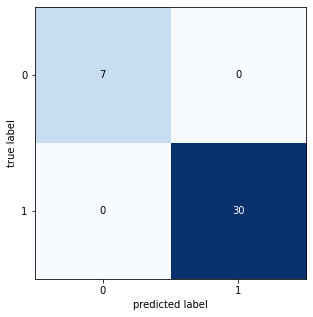

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

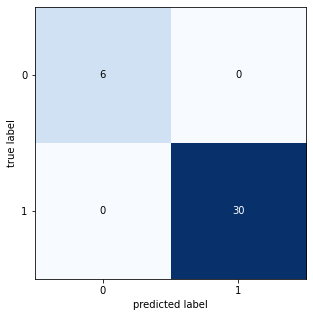

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

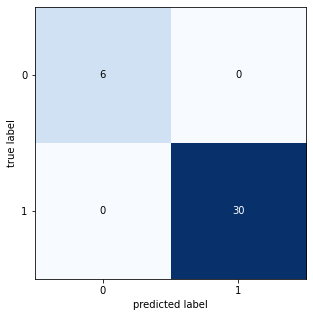

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

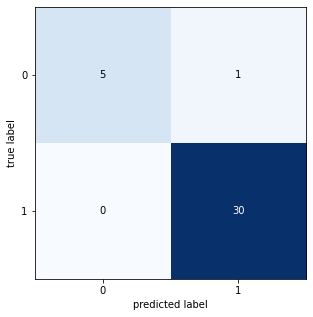

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

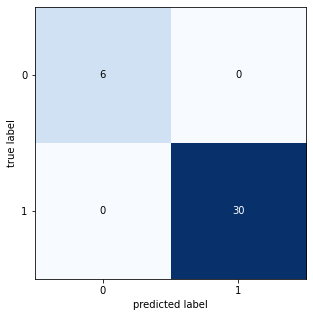

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.398045491998346
gene : [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

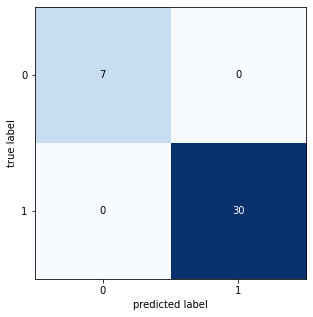

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

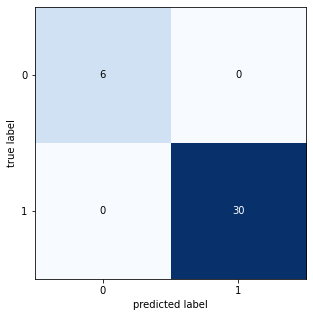

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

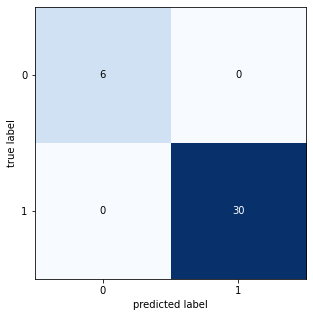

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

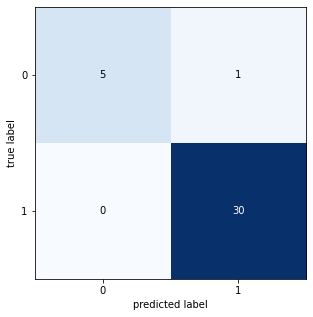

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

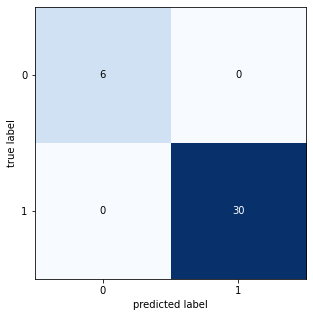

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.92807381500097
gene : [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

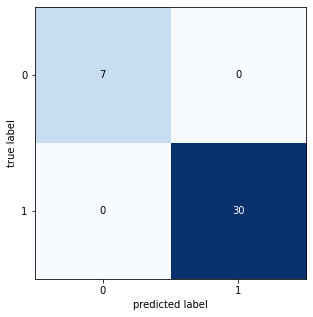

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

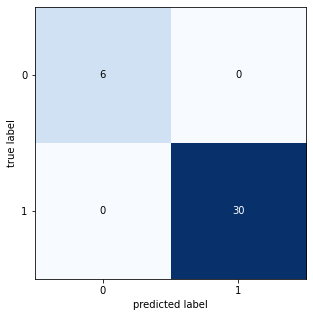

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

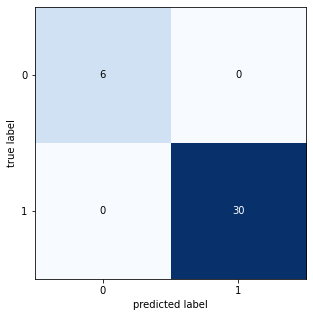

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

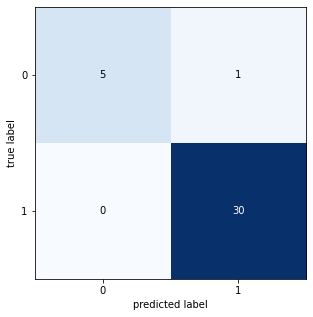

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

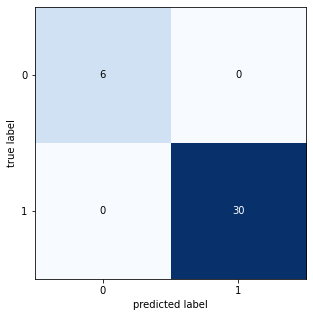

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.26810108400241
gene : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

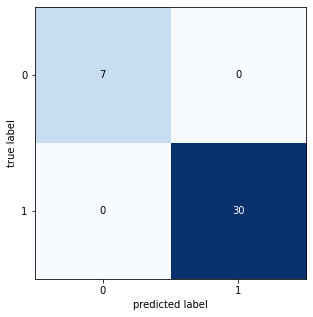

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

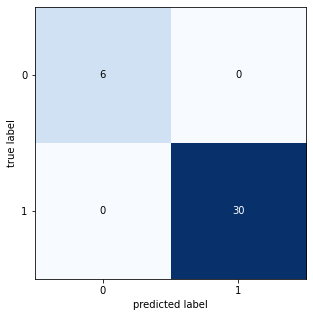

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

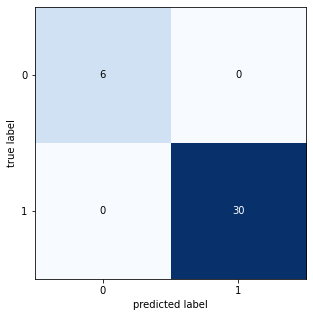

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

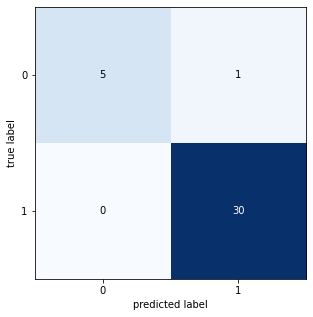

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

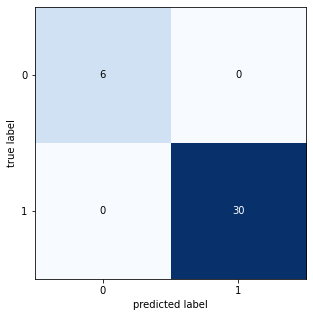

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.617977828998846
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

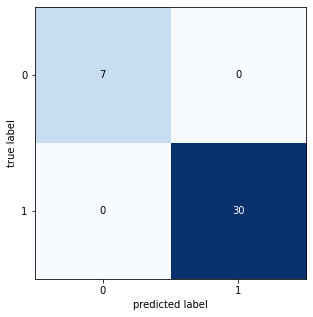

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

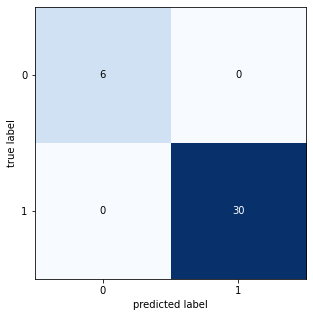

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

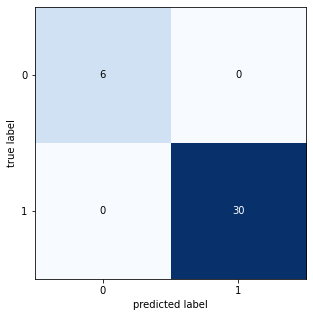

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

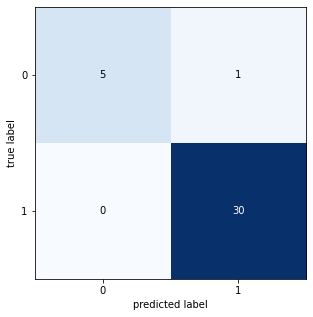

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

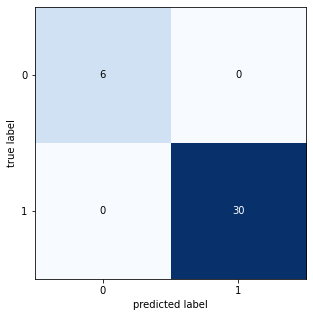

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.22271186600119
gene : [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

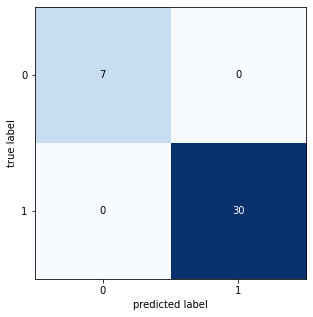

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

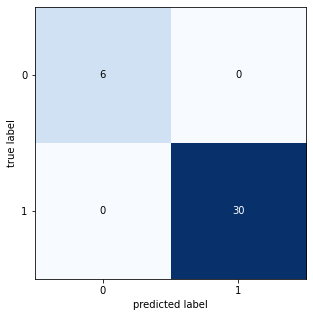

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

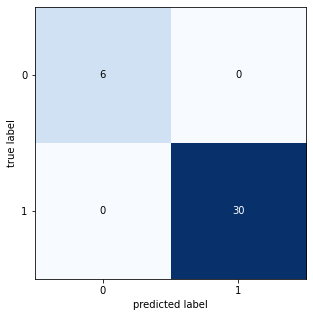

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

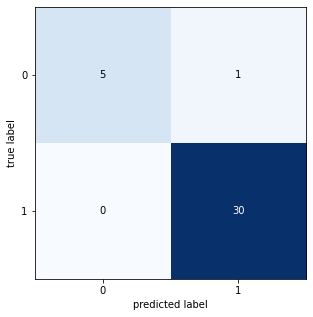

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

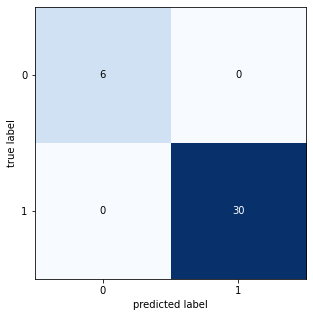

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.2509726749995
gen terbaik : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 46

Generation : 2
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,

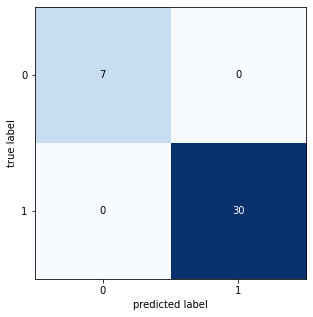

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

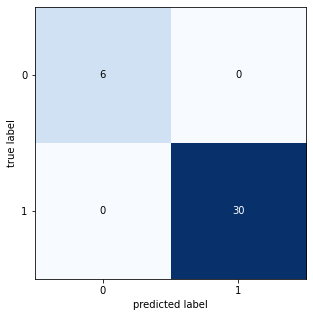

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

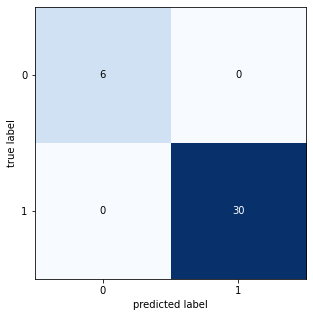

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

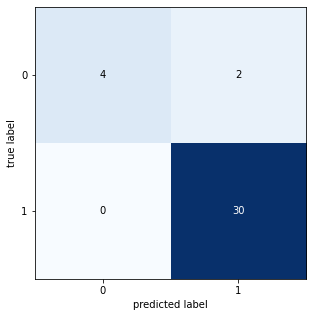

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

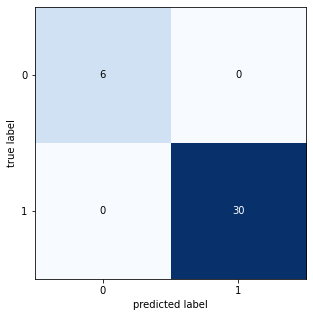

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  39.62414758500017
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

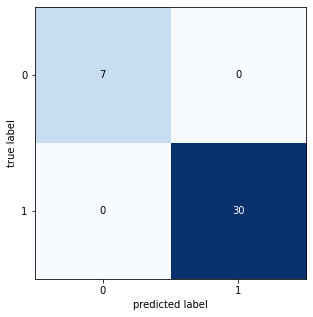

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

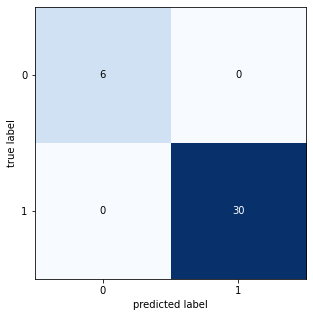

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

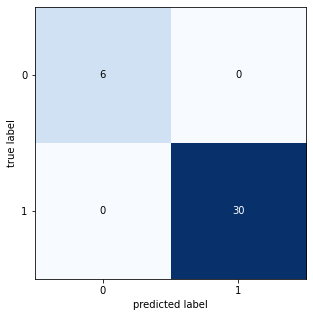

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

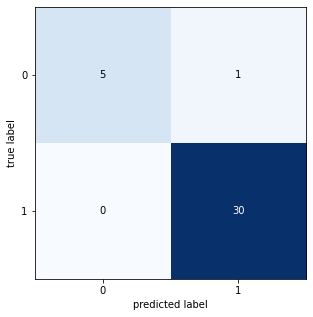

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

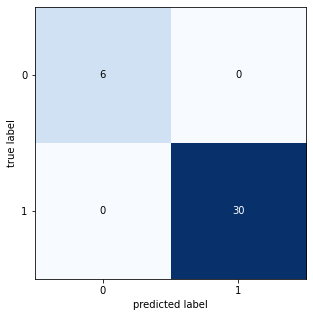

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.217390292000346
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

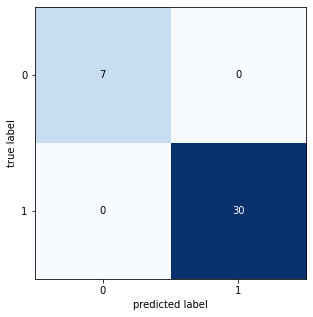

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

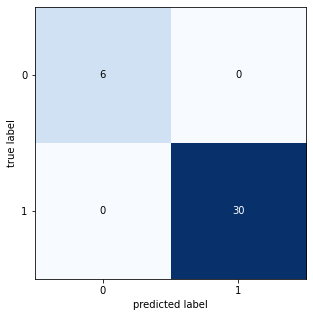

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

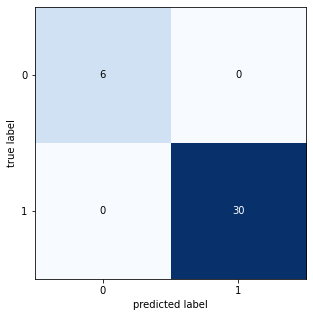

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

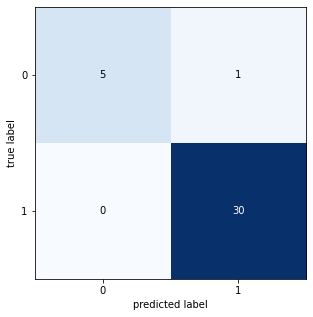

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

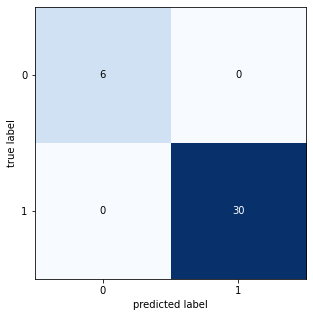

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.24219372999869
gene : [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

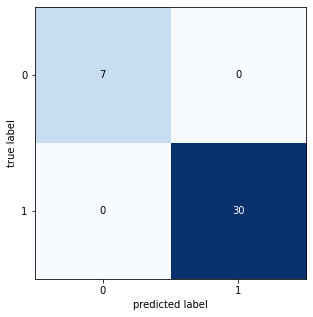

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

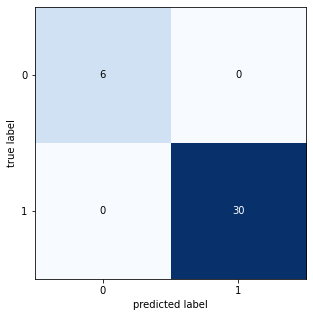

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

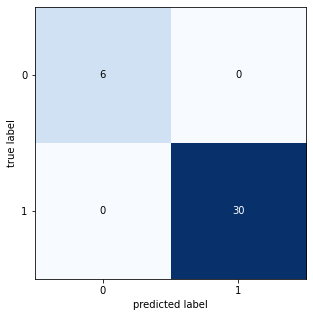

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

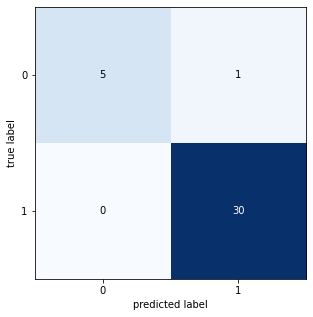

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

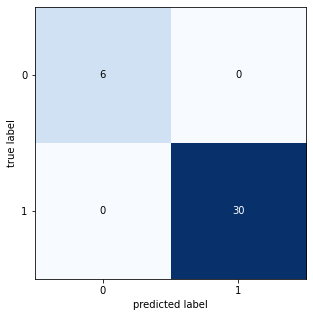

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.60886139200011
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

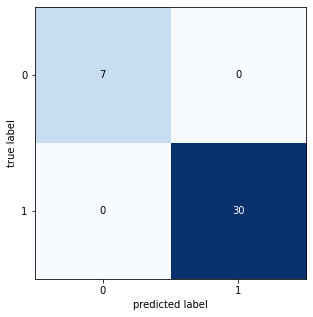

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

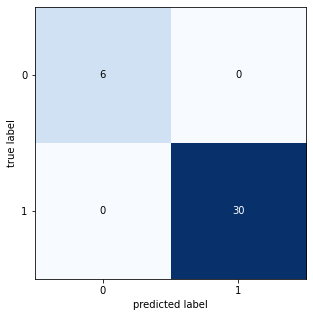

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

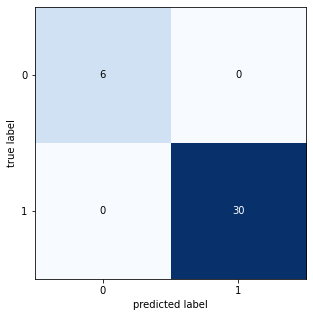

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

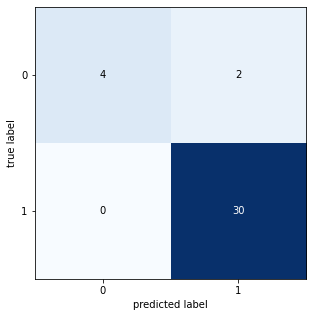

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

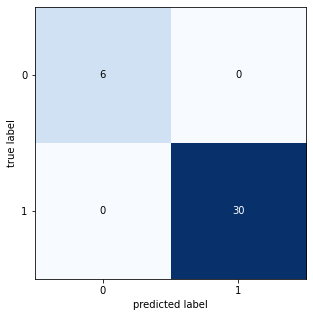

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  40.43809044899899
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

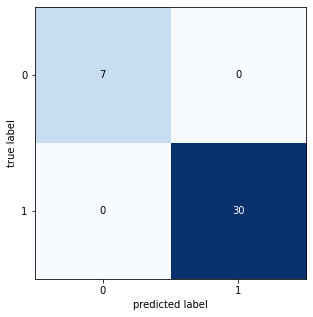

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

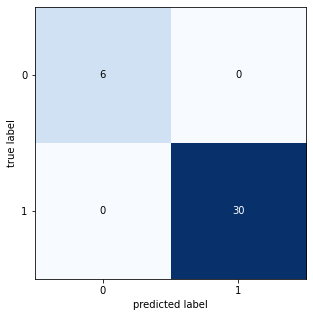

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

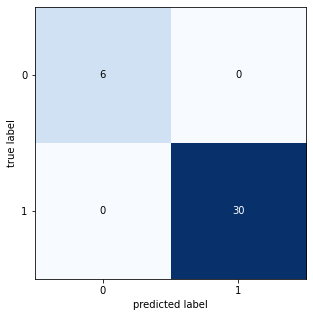

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

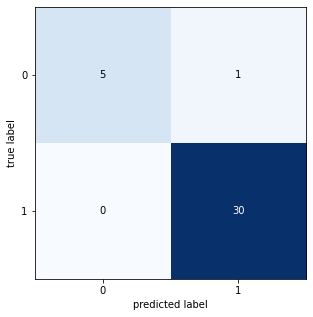

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

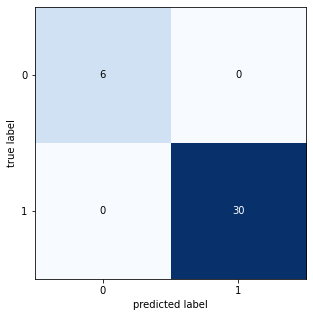

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.92076112200084
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

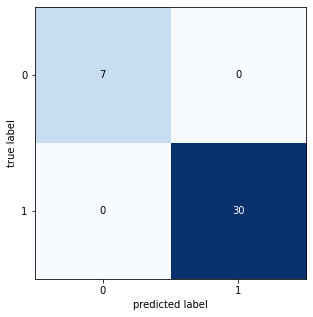

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

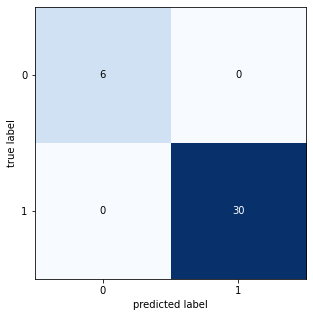

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

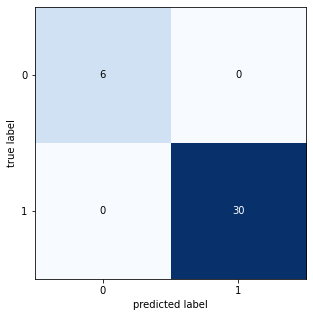

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

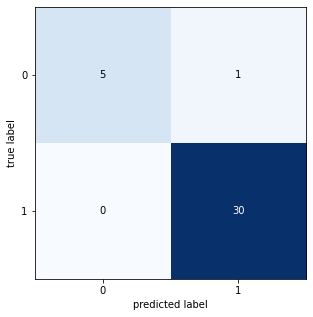

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

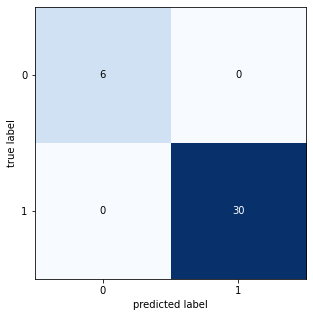

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.60747667100077
gene : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

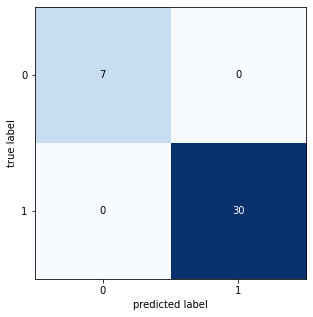

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

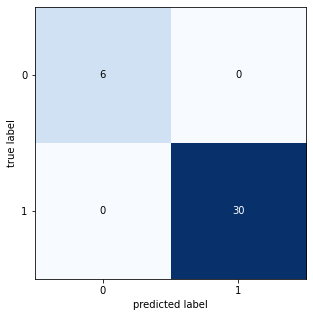

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

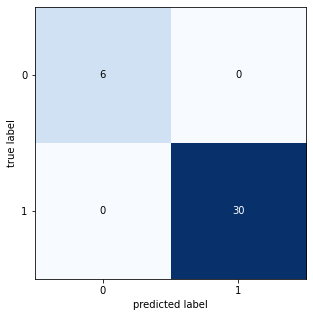

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

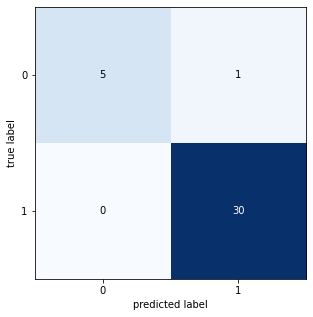

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

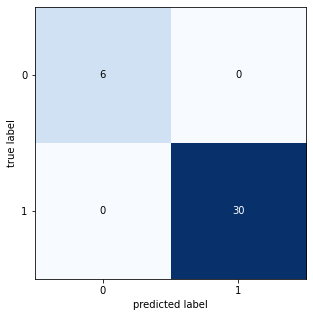

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.152698834997864
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

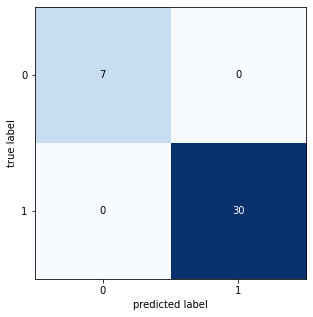

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

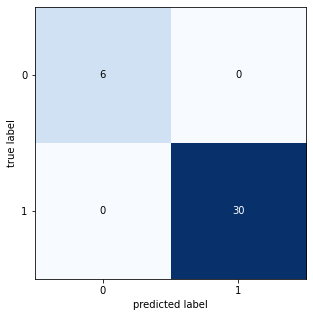

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

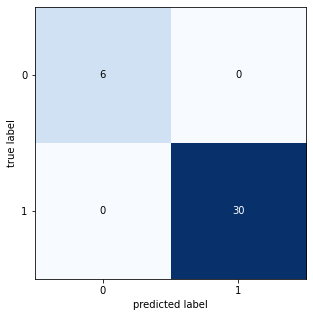

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

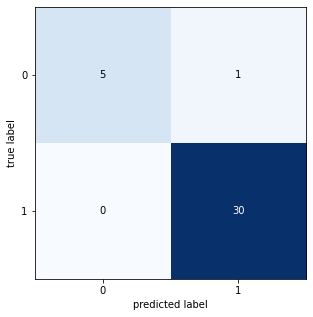

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

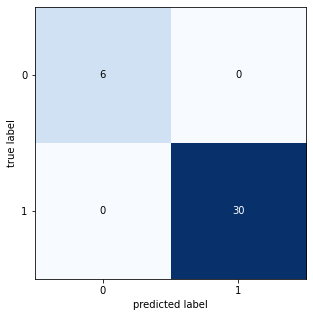

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.22074999200049
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

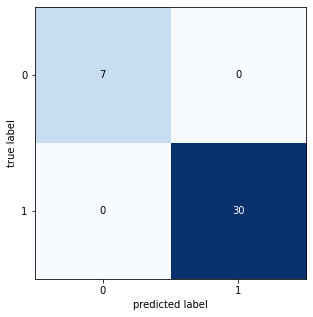

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

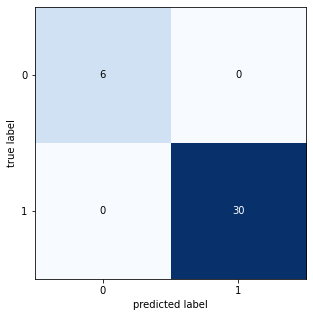

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

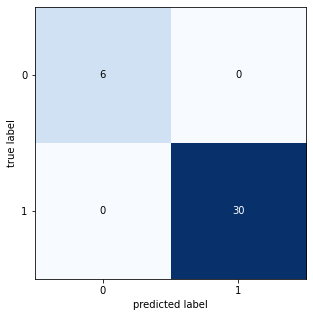

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

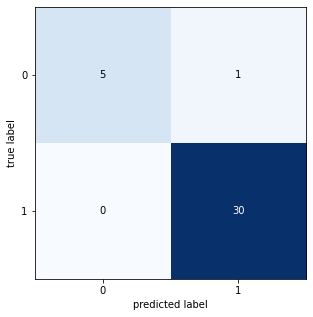

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

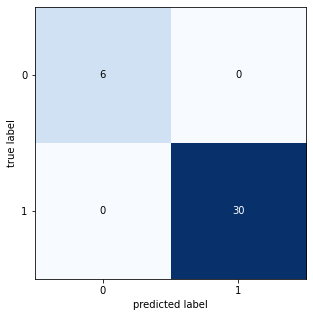

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.28039080799863
gen terbaik : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 58

Generation : 3
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1

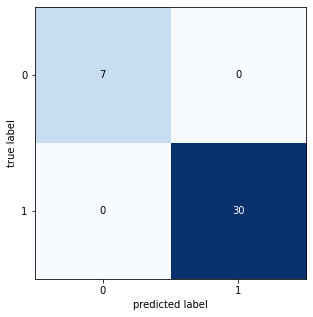

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

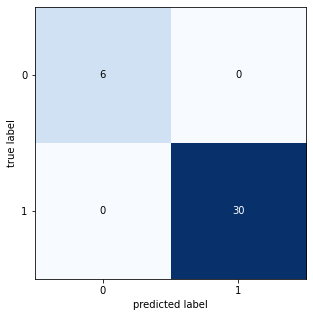

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

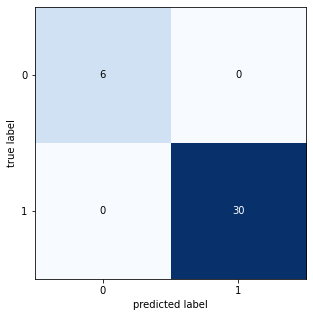

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

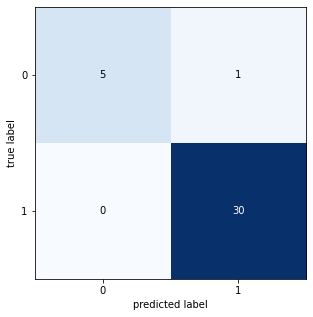

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

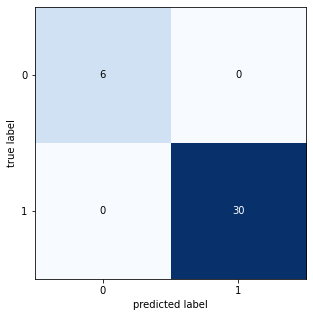

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.79909288899944
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

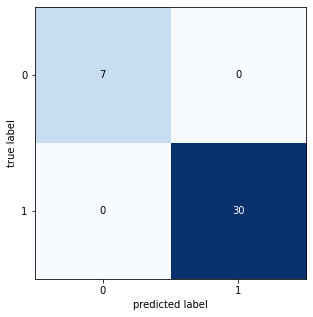

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

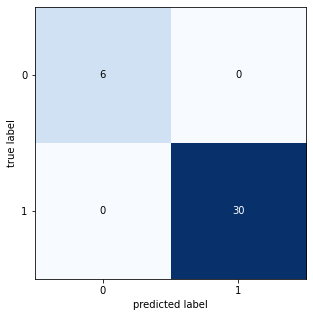

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

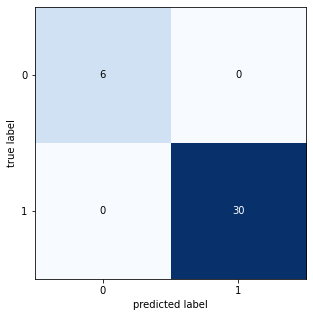

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

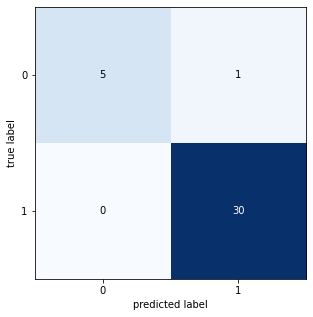

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

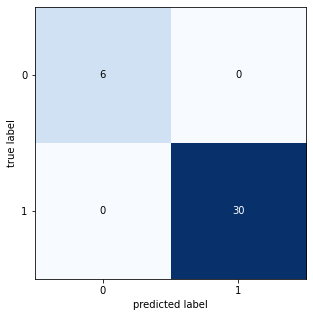

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.632176253999205
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

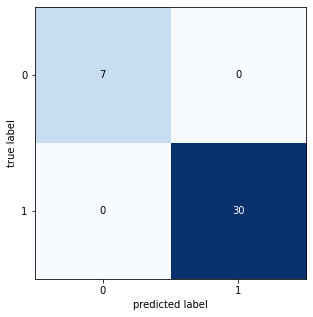

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

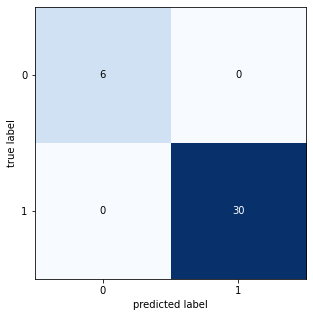

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

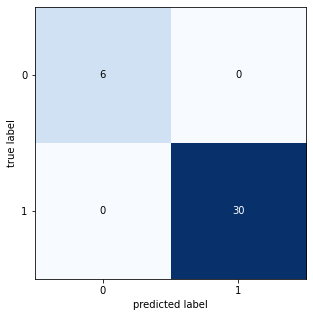

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

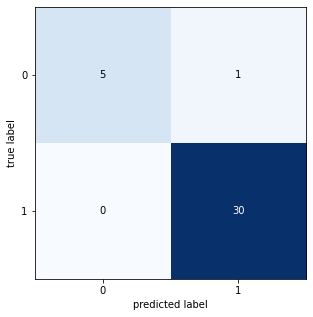

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

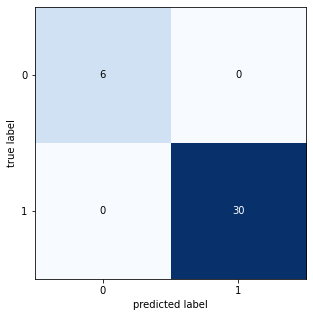

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.61971062500015
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

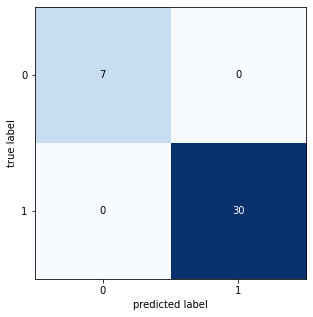

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

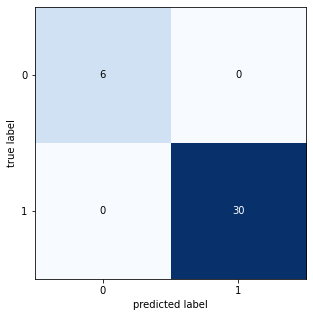

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

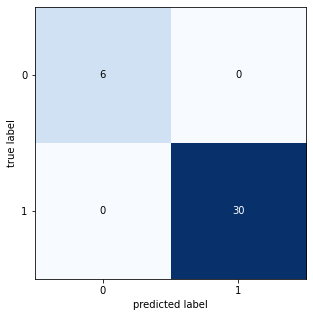

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

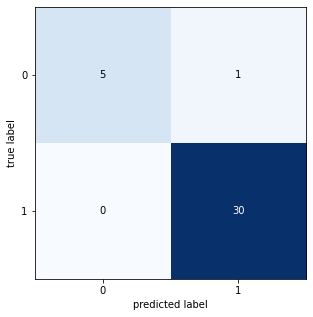

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

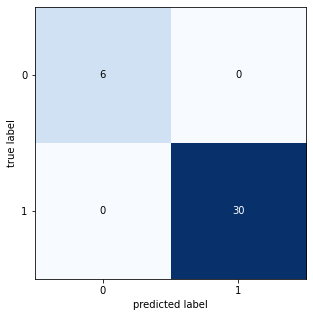

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.56781883199801
gene : [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

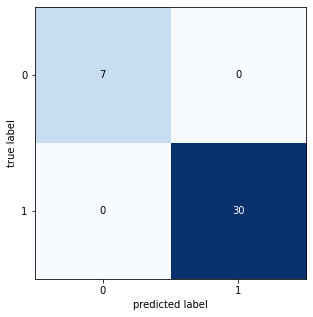

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

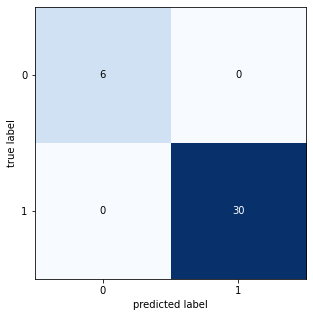

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

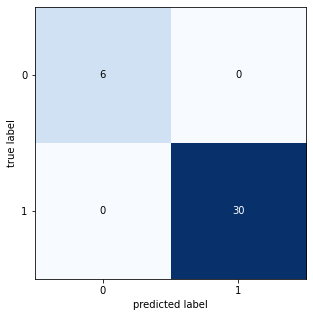

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

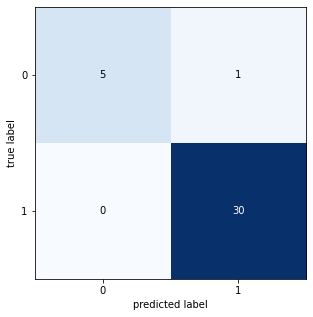

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

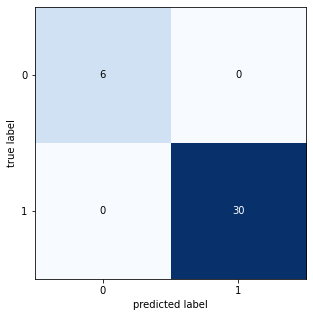

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.39262065499861
gene : [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

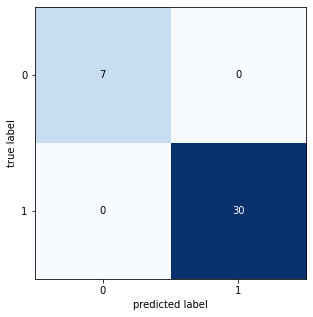

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

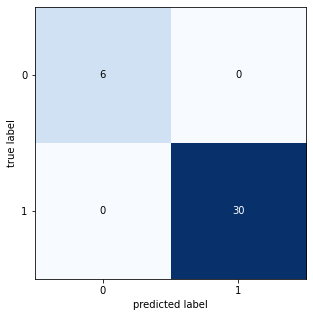

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

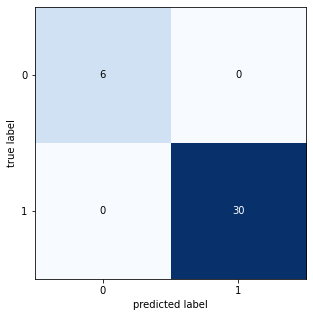

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

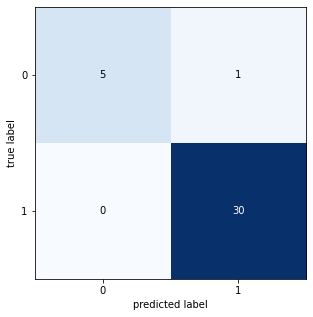

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

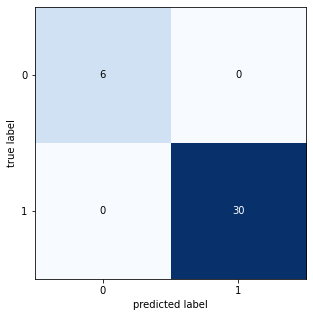

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.86269608099974
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

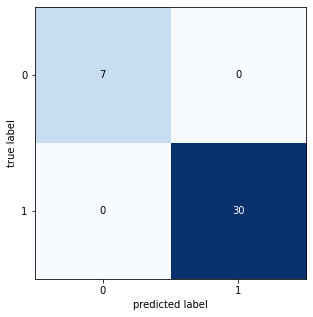

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

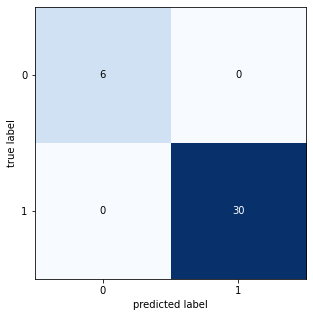

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

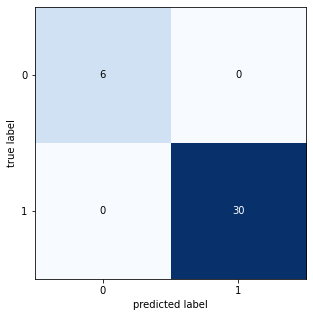

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

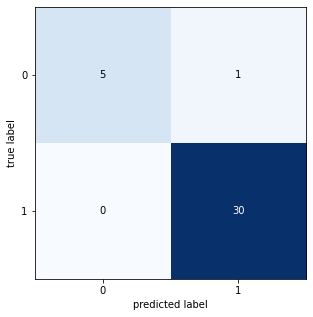

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

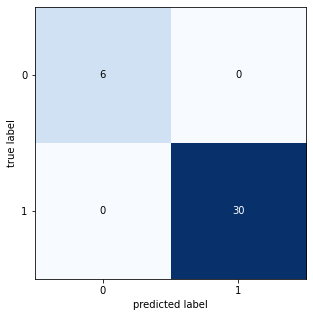

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.43621938599972
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

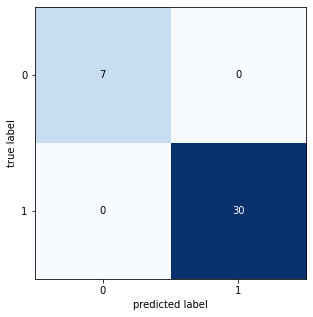

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

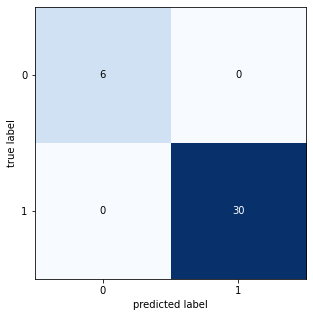

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

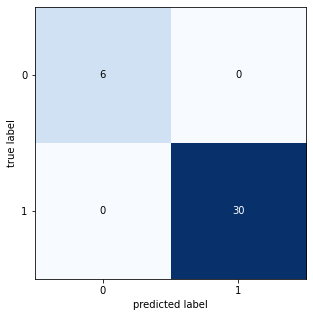

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

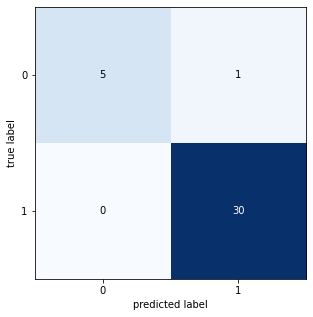

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

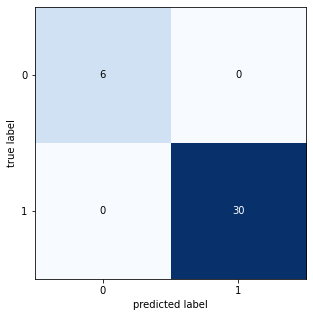

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.39691214499908
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

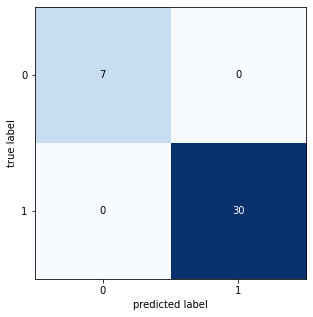

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

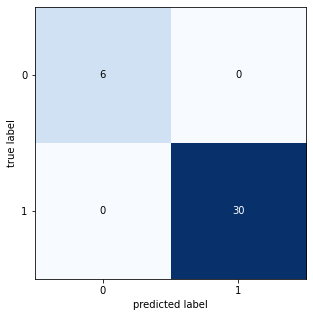

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

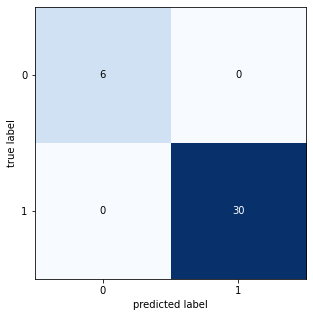

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

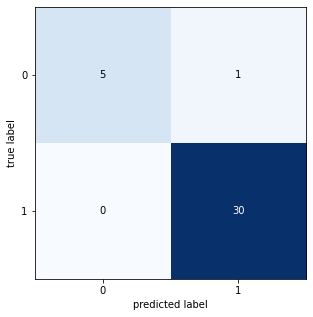

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

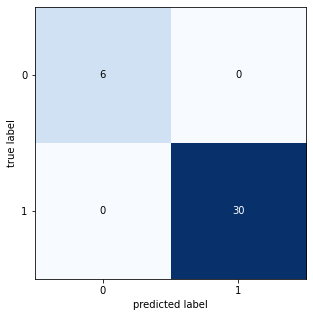

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.15717199299979
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

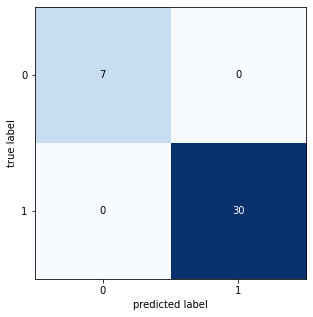

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

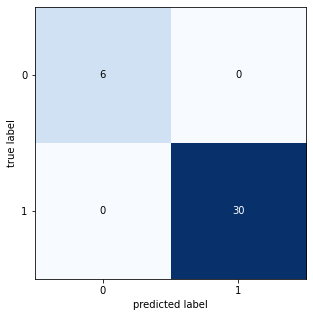

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

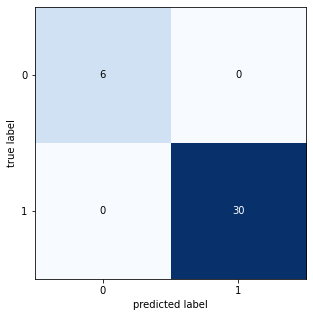

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

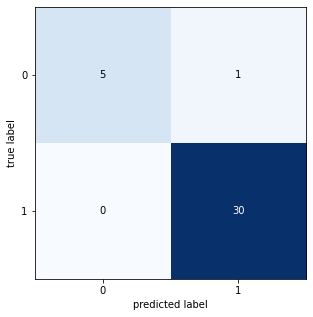

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

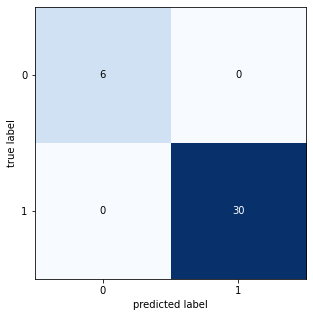

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.09555588699732
gen terbaik : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 48

Generation : 4
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0

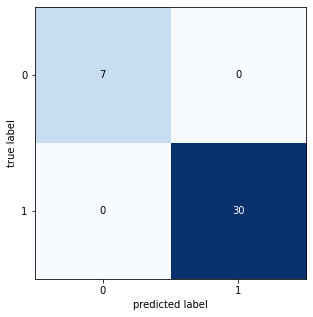

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

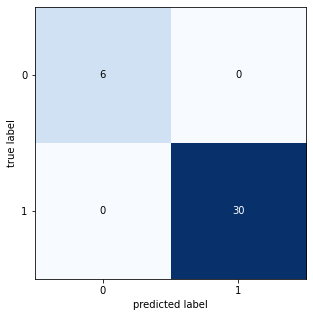

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

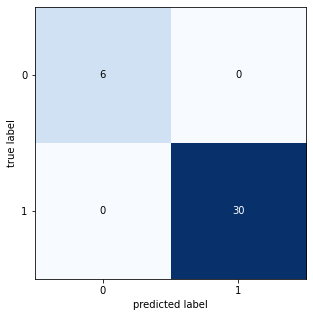

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

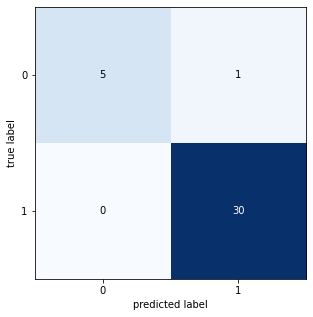

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

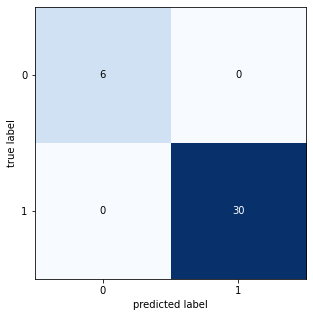

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.44077086400284
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

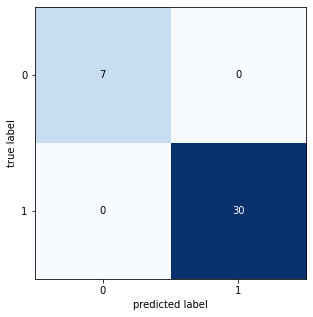

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

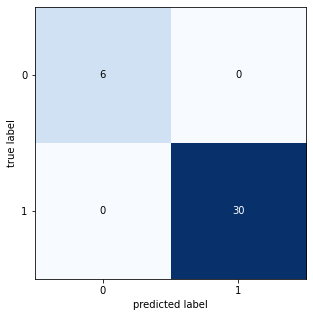

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

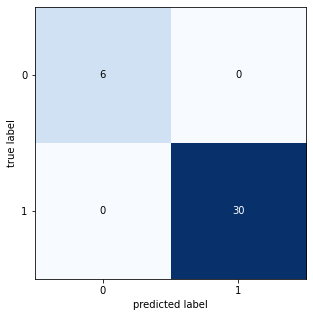

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

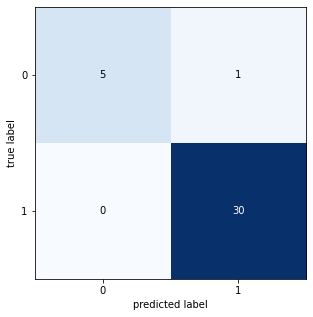

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

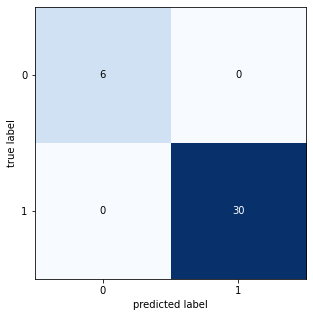

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.436989167999855
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

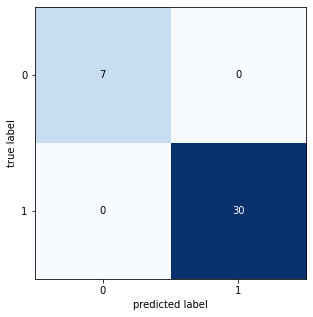

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

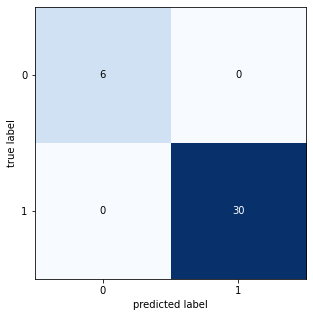

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

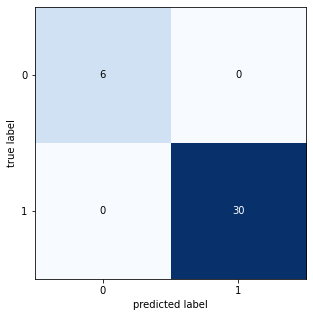

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

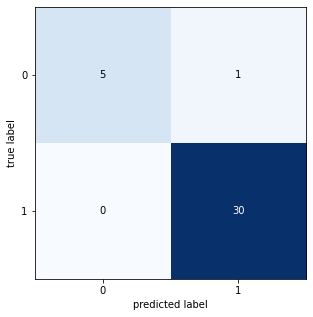

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

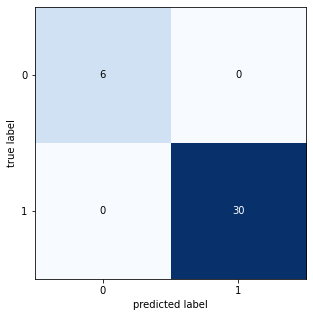

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.079971040999226
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

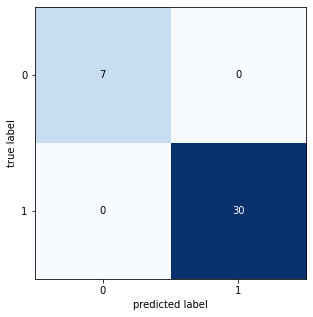

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

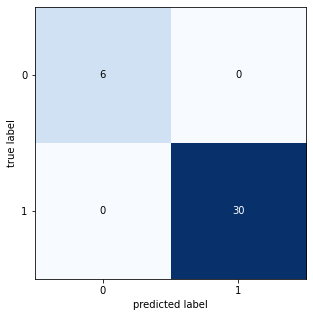

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

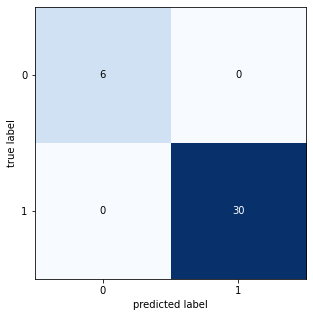

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

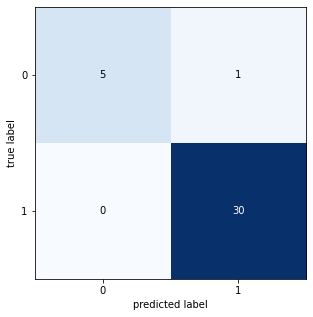

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

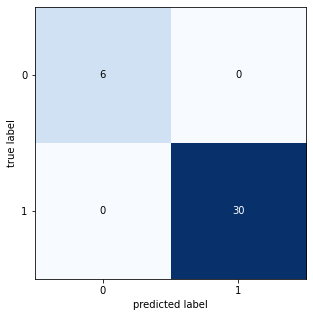

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.595771983000304
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

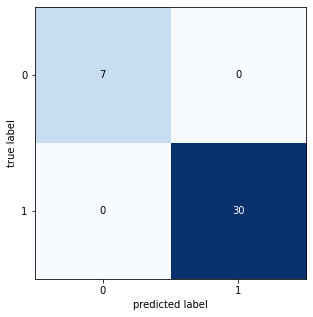

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

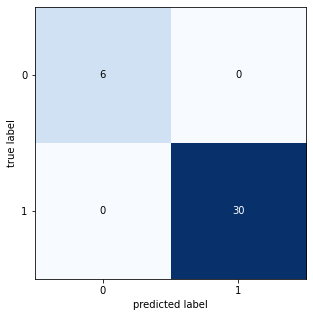

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

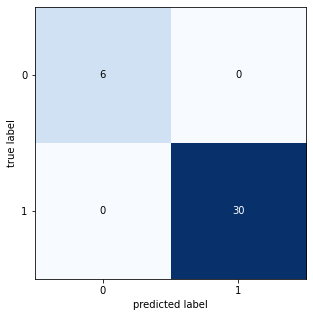

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

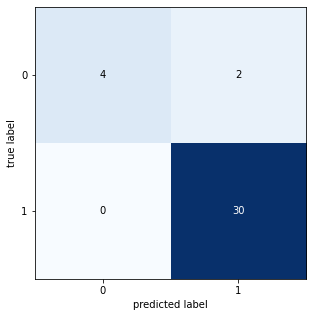

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

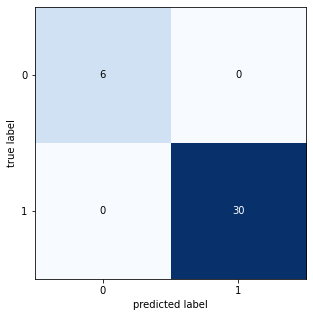

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  39.77533505199972
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

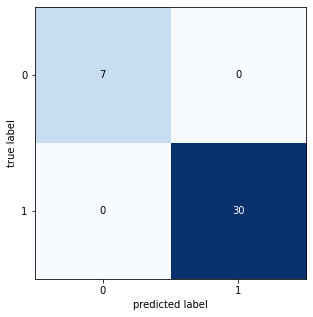

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

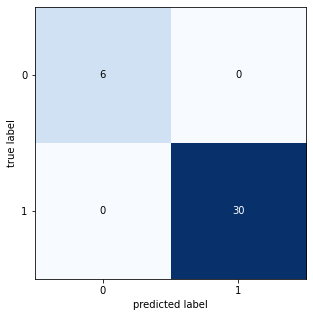

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

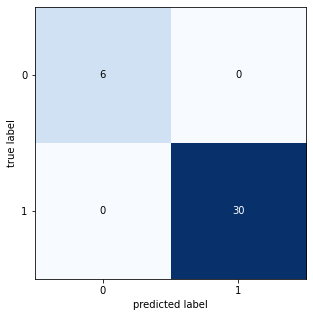

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

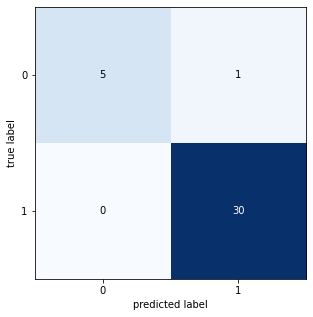

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

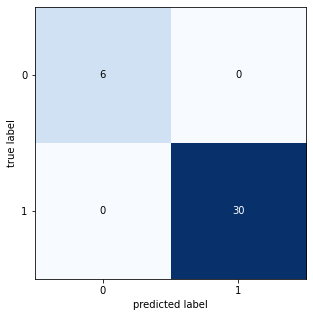

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.224988572001166
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

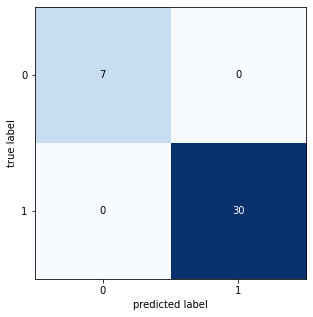

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

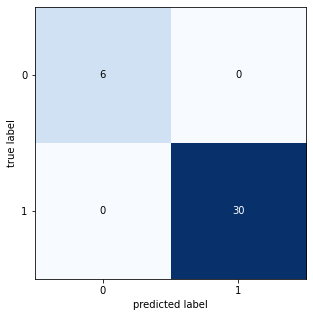

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

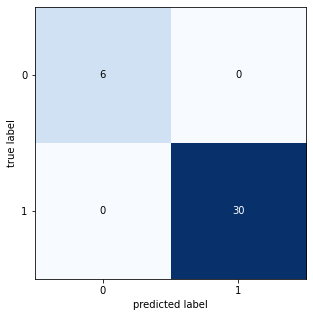

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

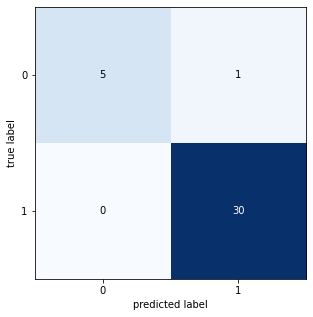

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

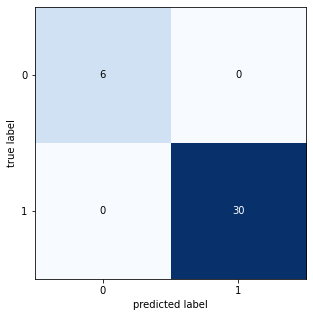

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.24774544200045
gene : [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

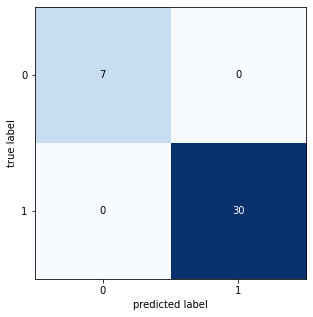

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

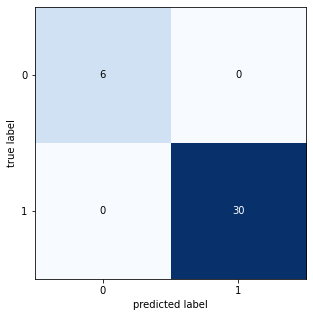

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

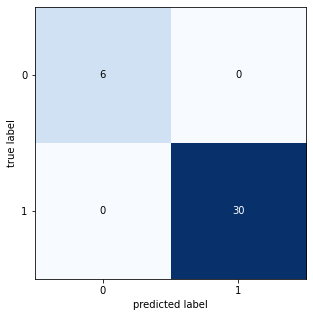

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

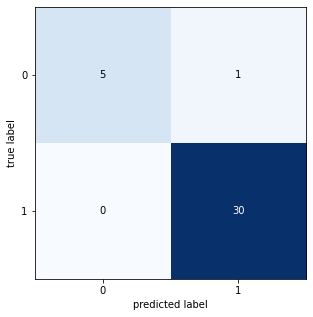

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

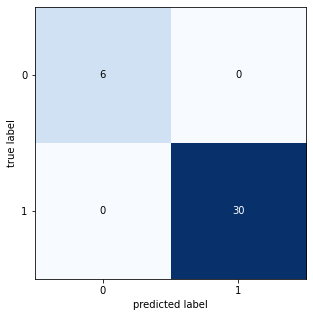

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.14100962900193
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

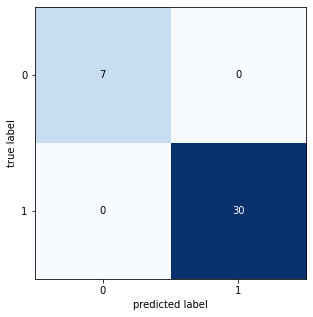

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

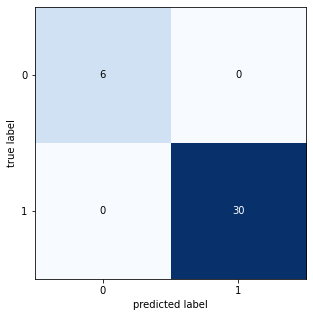

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

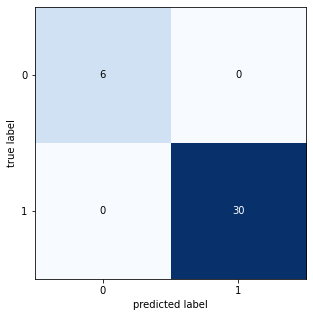

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

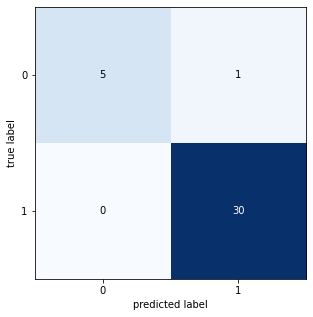

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

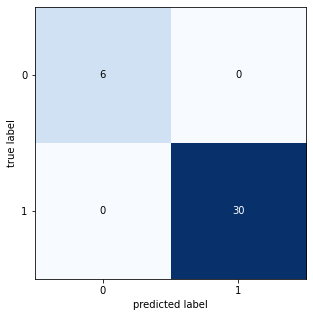

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.074780926999665
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

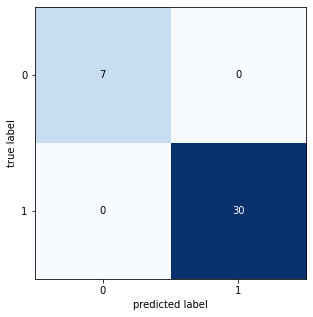

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

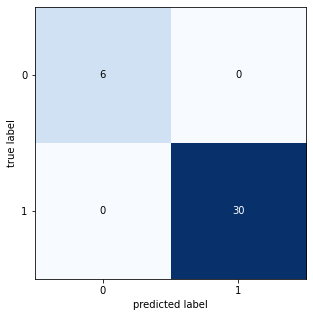

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

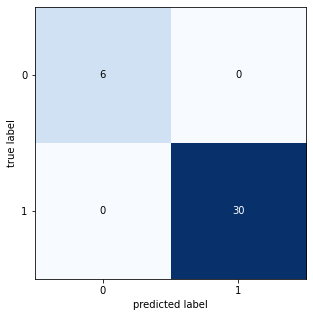

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

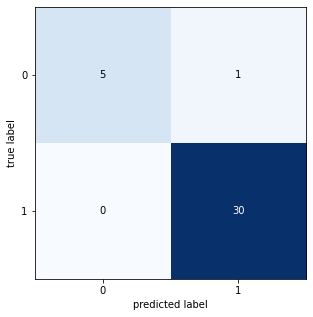

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

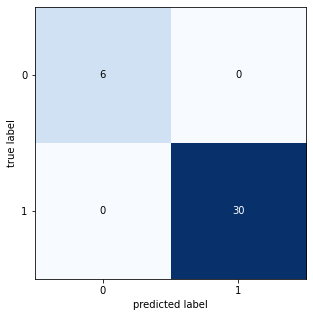

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.50754825999684
gen terbaik : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 51

Running Time:  2004.4436572179984


In [14]:
Lung_IG_GA = GeneticAlgorithm(Lung_IG, 3)

Generation : 0
gene : [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134
 135 137 139 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157
 158 159 161 163 164 165 166 169 170 171 172 173 174 175 176 177 178 179] Test : [  2   3   4   9  13  17  24  25  35  48  50  53  56  71  77  89  94  95
  96

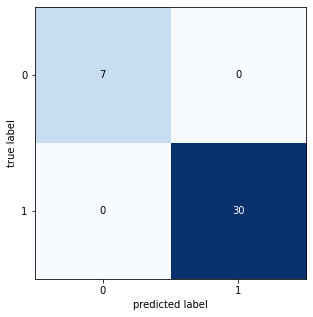

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

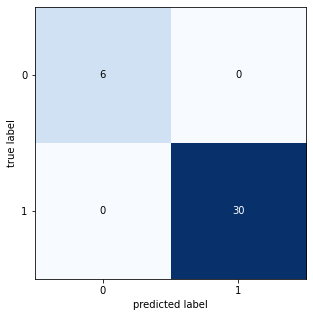

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

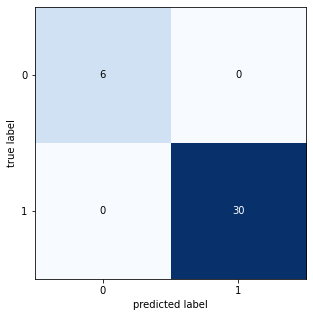

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

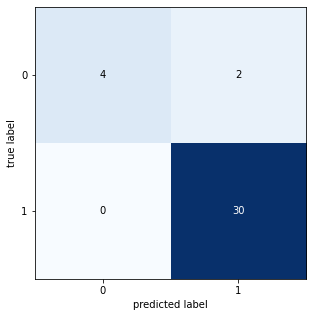

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

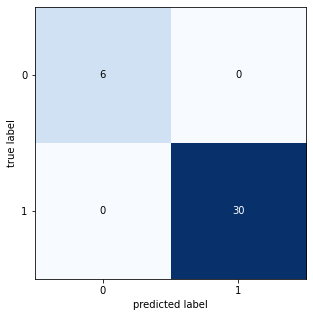

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  41.43825073699918
gene : [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

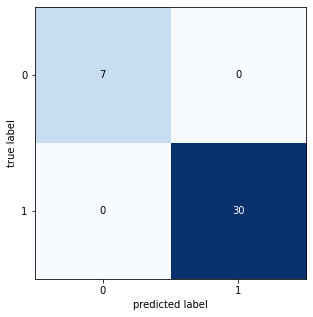

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

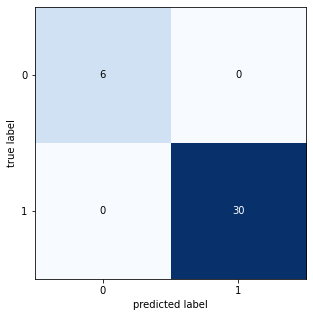

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

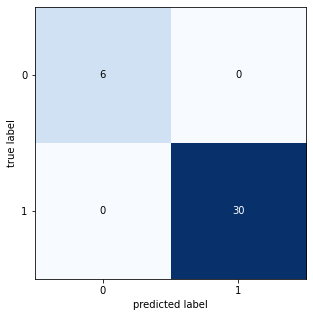

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

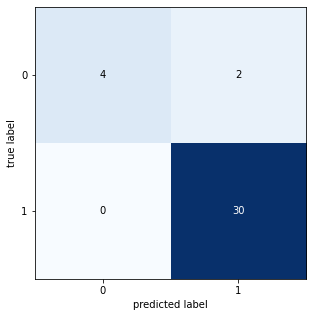

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

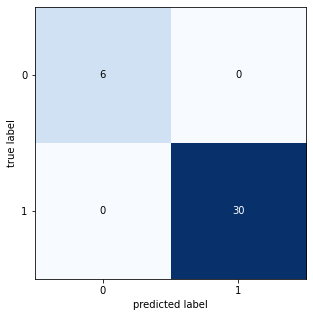

avg accuraccy Lung Cancer =  0.9888888888888889
avg F1_Score Lung Cancer =  0.9767741935483871
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9444444444444444
min F1_Score Lung Cancer =  0.8838709677419355
Running Time:  43.72181408399774
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

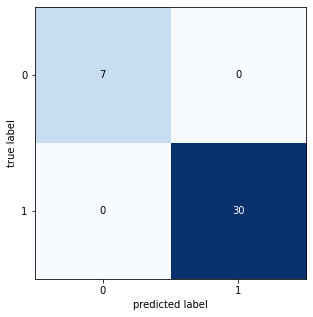

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

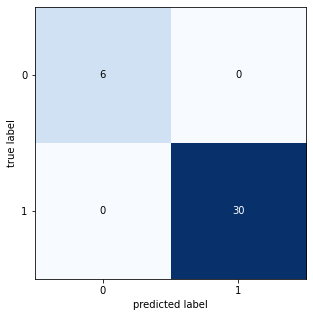

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

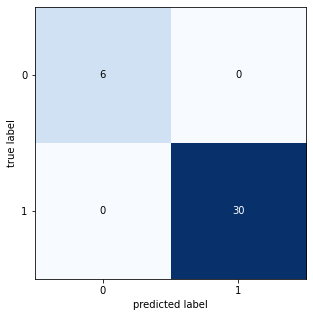

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

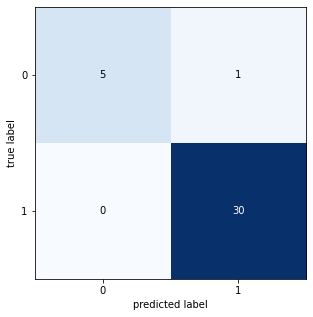

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

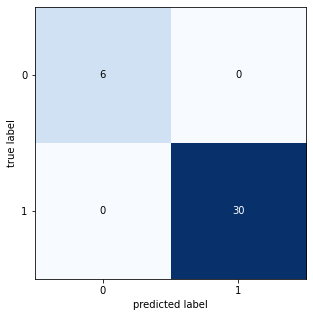

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.968916272999195
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

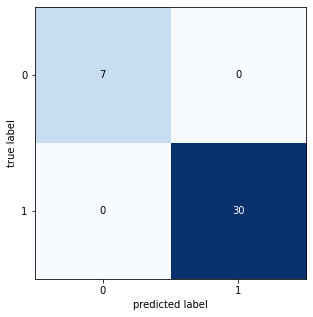

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

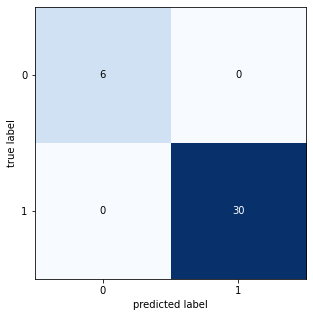

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

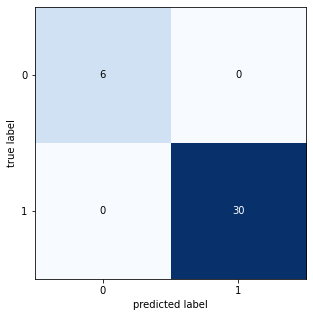

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

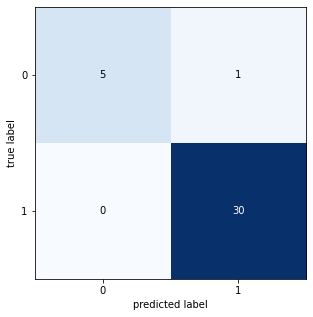

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

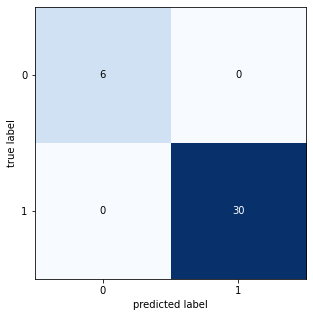

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.64931288099979
gene : [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

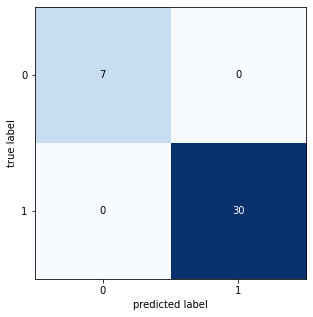

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

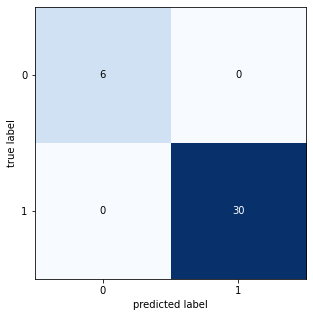

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

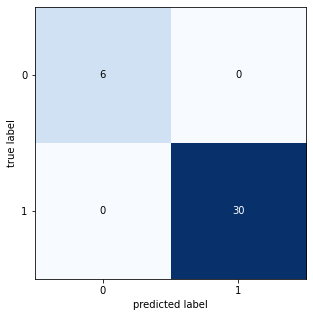

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

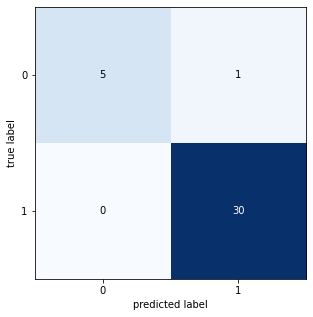

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

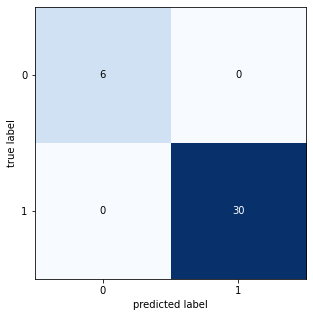

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.81848306000029
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

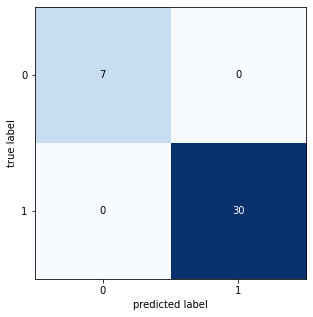

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

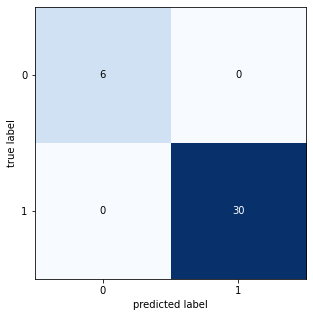

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

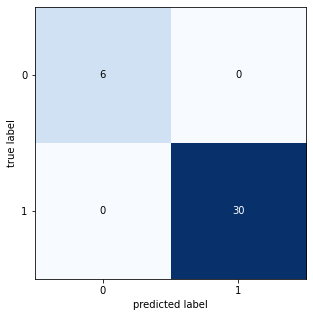

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

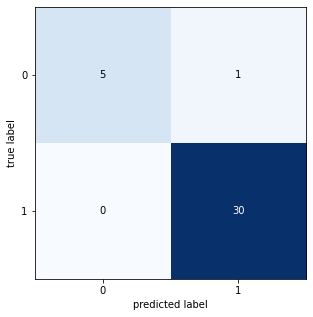

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

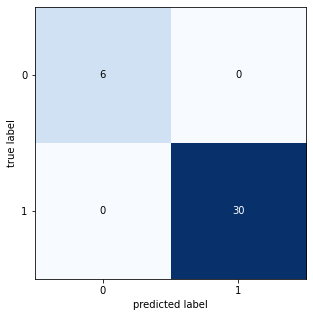

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.673622988000716
gene : [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

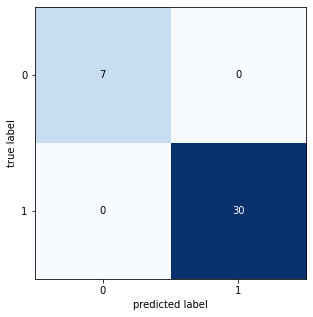

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

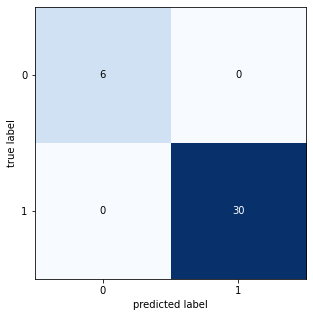

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

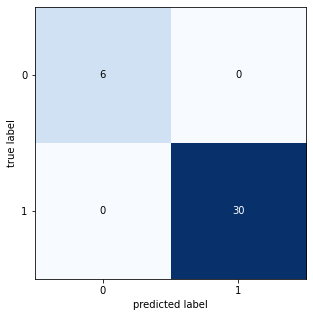

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

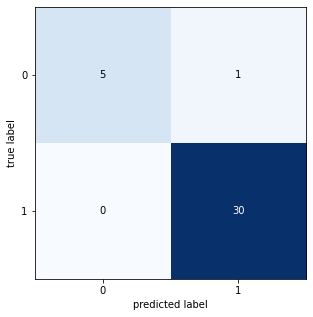

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

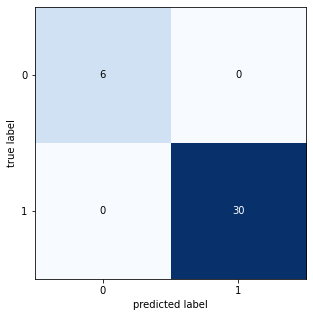

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.593478940998466
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

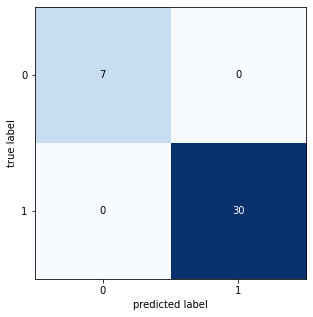

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

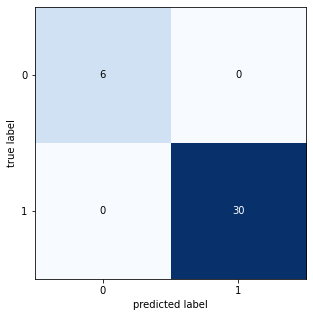

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

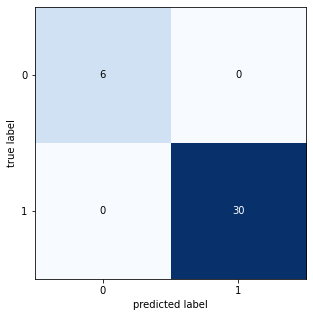

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

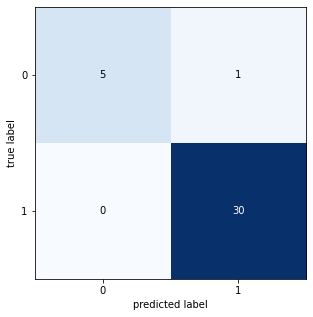

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

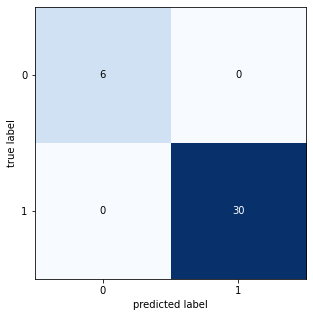

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.33059474299807
gene : [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

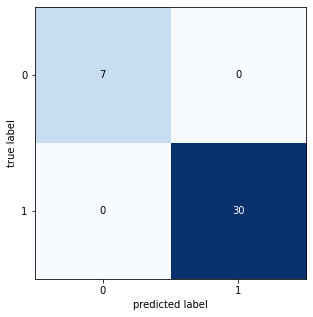

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

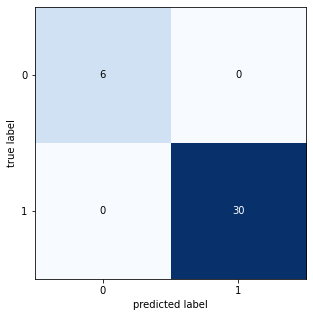

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

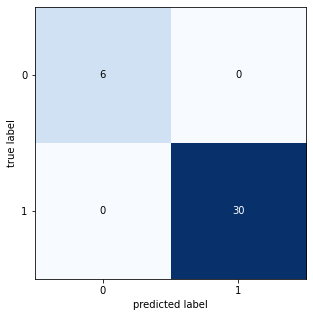

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

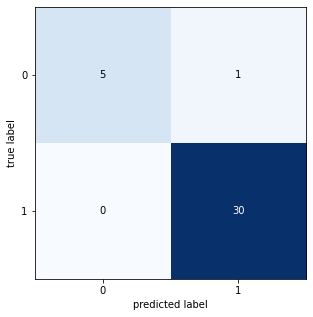

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

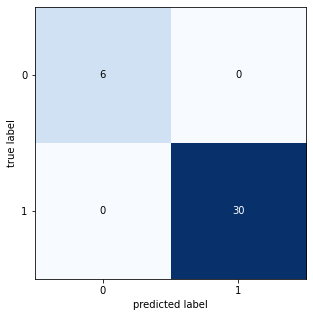

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.639359775999765
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

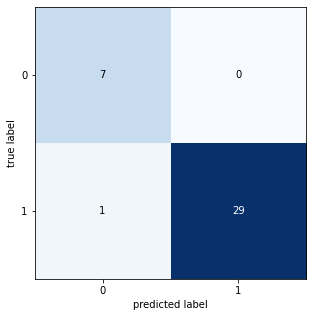

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

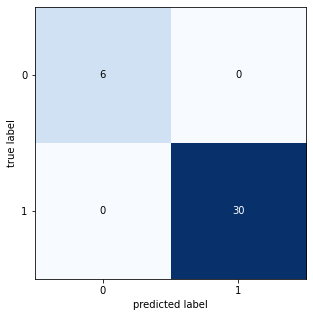

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

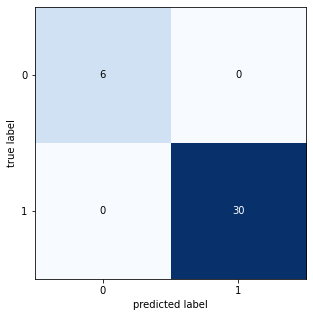

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

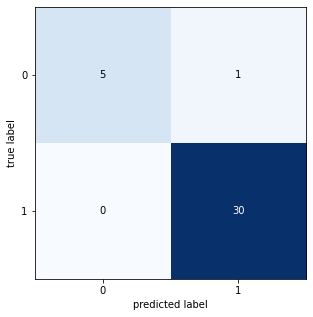

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

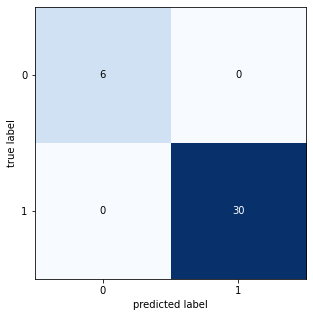

avg accuraccy Lung Cancer =  0.989039039039039
avg F1_Score Lung Cancer =  0.9809081647258917
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.863826490000065
gen terbaik : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 49

Generation : 1
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0

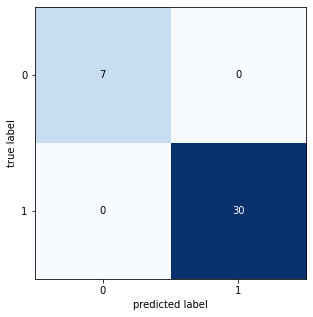

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

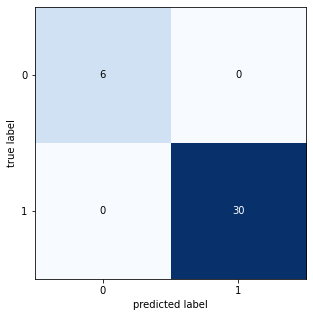

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

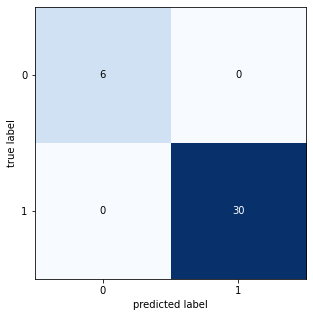

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

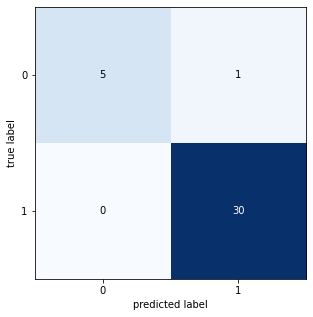

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

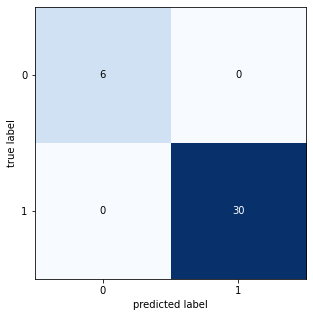

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.5396188190025
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

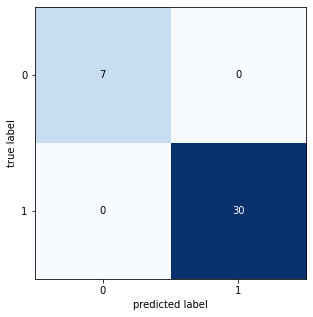

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

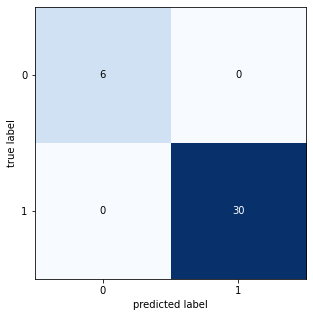

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

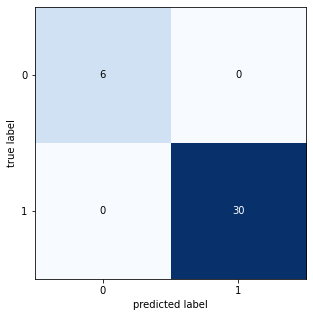

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

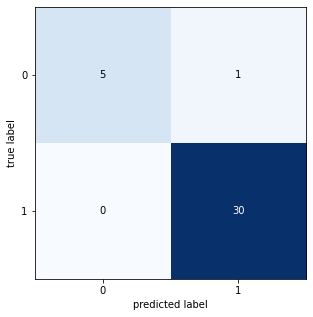

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

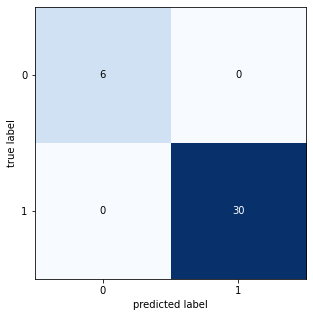

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.46381047599789
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

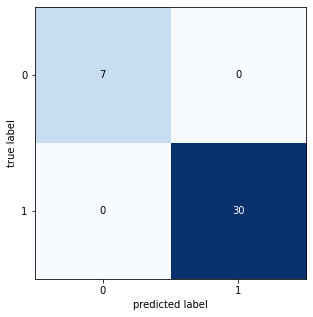

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

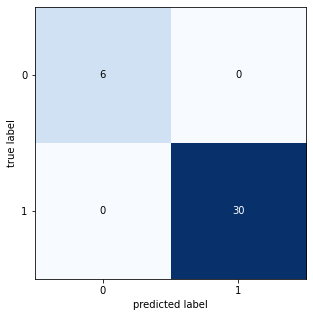

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

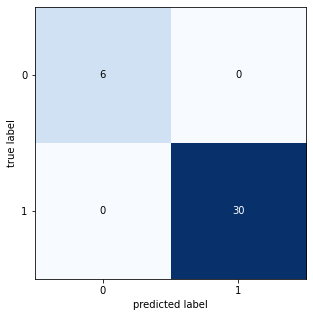

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

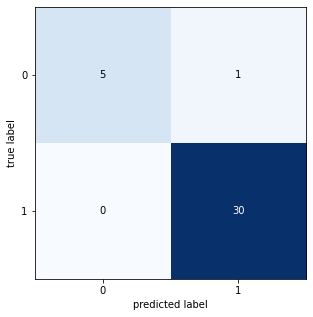

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

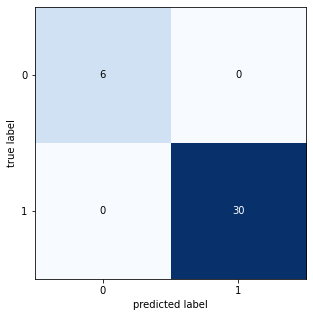

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.783992190998106
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

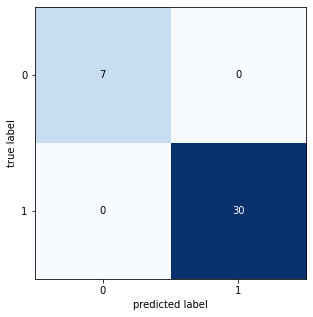

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

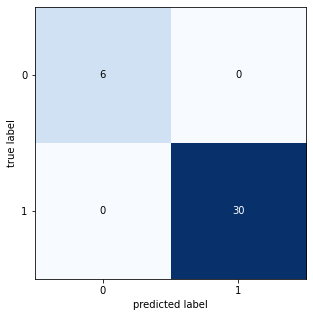

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

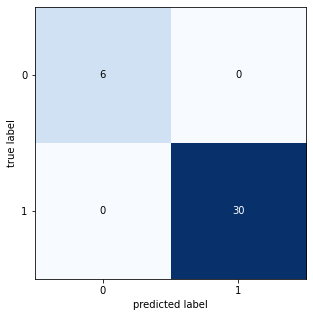

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

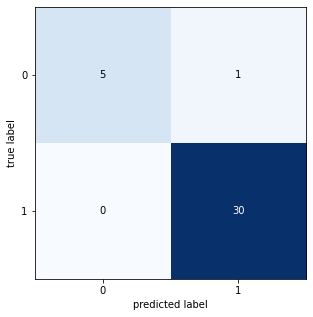

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

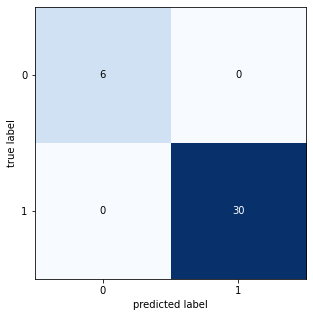

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.25197889300034
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

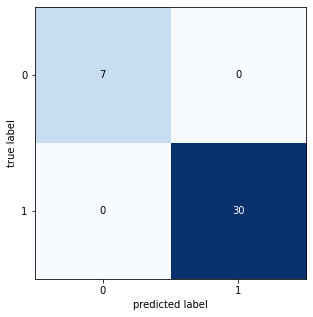

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

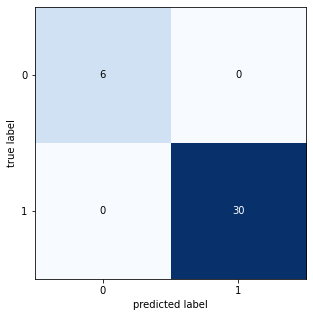

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

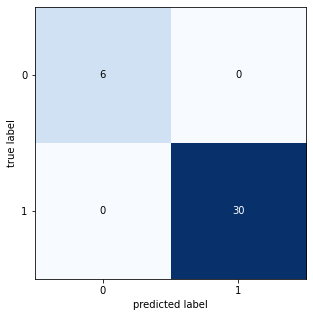

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

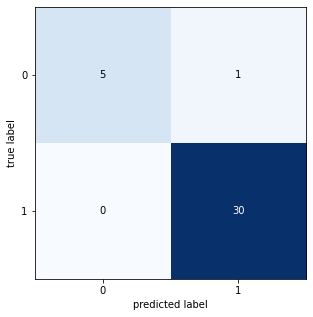

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

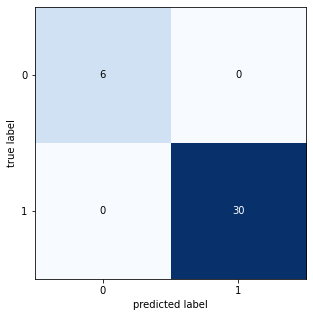

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.79208832000222
gene : [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

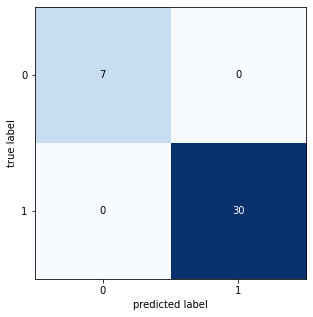

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

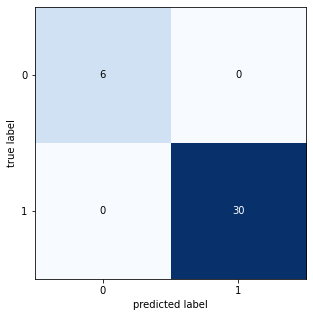

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

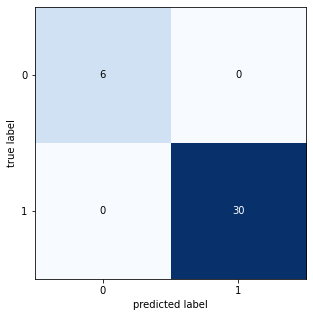

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

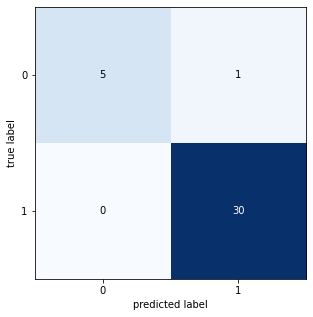

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

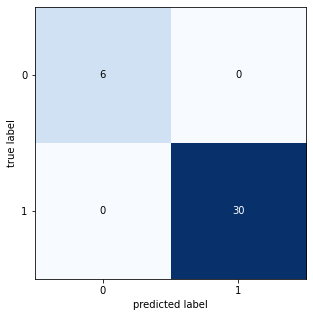

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.16584319499816
gene : [0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

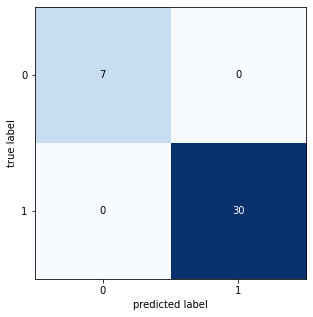

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

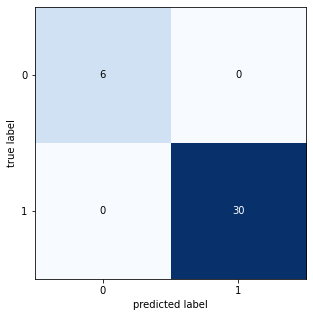

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

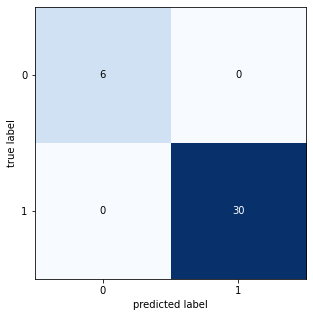

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

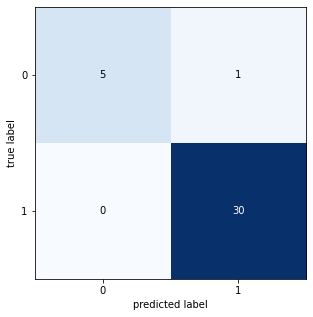

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

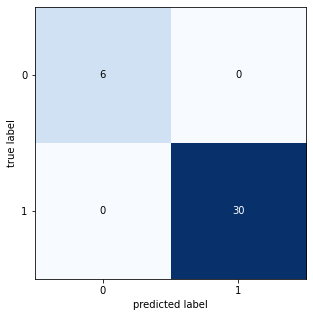

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.610452310000255
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

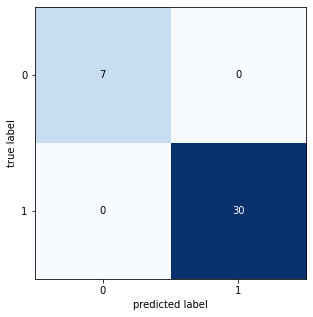

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

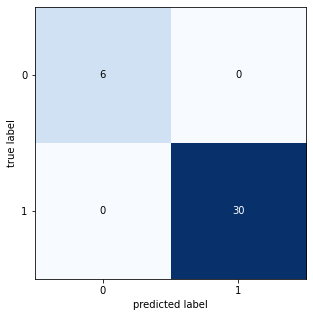

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

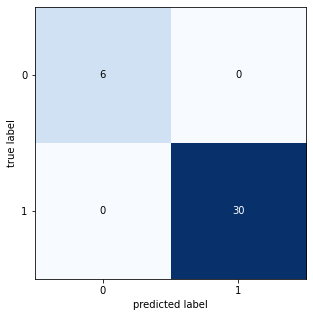

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

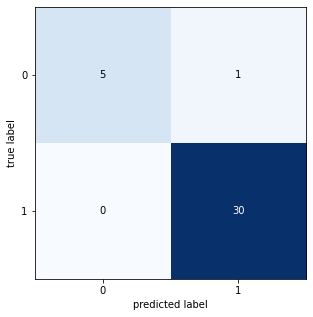

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

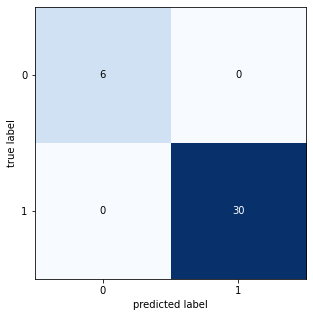

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.771596289003355
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

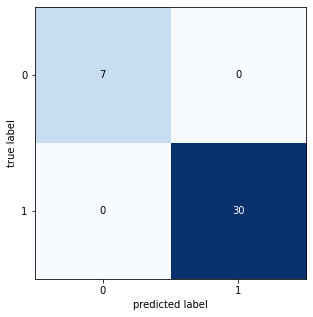

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

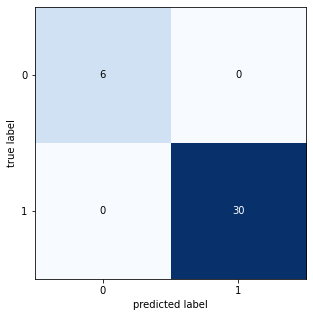

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

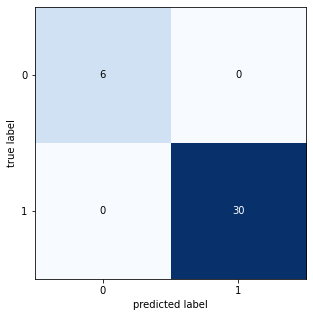

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

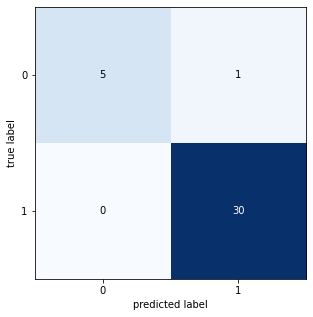

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

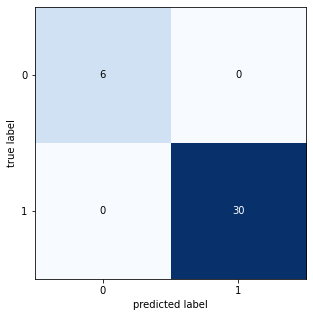

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.62382940199677
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

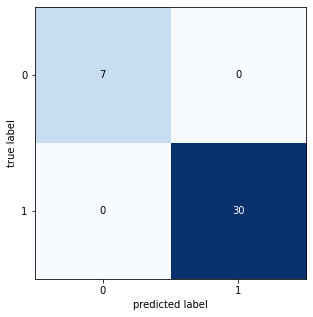

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

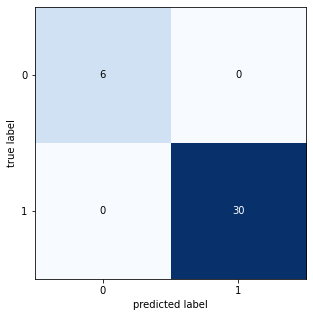

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

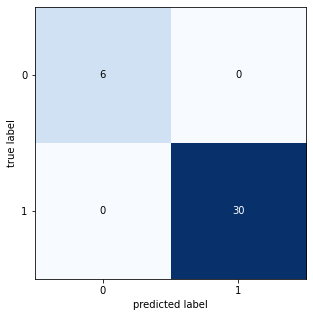

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

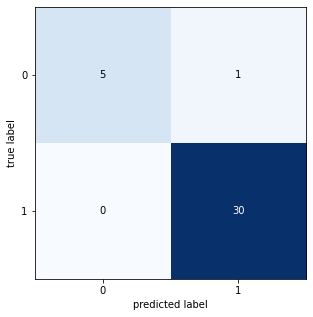

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

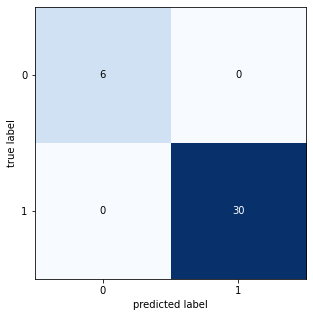

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.15278662399942
gen terbaik : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 39

Generation : 2
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0

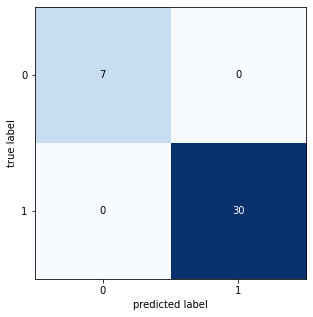

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

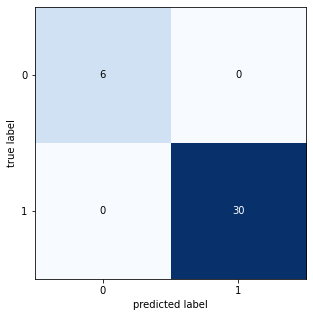

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

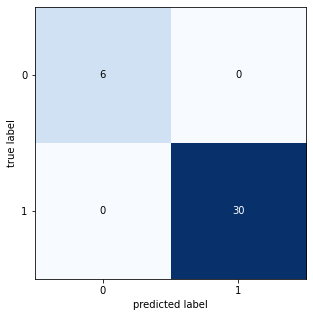

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

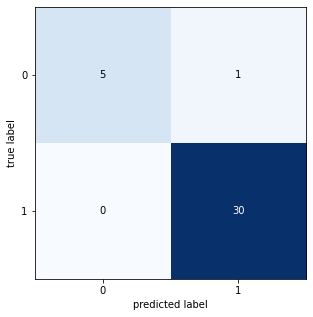

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

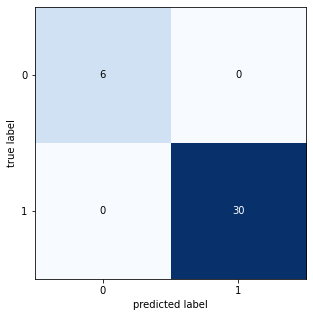

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.88602489799814
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

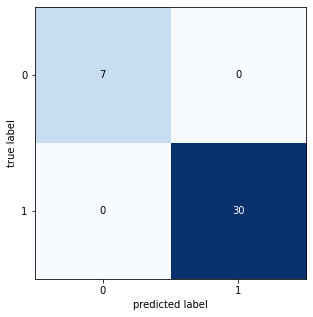

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

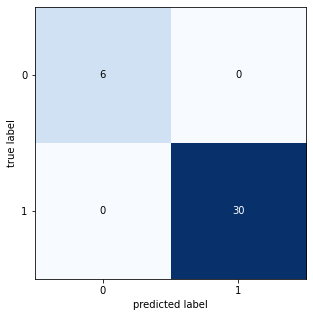

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

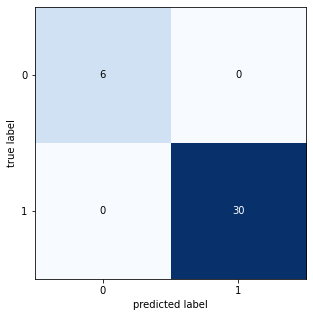

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

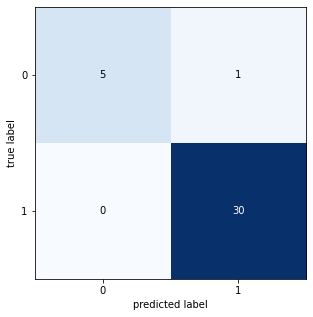

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

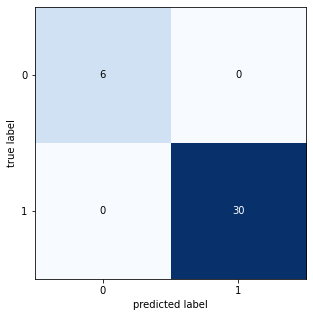

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.31253956200089
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

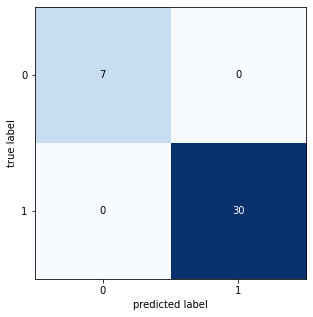

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

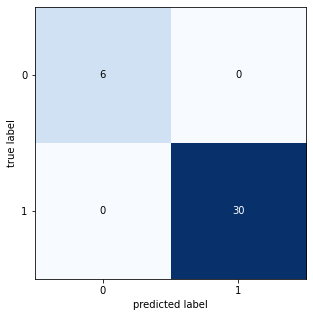

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

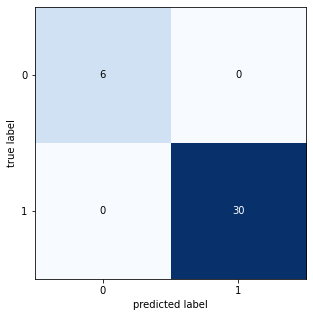

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

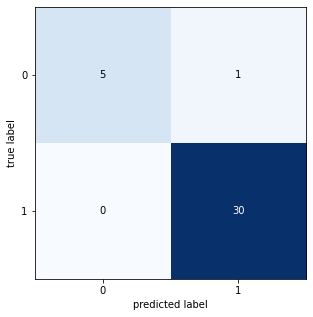

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

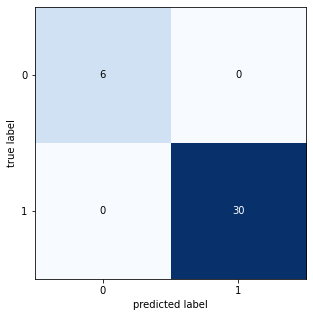

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.979836682003224
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

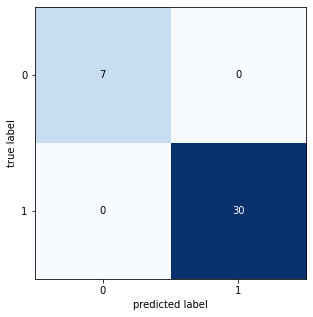

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

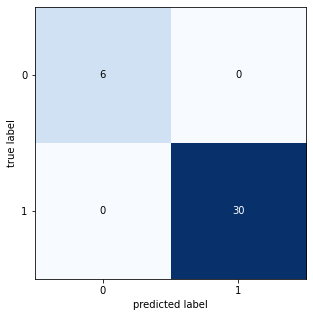

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

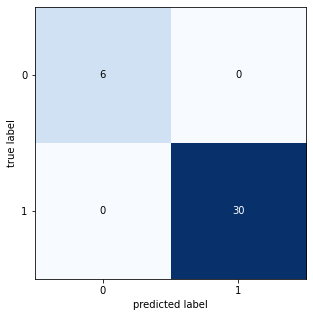

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

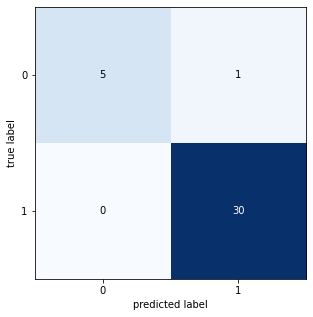

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

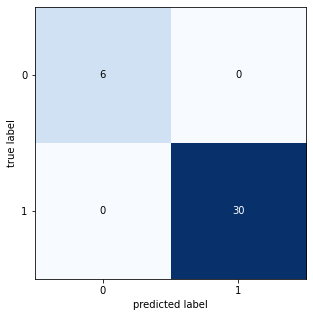

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.291063011001825
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

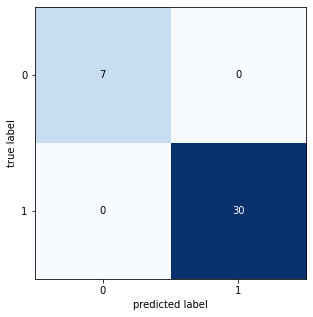

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

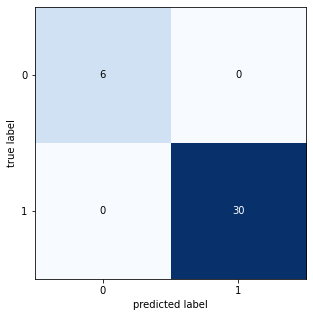

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

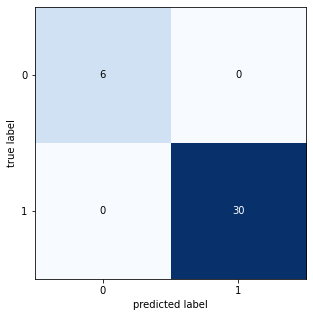

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

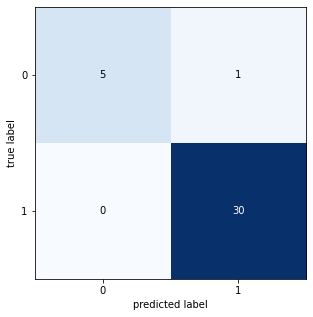

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

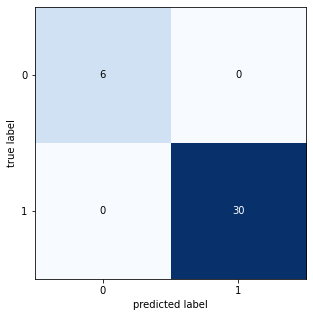

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.978120492000016
gene : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

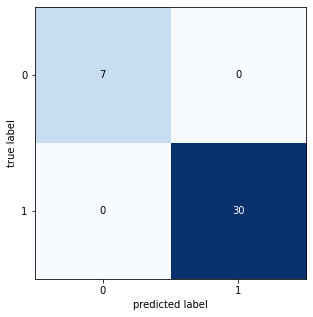

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

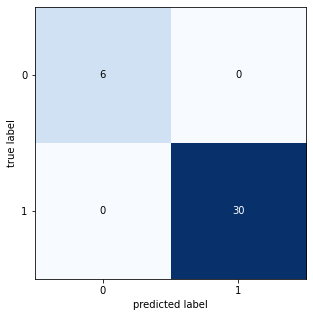

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

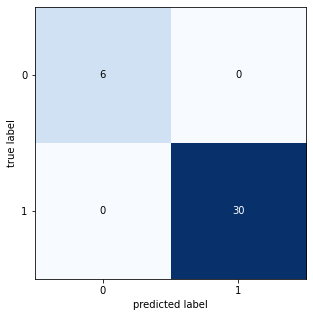

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

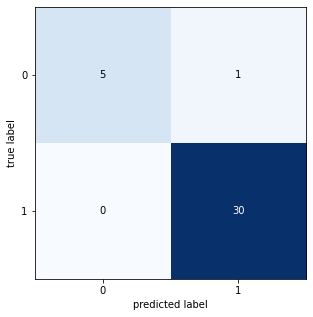

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

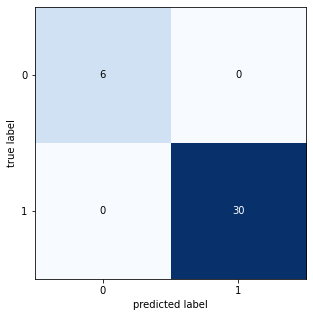

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.502622608997626
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

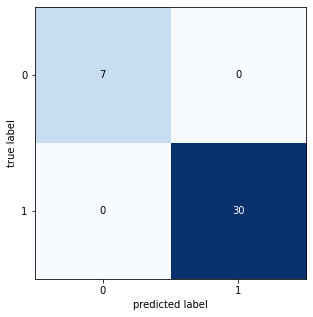

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

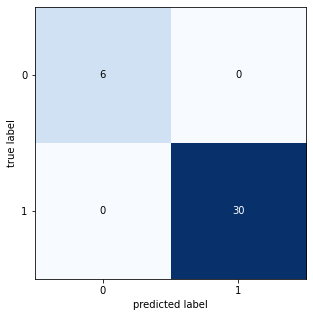

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

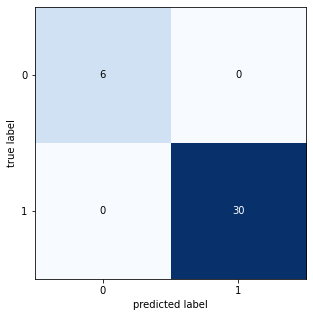

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

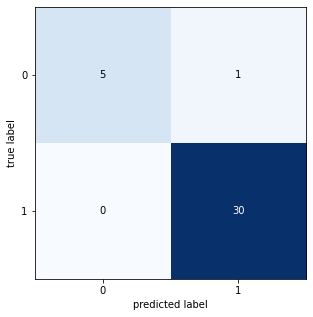

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

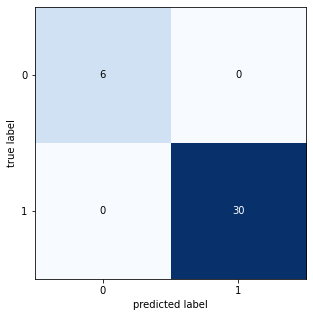

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.83784906599976
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

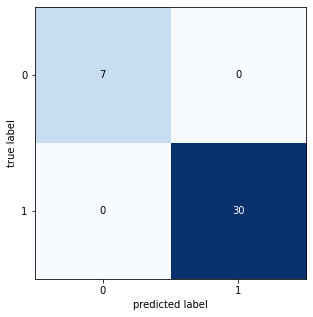

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

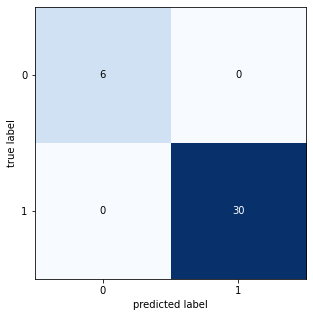

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

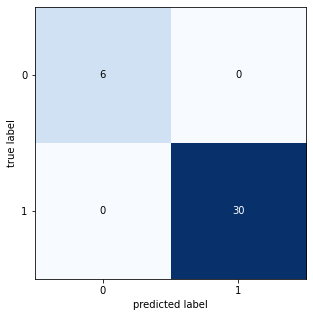

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

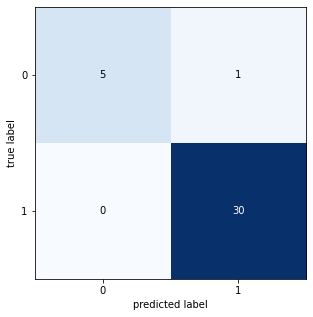

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

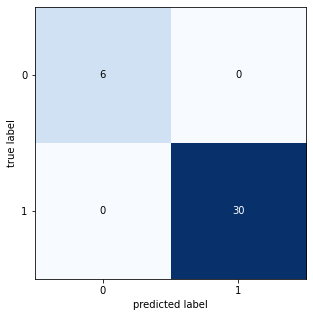

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  43.80833193199942
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

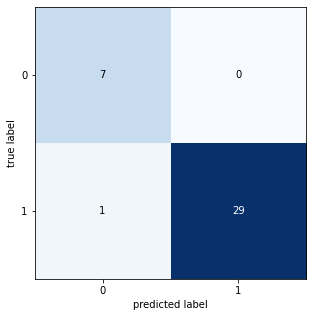

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

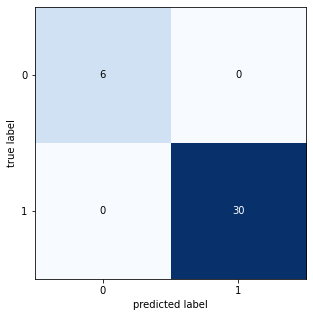

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

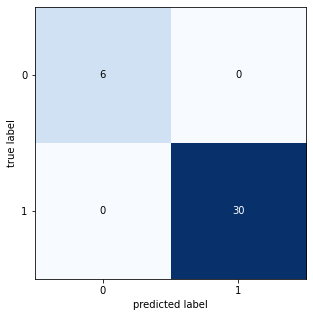

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

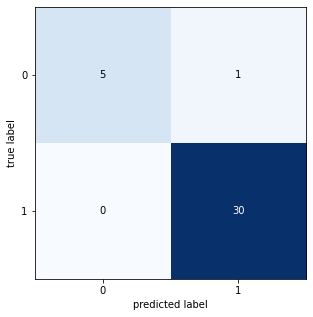

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

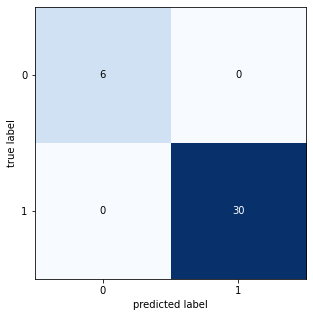

avg accuraccy Lung Cancer =  0.989039039039039
avg F1_Score Lung Cancer =  0.9809081647258917
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.88857506600107
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 122

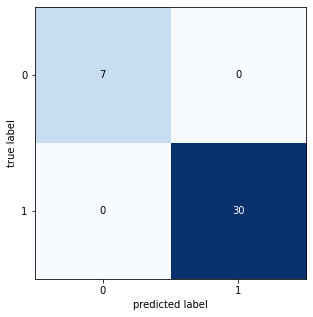

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

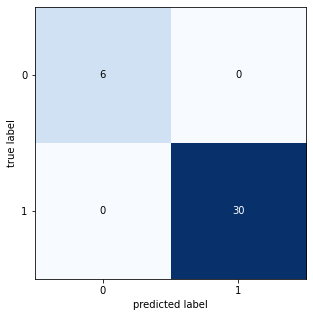

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

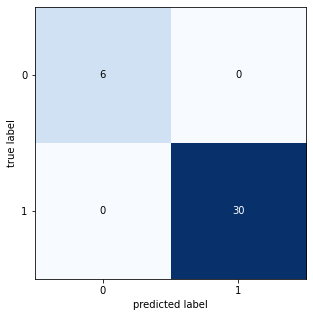

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

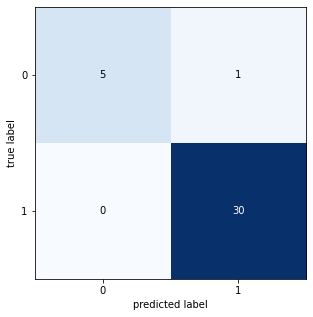

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

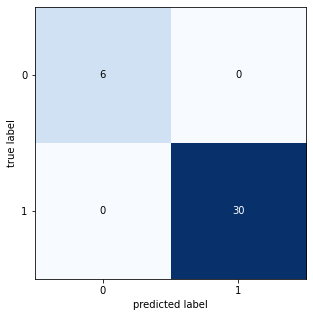

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.52390853199904
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 41

Generation : 3
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1

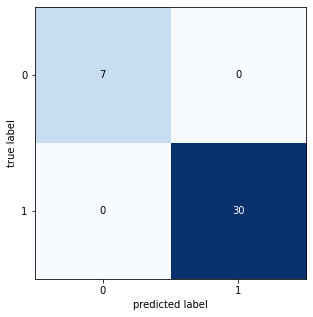

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

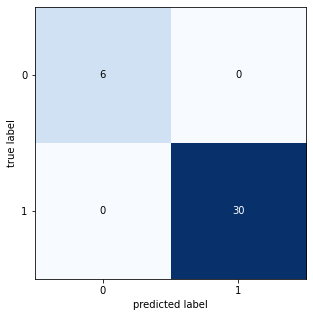

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

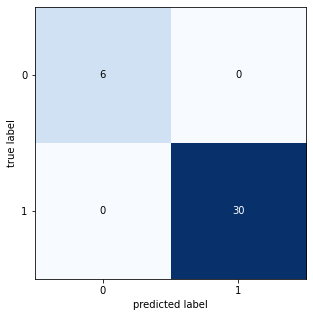

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

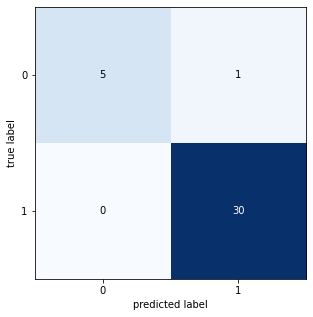

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

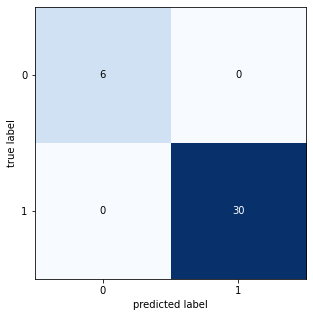

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.97358434000125
gene : [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

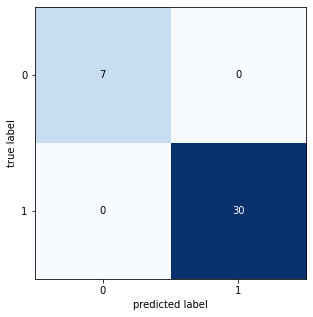

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

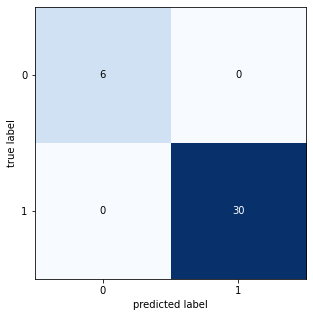

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

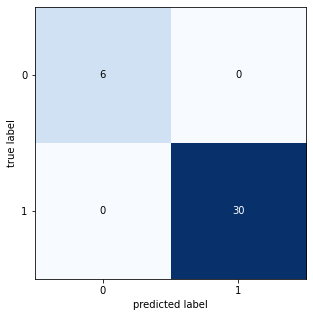

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

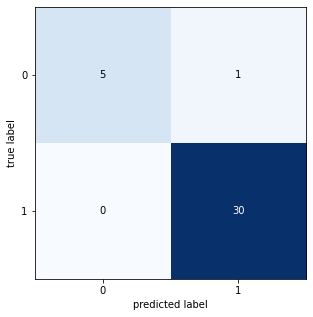

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

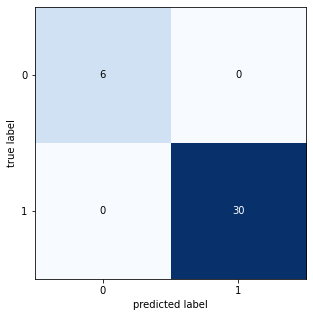

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.401969400998496
gene : [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

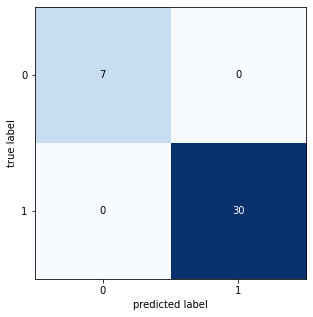

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

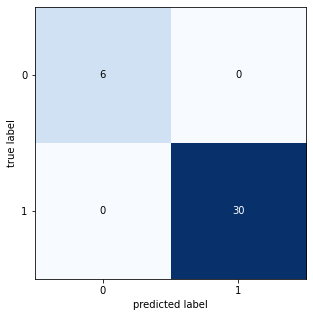

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

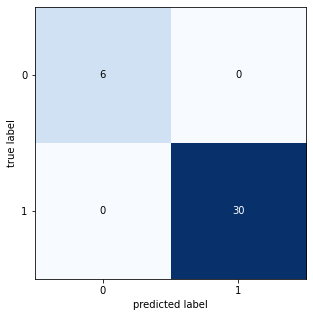

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

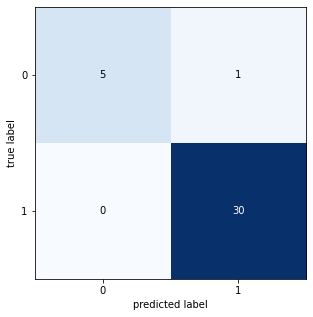

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

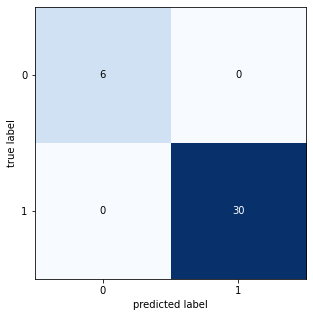

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.315641596000205
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

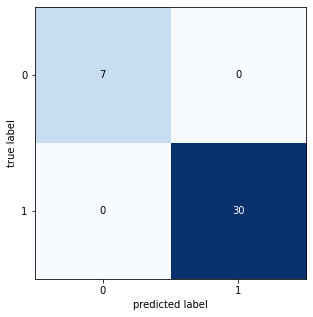

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

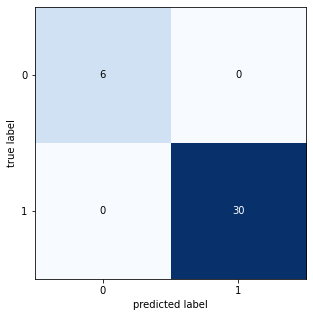

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

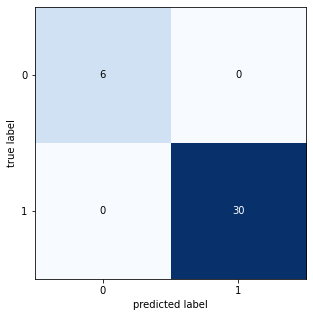

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

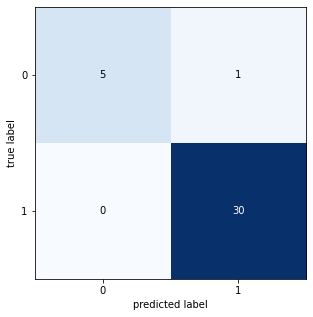

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

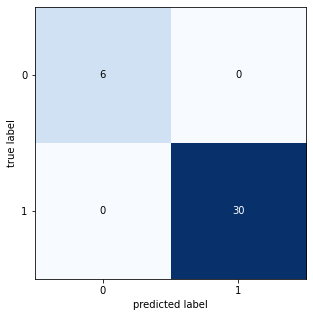

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.03621385599763
gene : [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

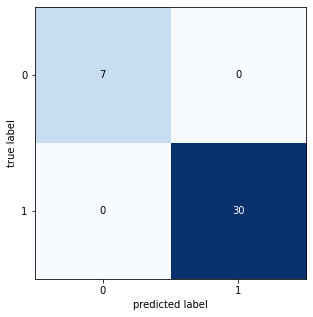

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

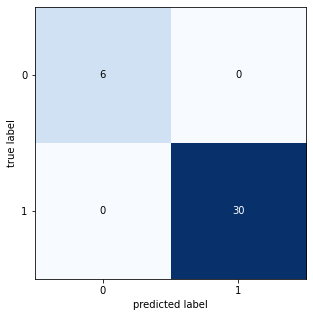

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

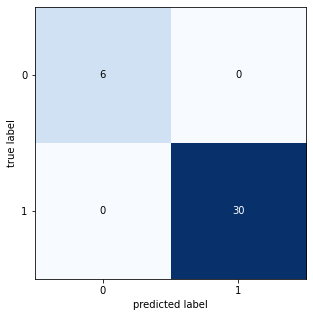

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

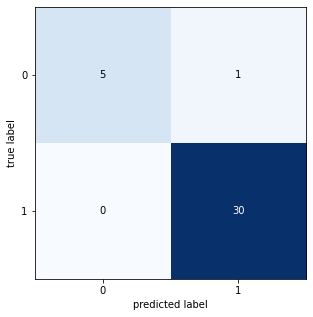

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

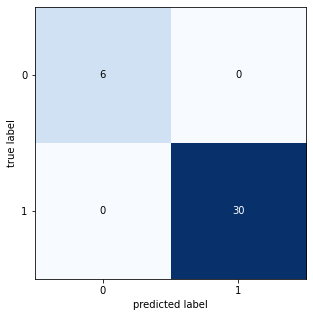

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  39.37011826399976
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

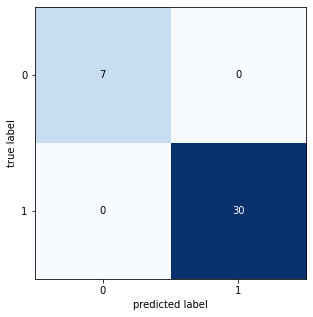

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

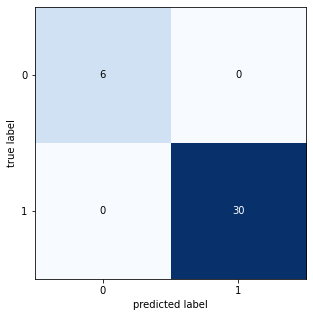

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

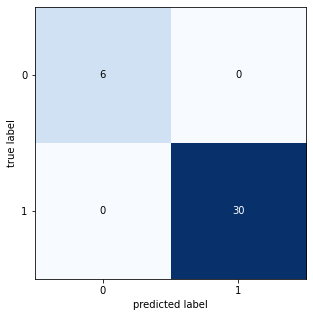

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

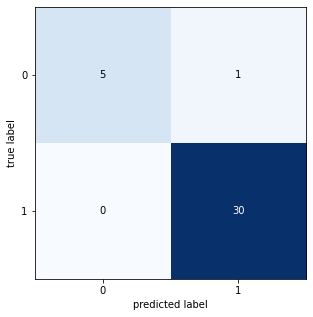

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

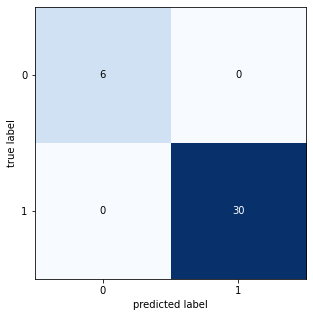

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.470535664000636
gene : [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

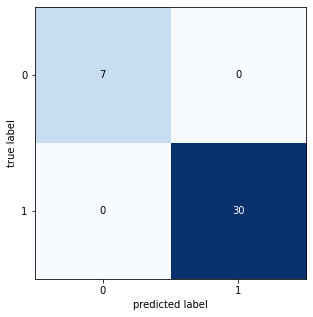

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

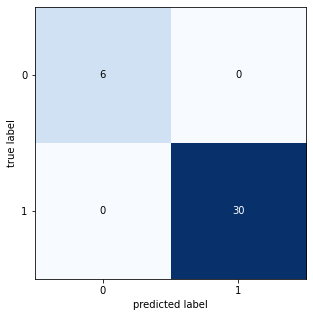

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

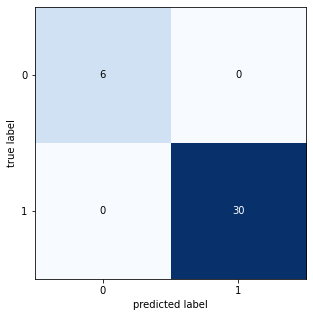

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

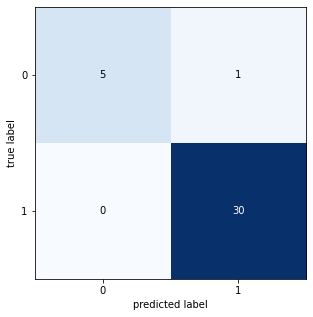

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

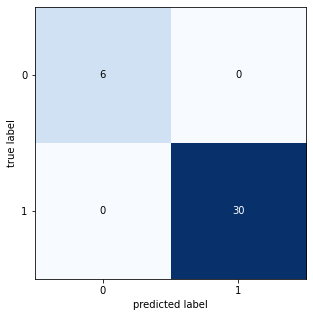

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.60524229199655
gene : [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

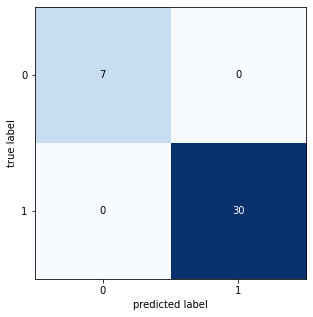

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

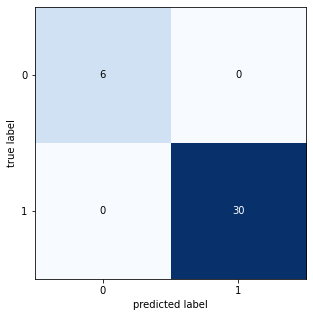

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

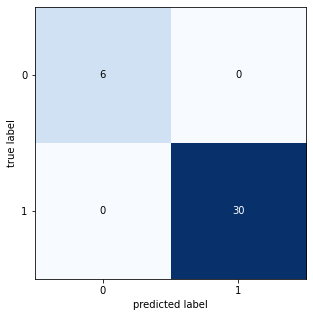

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

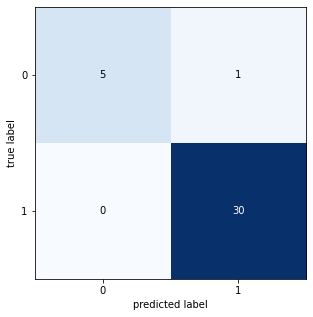

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

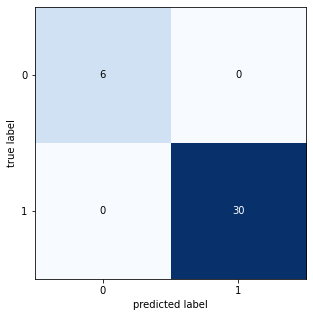

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.796556941000745
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

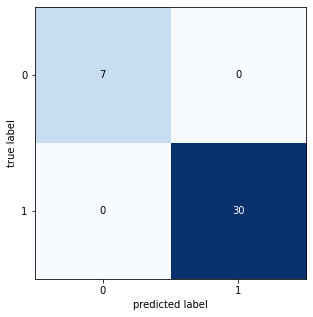

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

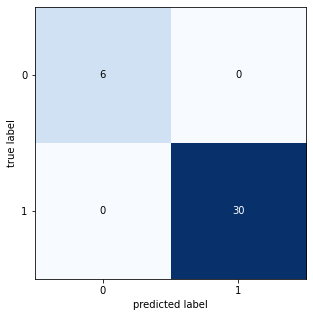

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

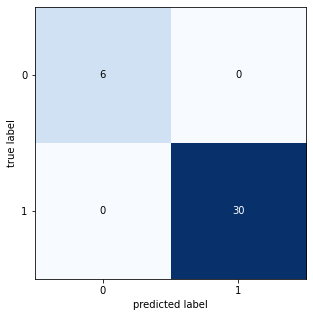

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

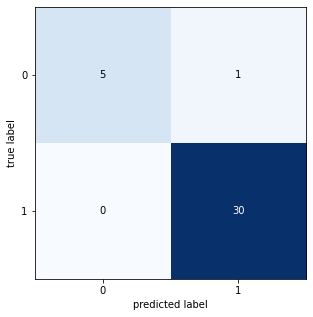

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

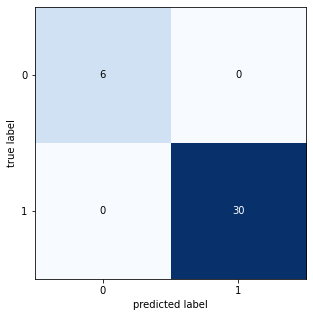

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.13786427699961
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

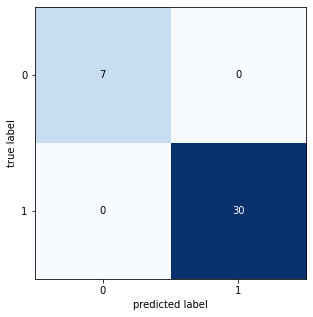

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

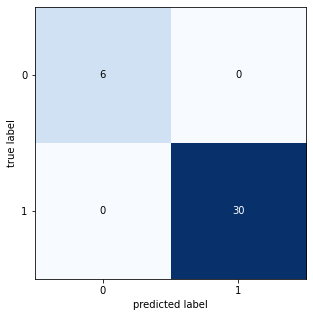

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

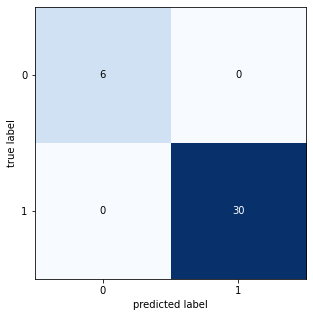

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

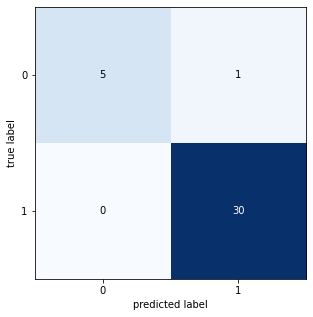

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

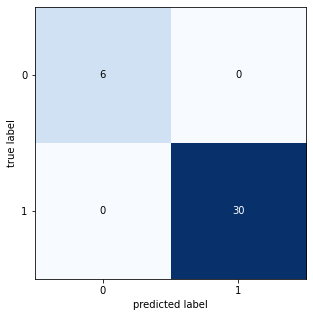

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.219384198000625
gen terbaik : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 36

Generation : 4
gene : [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

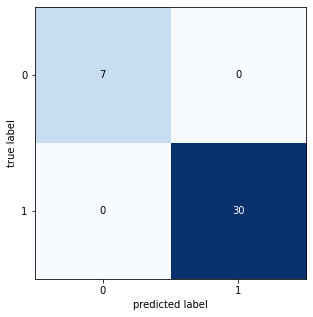

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

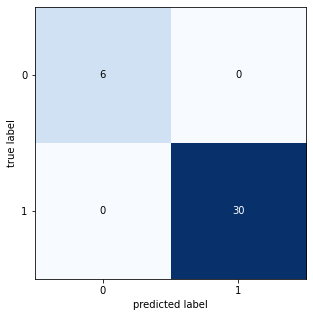

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

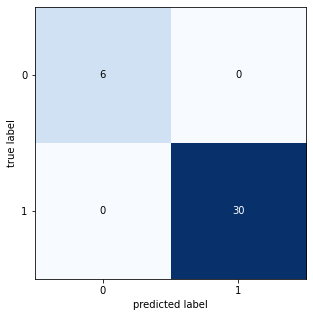

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

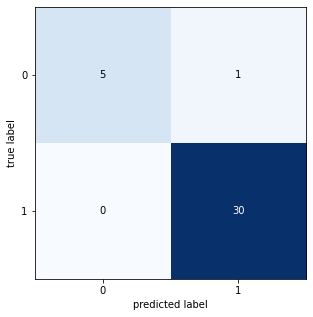

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

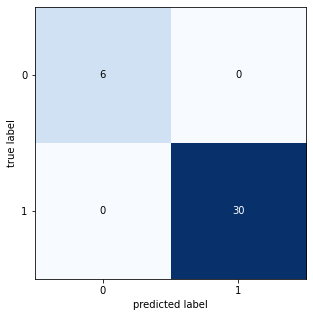

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.416245241998695
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

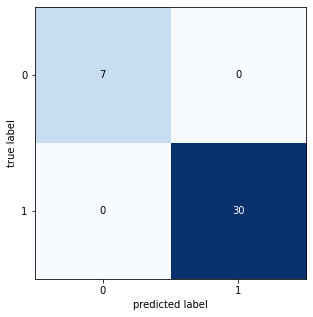

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

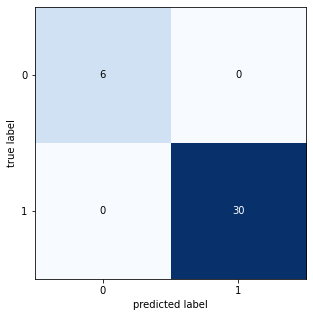

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

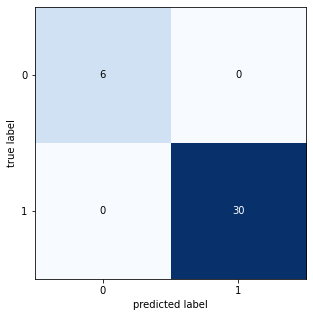

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

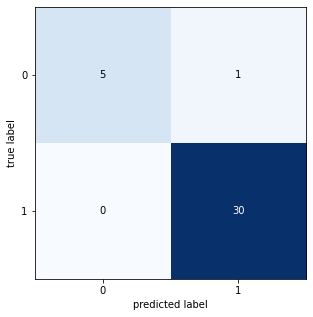

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

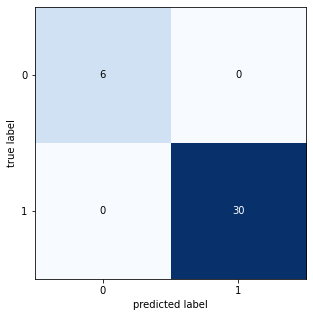

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.39883566699791
gene : [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

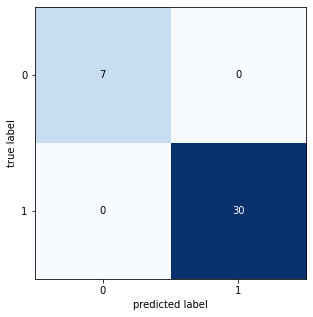

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

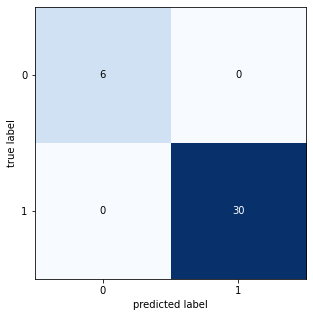

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

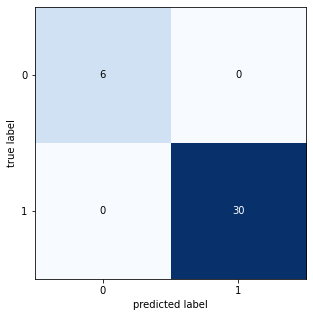

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

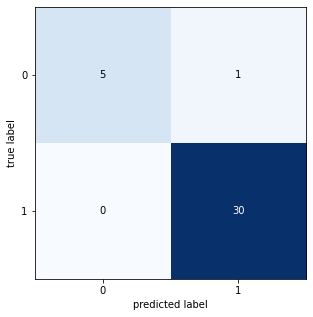

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

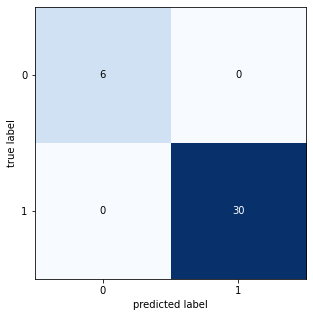

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  44.35871129700172
gene : [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

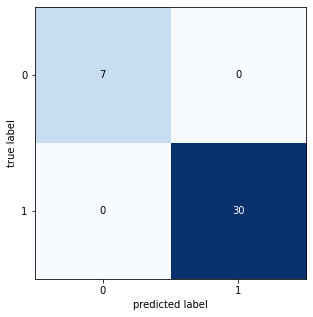

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

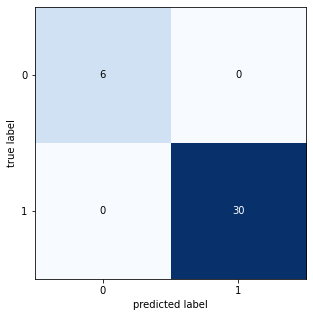

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

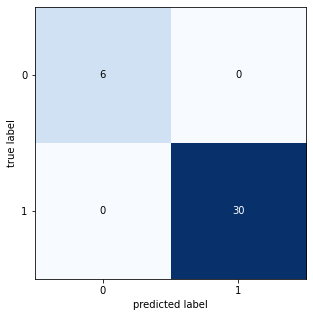

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

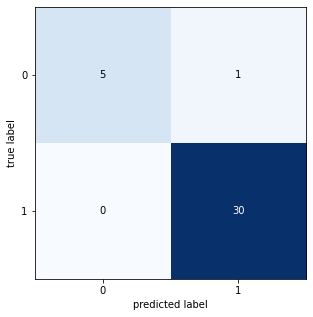

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

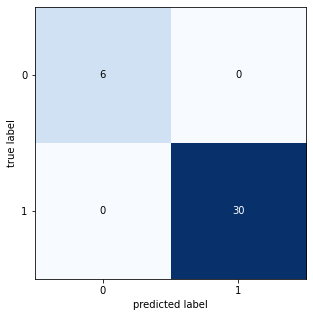

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.38580100800027
gene : [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

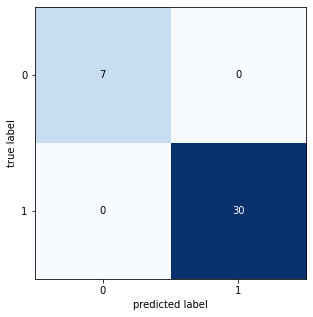

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

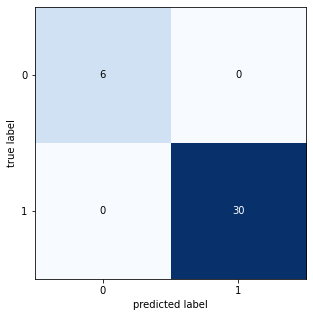

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

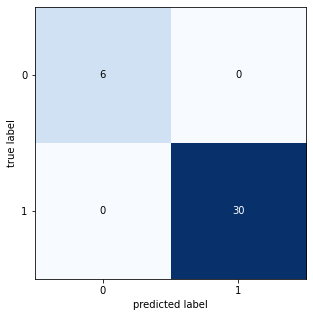

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

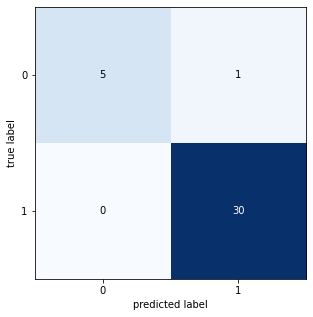

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

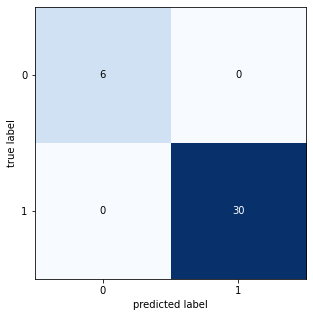

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  41.08790417799901
gene : [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

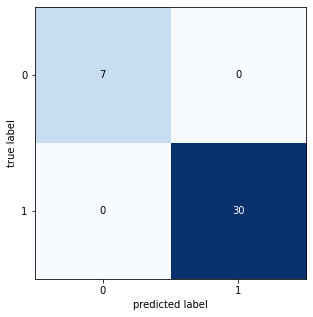

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

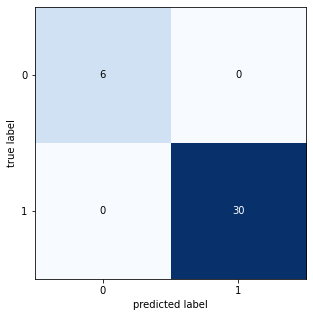

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

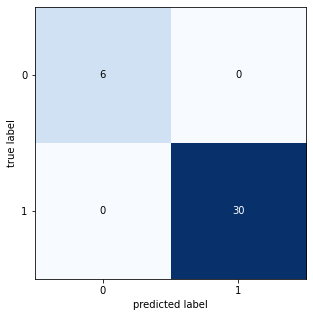

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

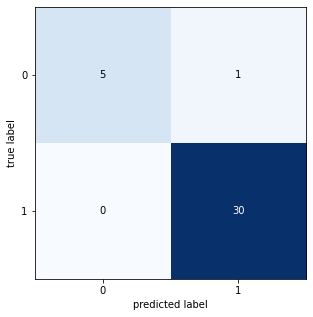

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

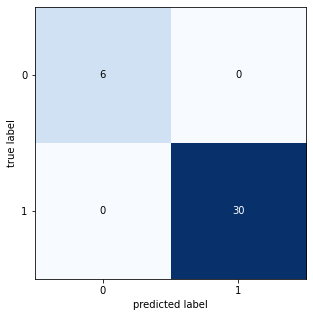

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.94478119699852
gene : [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

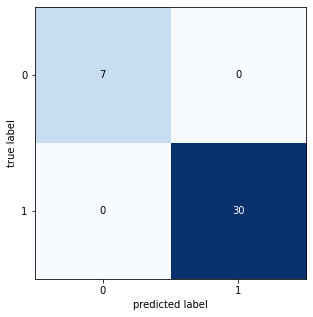

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

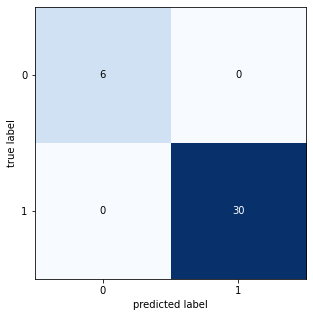

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

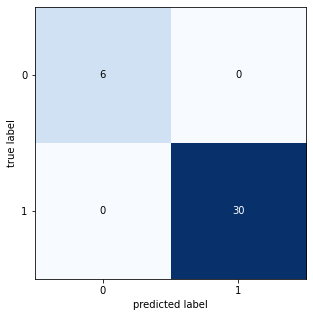

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

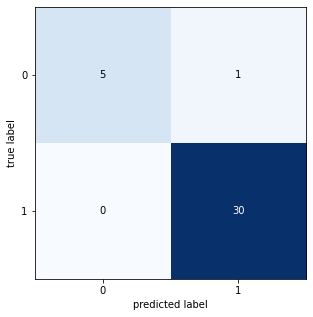

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

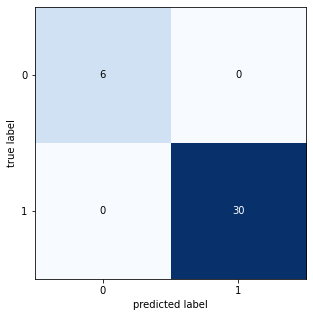

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  43.13993008699981
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

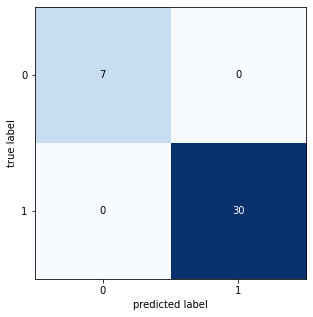

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

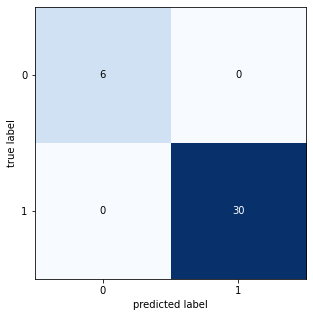

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

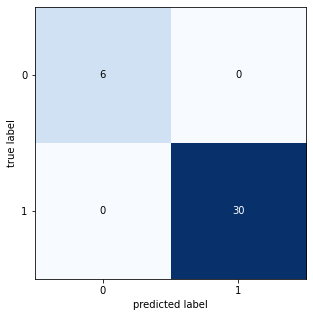

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

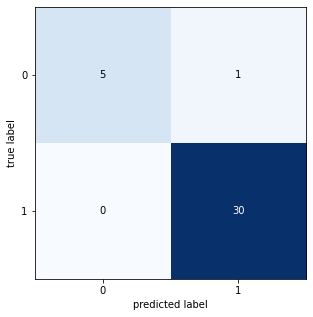

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

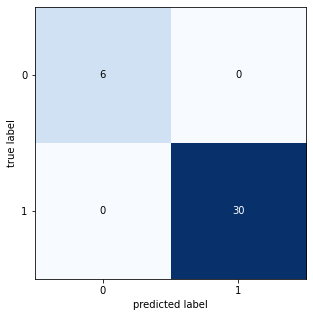

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  40.481321983999806
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 1

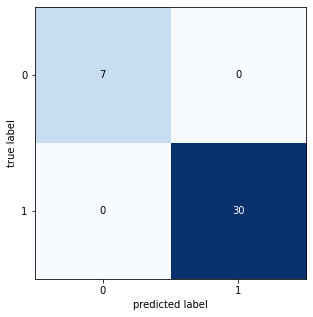

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

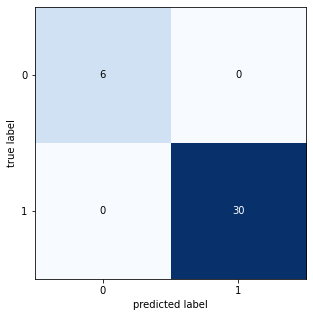

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

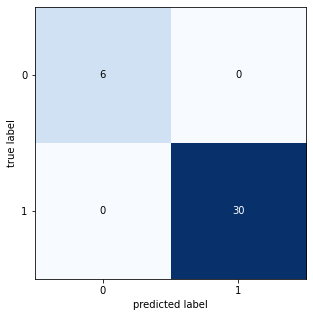

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

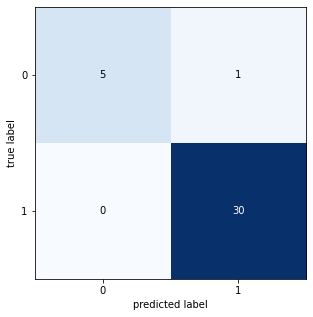

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

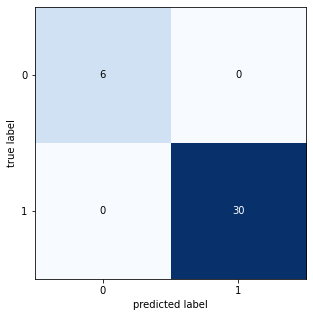

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  38.88327802200001
gene : [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Train : [  0   1   5   6   7   8  10  11  12  14  15  16  18  19  20  21  22  23
  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  43  44
  45  46  47  49  51  52  54  55  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  72  73  74  75  76  78  79  80  81  82  83  84  85  86
  87  88  90  91  92  93  99 101 102 103 104 105 106 107 108 109 110 111
 113 115 117 118 119 120 121 12

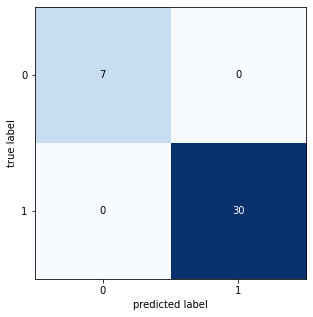

Train : [  0   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  65  66  67  69  70  71  72  73  76  77  78  79  80  81  82  83  84  87
  89  91  92  94  95  96  97  98  99 100 102 105 106 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 124 126 127 128 129 130 132 133 134
 136 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 154 155
 157 158 159 160 161 162 163 165 166 167 168 172 173 174 176 177 178 179
 180] Test : [  1   8  14  19  22  27  30  37  38  59  64  68  74  75  85  86  88  90
  93 101 103 104 107 122 123 125 131 135 139 153 156 164 169 170 171 175]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

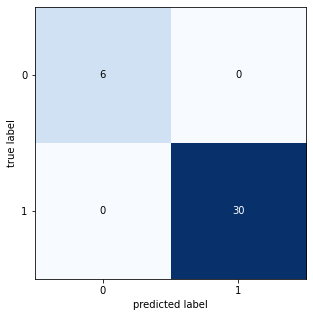

Train : [  0   1   2   3   4   5   7   8   9  10  13  14  16  17  18  19  20  21
  22  23  24  25  27  29  30  33  34  35  36  37  38  40  42  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  64  65  66  67  68  71
  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 109 111 112
 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 135 136 138 139 140 141 144 145 146 148 149 150 151 152 153 154
 155 156 157 160 162 163 164 166 167 168 169 170 171 173 175 177 178 179
 180] Test : [  6  11  12  15  26  28  31  32  39  41  43  44  47  58  62  63  69  70
  81  82 102 108 110 115 134 137 142 143 147 158 159 161 165 172 174 176]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

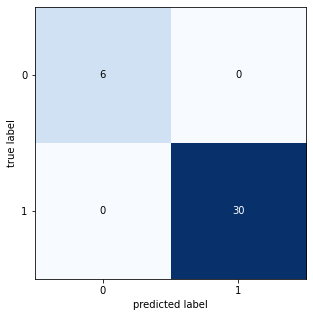

Train : [  1   2   3   4   6   7   8   9  11  12  13  14  15  17  19  20  22  23
  24  25  26  27  28  30  31  32  35  36  37  38  39  40  41  42  43  44
  45  47  48  49  50  53  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  81  82  83  85  86  88  89  90  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 115 116 119 120 122 123 125 128 129 130 131 132 134 135 136
 137 138 139 140 141 142 143 145 146 147 151 153 154 155 156 157 158 159
 160 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 178 179
 180] Test : [  0   5  10  16  18  21  29  33  34  46  51  52  54  60  66  72  73  80
  84  87  91 105 117 118 121 124 126 127 133 144 148 149 150 152 166 177]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

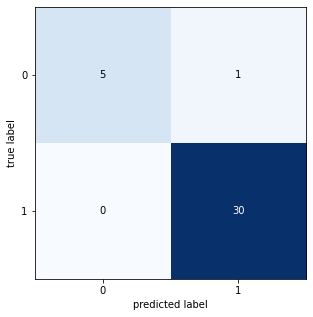

Train : [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  21  22  24  25  26  27  28  29  30  31  32  33  34  35  37  38  39
  41  43  44  46  47  48  50  51  52  53  54  56  58  59  60  62  63  64
  66  68  69  70  71  72  73  74  75  77  80  81  82  84  85  86  87  88
  89  90  91  93  94  95  96  97  98 100 101 102 103 104 105 107 108 110
 112 114 115 116 117 118 121 122 123 124 125 126 127 129 130 131 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 152 153 156
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 174 175 176 177
 180] Test : [  7  20  23  36  40  42  45  49  55  57  61  65  67  76  78  79  83  92
  99 106 109 111 113 119 120 128 132 145 151 154 155 157 163 173 178 179]
Y_Train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

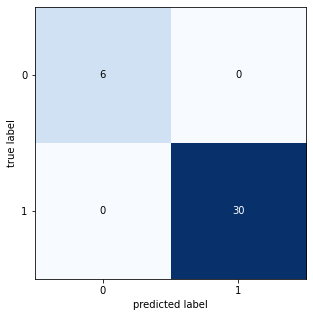

avg accuraccy Lung Cancer =  0.9944444444444445
avg F1_Score Lung Cancer =  0.9892697466467958
max accuraccy Lung Cancer =  1.0
max F1_Score Lung Cancer =  1.0
min accuraccy Lung Cancer =  0.9722222222222222
min F1_Score Lung Cancer =  0.9463487332339791
Running Time:  42.64505819899932
gen terbaik : [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.9892697466467958  || Akurasi terbaik : 0.9944444444444445  || jumlah fitur : 59

Running Time:  2045.9366452859977


In [15]:
Lung_IG_GA = GeneticAlgorithm(Lung_IG, 4)